## Dependencies and custom functions

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #suppress pandas futurewarnings 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

def FACT_Loader(path):
    """Returns a list of lists with FACT values.
    
    Takes path of a .bed file as argument and returns a list of c lists of varying 
    dimensions n, where c is the number of chromosomes and n is length of the 
    respective chromosome. """

    data = pd.read_csv(path, sep="\t", names = ["Chr_no","Start","Stop","Signal"]) #Supply column names for .bed file
    FACT_data = []  #initialise empty list to store lists of FACT values
    chromosomes = ["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII","XIII","XIV","XV","XVI"]

    for i in range(len(chromosomes)):

        mask = "chr"+chromosomes[i] #create mask
        chrm_data = data[data['Chr_no']==mask] #filter entries by chromosome number mask
        chrm_data.reset_index(inplace=True) #reset indices from 0, so that we can loop through

        FACT_data.append(np.zeros(chrm_data['Stop'].max())) #initialise zero array – necessary as zero signals are ommitted from .bed files

        for j in range(len(chrm_data)): #loop to populate the zero array with FACT values

            for entries in range(chrm_data['Start'][j],chrm_data['Stop'][j]):
                FACT_data[i][entries] = chrm_data['Signal'][j] #extract signals b/w start and stop position
    return FACT_data


def Extract_gene_FACT(gene_path, FACT_data, start = '+1 nucleosome'):
    """Returns a dataframe with gene names as index and FACT values as cols.

    Takes file-path of an .xsls file with names of genes and their
    nucleosome locations and an array of FACT values. Optionally, we can
    specify a start position other than +1 nucleosome. Returns a dataframe, 
    where gene names are the indices and cols 0-999 hold FACT values at 
    corresponding bp distances from start position.
    """

    gene_data = pd.read_excel(gene_path)
    chromosomes = ["I","II","III","IV","V","VI","VII","VIII","IX","X","XI","XII","XIII","XIV","XV","XVI"]
    FACT_gene_data = {} #initialise dictionary to hold genes (keys) and FACT levels (values)

    for i in range(len(chromosomes)):

        mask = "chr"+chromosomes[i] #create mask
        chrm_data = gene_data[gene_data['Chr']==mask] #filter entries by chromosome number mask
        chrm_data.reset_index(inplace=True)

        for j in range(len(chrm_data)):

            gene_name = chrm_data['ORF'][j] #retrieve gene's name (or ORF; open reading frame)
            gene_values = [] #to store FACT levels
        
            ll = chrm_data[start][j] #lower limit is the start position (+1 nucleosome, by default)
            ul = ll-1000 if chrm_data['Strand'][j]=="-1" else ll+1000 #upper limit is 1000 adjacent positions, with direction (+1 vs -1) depending on the DNA strand

            for entries in range(ll,ul): #loop through lower and upper limits & update dict with gene name (key) & Fact array (values)
                gene_values.append(FACT_data[i][entries]) 

            FACT_gene_data[gene_name] = gene_values 

    return pd.DataFrame.from_dict(FACT_gene_data).transpose() #make df with gene names as index and cols0-999 FACT values



## Data Wrangling

### Pull data

In [2]:
#Specify file paths
gene_path = ".../MSc-Project-Genetics/13059_2018_1398_MOESM2_ESM.xlsx"
WT_signal_path = ".../MSc-Project-Genetics/GSE155143_MNaseChIP_Spt16_yFR116WT_CJ1-CJ2_20191021.bed"
WT_input_path =  ".../MSc-Project-Genetics/GSE155143_MNaseInput_Spt16_yFR116WT_CJ5-CJ6_20191021.bed"
mutant_signal_path = ".../MSc-Project-Genetics/GSE155143_MNaseInput_Spt16_yFR930chd1D_CJ7-CJ8_20191021.bed"
mutant_input_path = ".../MSc-Project-Genetics/GSE155143_MNaseChIP_Spt16_yFR930chd1D_CJ3-CJ4_20191021.bed"


#Call custom functions to load data
WT_S = FACT_Loader(WT_signal_path)
WT_S = Extract_gene_FACT(gene_path, WT_S)

WT_input = FACT_Loader(WT_input_path)
WT_input = Extract_gene_FACT(gene_path, WT_input)

mutant_S = FACT_Loader(mutant_signal_path)
mutant_S = Extract_gene_FACT(gene_path, mutant_S)

mutant_input = FACT_Loader(mutant_input_path)
mutant_input = Extract_gene_FACT(gene_path, mutant_input)

### Feature Scaling

In [3]:


def znorm(df,axis=0):
    '''Returns a z-normalised, also known as standardised (µ=0, σ=1), copy of the dataframe df.'''

    if axis==1:
        return df.sub(df.mean(axis=1),axis=0).div(df.std(axis=1),axis=0) 
    else:
        return (df-df.mean())/df.std()
    

def meannorm(df):
    '''Returns a mean-normalised copy of the dataframe df. Note: only designed to work for axis =1.'''
    
    #Find the min, max, mean of each row.
    max = df.max(axis=1)
    min = df.min(axis=1)
    mean = df.mean(axis=1)

    #From each column, subtract the means of the respective rows then divide by the range of the respective rows
    return df.sub(mean,axis=0).div(max-min,axis=0)    

#Compute z-normalised and mean-normalised versions of Signal (S) and Signal-Input (SI) for WT and Chd1∆
WT_S_znorm = znorm(WT_S, axis=1)
WT_S_meannorm = meannorm(WT_S)
WT_SI = WT_S -  WT_input
WT_SI_znorm = znorm(WT_S -  WT_input, axis=1)
WT_SI_meannorm = meannorm(WT_S -  WT_input)

mutant_S_znorm = znorm(mutant_S, axis=1)
mutant_S_meannorm = meannorm(mutant_S)
mutant_SI = mutant_S - mutant_input
mutant_SI_znorm = znorm(mutant_SI, axis=1)
mutant_SI_meannorm = meannorm(mutant_SI)

#Store dataset names and values in lists, for easy access
ds_names_list = ["WT_S","WT_S_znorm","WT_S_meannorm","WT_SI","WT_SI_znorm","WT_SI_meannorm",
                 "mutant_S","mutant_S_znorm","mutant_S_meannorm","mutant_SI","mutant_SI_znorm","mutant_SI_meannorm"]

ds_list = [WT_S, WT_S_znorm, WT_S_meannorm,WT_SI,WT_SI_znorm,WT_SI_meannorm,
                  mutant_S,mutant_S_znorm,mutant_S_meannorm,mutant_SI,mutant_SI_znorm,mutant_SI_meannorm]



## K-means Clustering

In [4]:
max_k = 8 #highest_k, used throughout .ipynb


In [5]:
def find_K_clusters(max_k,ds): 
    '''Returns a 3-tuple comprising lists of clusters, labels, and inertias. 
    
    Runs KMeans on ds for each k in range (2, max_k). Then, returns three responses: 
    lists, respectively, of clusters, labels, and inertias.'''

    #Initiliase lists to store results of K-Means runs
    clusters = []
    labels_all = []
    inertias_all = []

    for i in range(2,max_k+1): #Run K-means from k = 2 to k = max_k
        model = KMeans(n_clusters=i,n_init= 'auto', random_state=29032024) #random_state to ensure reproducibility
        model.fit(ds) 
        labels = model.labels_ #find labels, where 0 = cluster1 
        masks = [labels == m for m in range(i)] #create masks for every cluster 
        
        #populate lists with clusters, labels, and inertias
        clusters.append([ds[m] for m in masks])
        labels_all.append(labels)
        inertias_all.append(model.inertia_)
        
    return clusters,labels_all, inertias_all #use slicing to retrieve any one list, e.g., find_K_clusters(...) [2] for inertia values

In [6]:
def find_silhouette(max_k,ds):
    '''Returns an array of silhouette scores for running K-means upto max_k on ds.
    
    Takes as arguments max_k and a dataset ds. Runs K-means between (2, max_k) times
    and computes overall silhouette score on each run, and returns scores as a list.'''

    labels = find_K_clusters(max_k,ds)[1]  #use slicing, i.e. [1], to retrieve labels 
    return [silhouette_score(ds,labels[i]) for i in range(len(labels))] 


#Store silhouette scores as a computationally expensive procedure
silhouette_score_dict = {}
for idx in range (len(ds_names_list)):
    silhouette_score_dict[ds_names_list[idx]] = find_silhouette(max_k, ds_list[idx])
SS_df = pd.DataFrame(silhouette_score_dict)

## GO Analysis

In [7]:
#Export gene names (ORF) by cluster for WT SI z-normed

clusters = find_K_clusters(3,WT_SI_znorm)[1][-1] #[1] to find labels and [-1] to retrieve from only last K-means run (here k = 3)

cluster1 =WT_S[clusters==0].index.tolist()
cluster2 =WT_S[clusters==1].index.tolist()
cluster3 =WT_S[clusters==2].index.tolist()

pd.DataFrame(cluster1).to_csv("WT_SI_znorm_cluster1.txt",sep=",", index=False)
pd.DataFrame(cluster2).to_csv("WT_SI_znorm_cluster2.txt",sep=",", index=False)
pd.DataFrame(cluster3).to_csv("WT_SI_znorm_cluster3.txt",sep="," ,index=False)

In [8]:
#Import results of PANTHER

def prep_Panther(filepath:str,domain:str):
    '''Imports and pre-processes PANTHER ORA results for plotting. 
    
    
    Imports .txt file output from PANTHER and formats df for plotting the Gene Ontology
    over-representation analysis results. It works for Fisher's exact test with Bonferroni 
    correction. Note: for other test parameters on PANTHER, change rows and cols.'''

    import math
    import re

    f = pd.read_csv(filepath, sep= '\t', skiprows=range(0,12)) #remove meta-data rows
    f = f.iloc[:,[0,5,6]] #extract 3 columns: name, enrichment, and p

    f = f.set_axis([domain,"log2fold Enrichment", "Adjusted p"],1) #Rename columns

    f.iloc[:,0]=f.iloc[:,0].apply(lambda x: re.split("\(",x)[0]) #Remove GEO accession IDs from names 
    f.iloc[:,1]=f.iloc[:,1].apply(lambda x: 0.01 if x == " < 0.01" else float(x)) #read in data as floats, esp. entries with (< 0.01) disclaimer
    f.iloc[:,1]=f.iloc[:,1].apply(lambda x: math.log(x,2)) #find log base-2 of fold enrichment
    return f
    

cl1_mol = prep_Panther("WT SI znorm cluster1 molecular.txt","Molecular Function")
cl2_mol = prep_Panther("WT SI znorm cluster2 molecular.txt","Molecular Function")
cl3_mol = prep_Panther("WT SI znorm cluster3 molecular.txt","Molecular Function")

cl1_bio = prep_Panther("WT SI znorm cluster1 biology.txt","Biological Process")
cl2_bio = prep_Panther("WT SI znorm cluster2 biology.txt","Biological Process")
cl3_bio = prep_Panther("WT SI znorm cluster3 biology.txt","Biological Process")

cl1_cell = prep_Panther("WT SI znorm cluster1 cellular.txt", "Cellular Component")
cl2_cell = prep_Panther("WT SI znorm cluster2 cellular.txt", "Cellular Component")
cl3_cell = prep_Panther("WT SI znorm cluster3 cellular.txt", "Cellular Component")

# Figures

In [9]:
import os
import scienceplots #Library for plotting scientific figures
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin' #Requires LateX, see documentation for scienceplots
plt.style.use('science')

### Fig 4.Influence of Scaling Factor (SF)

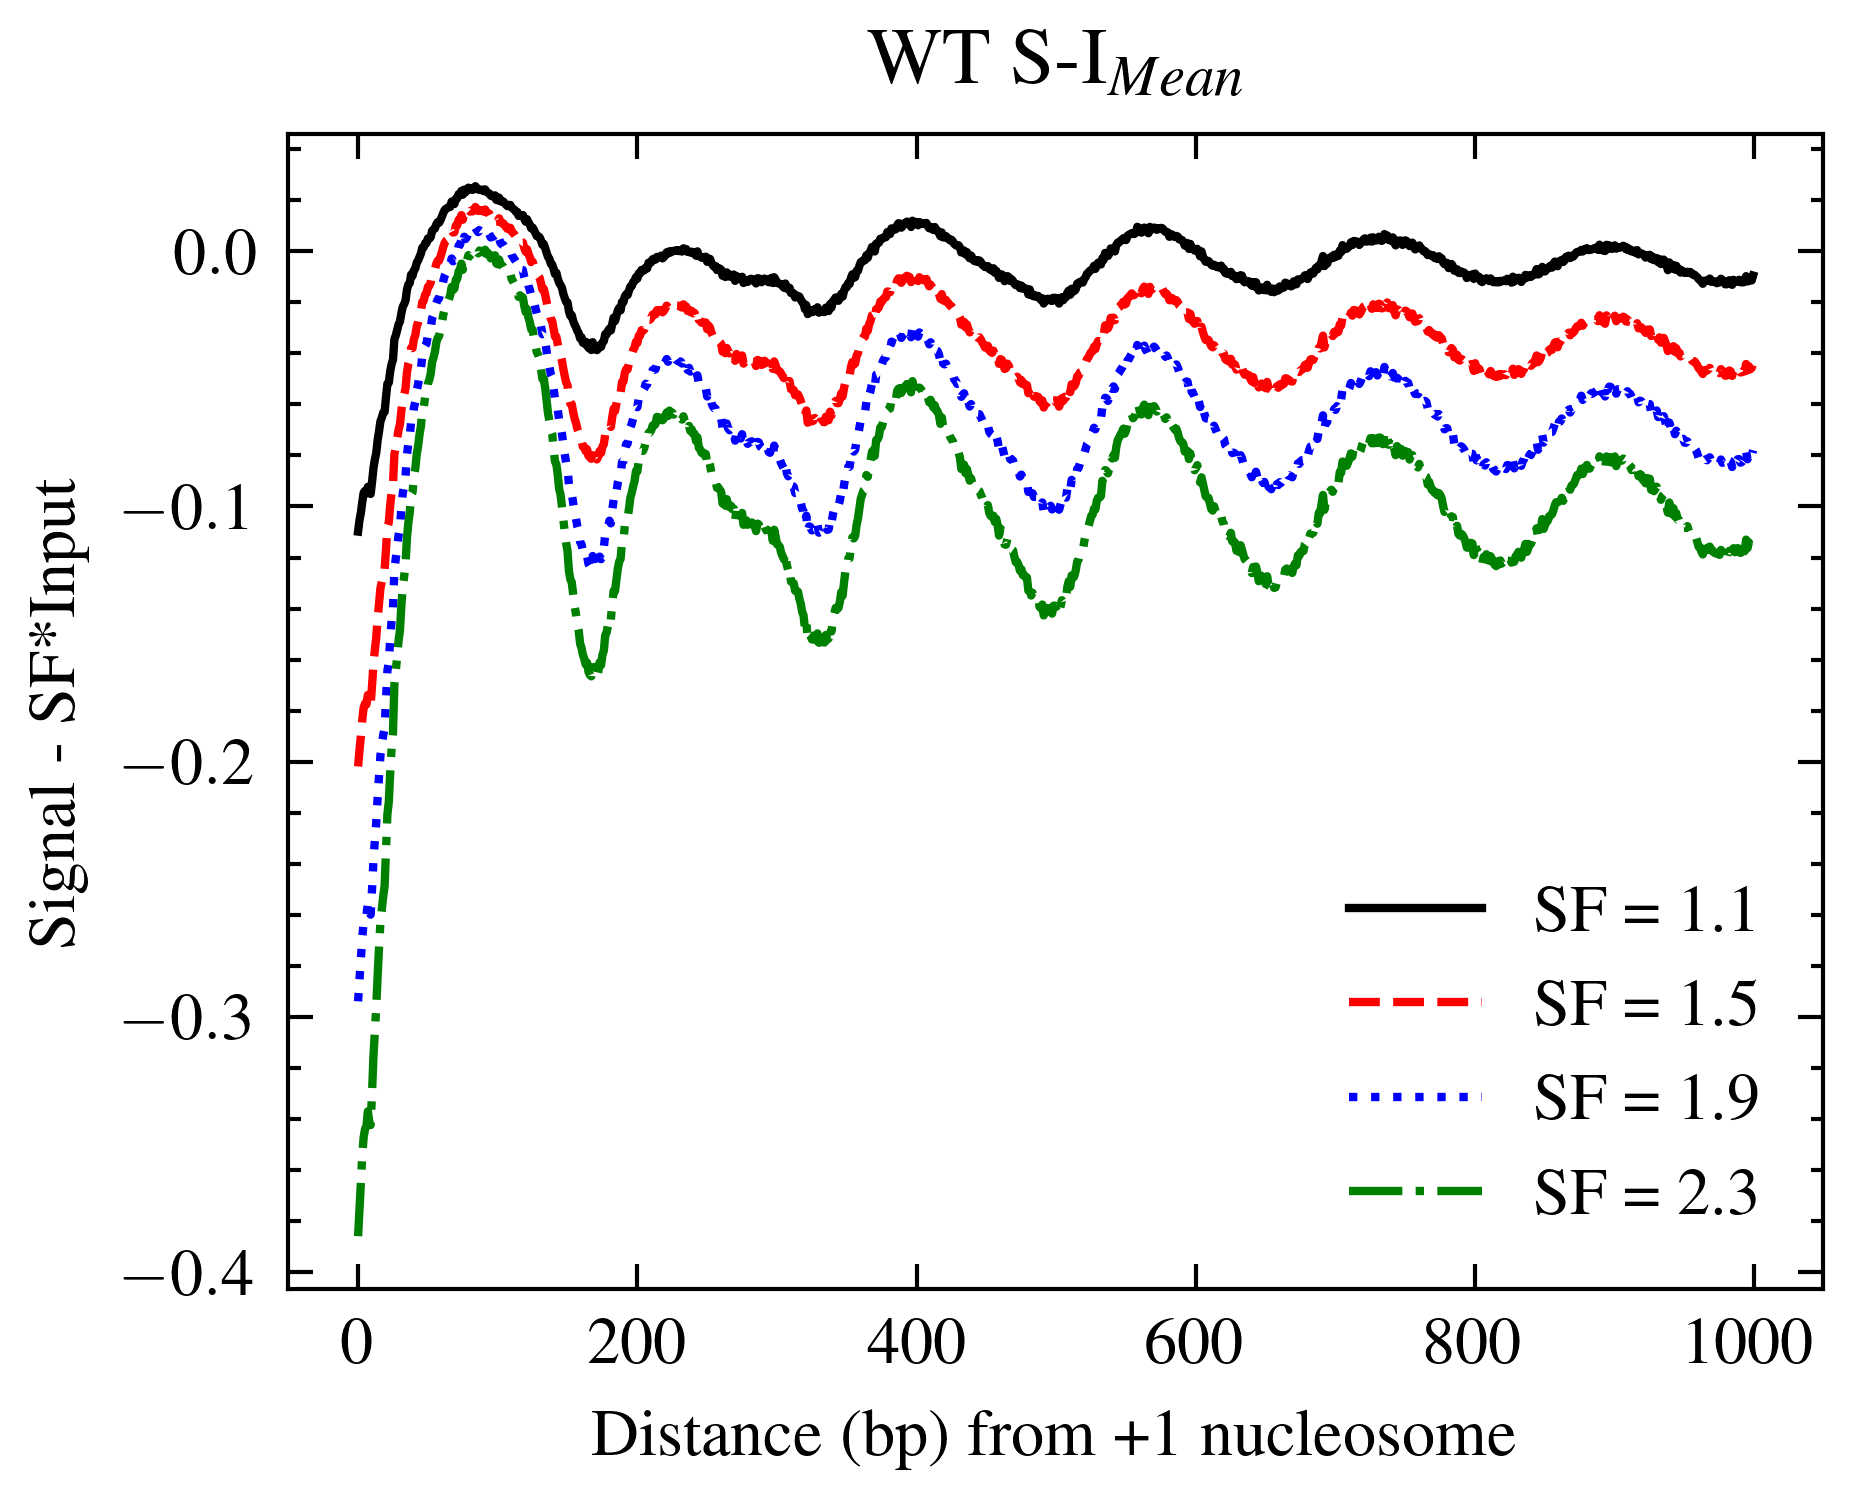

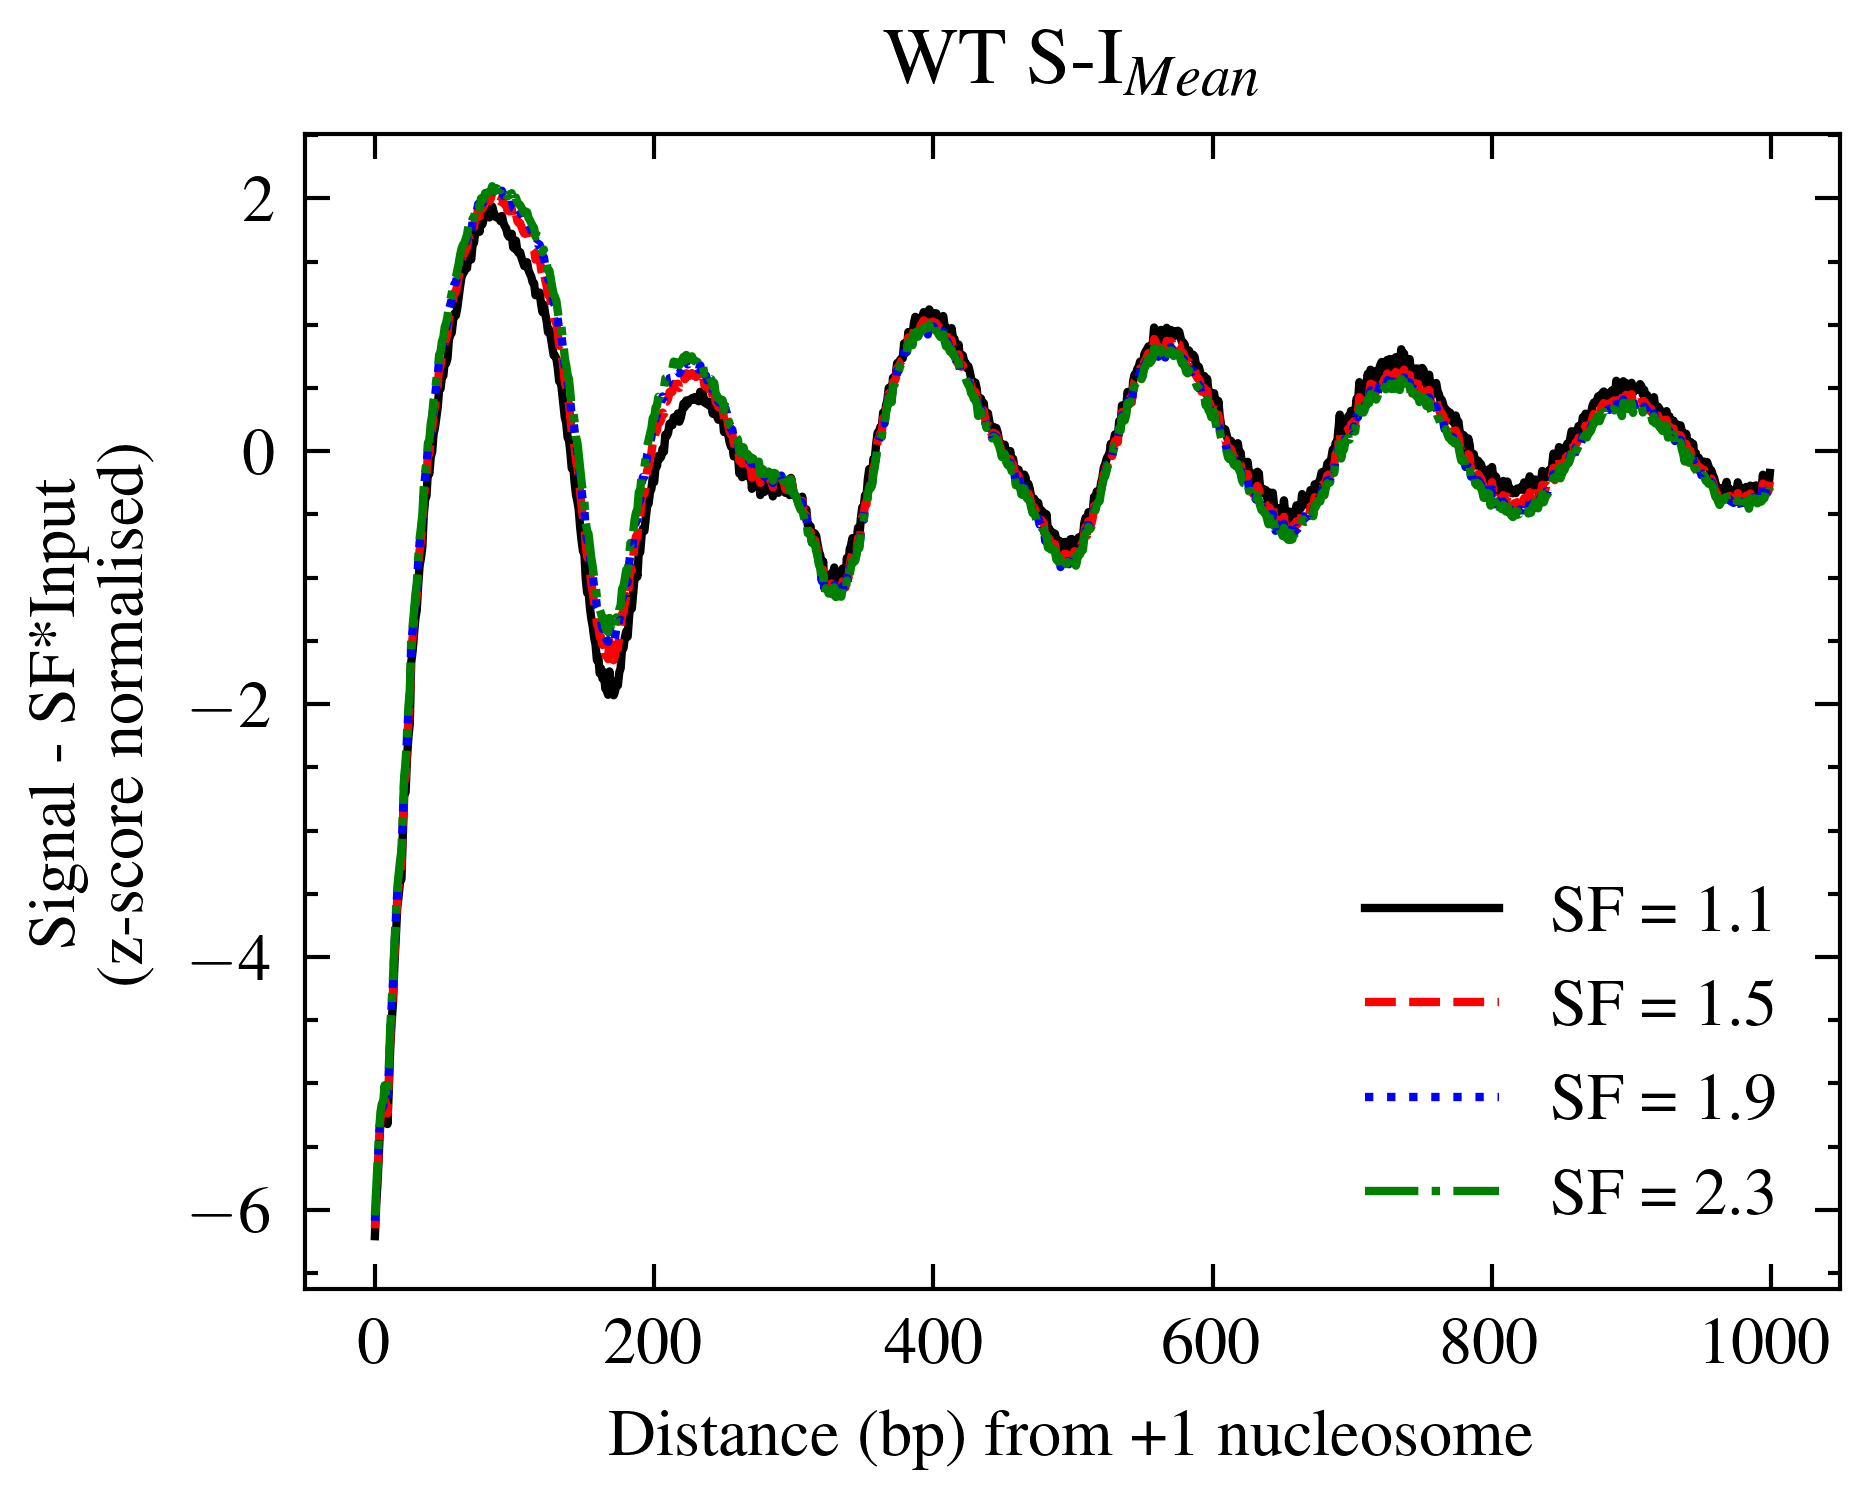

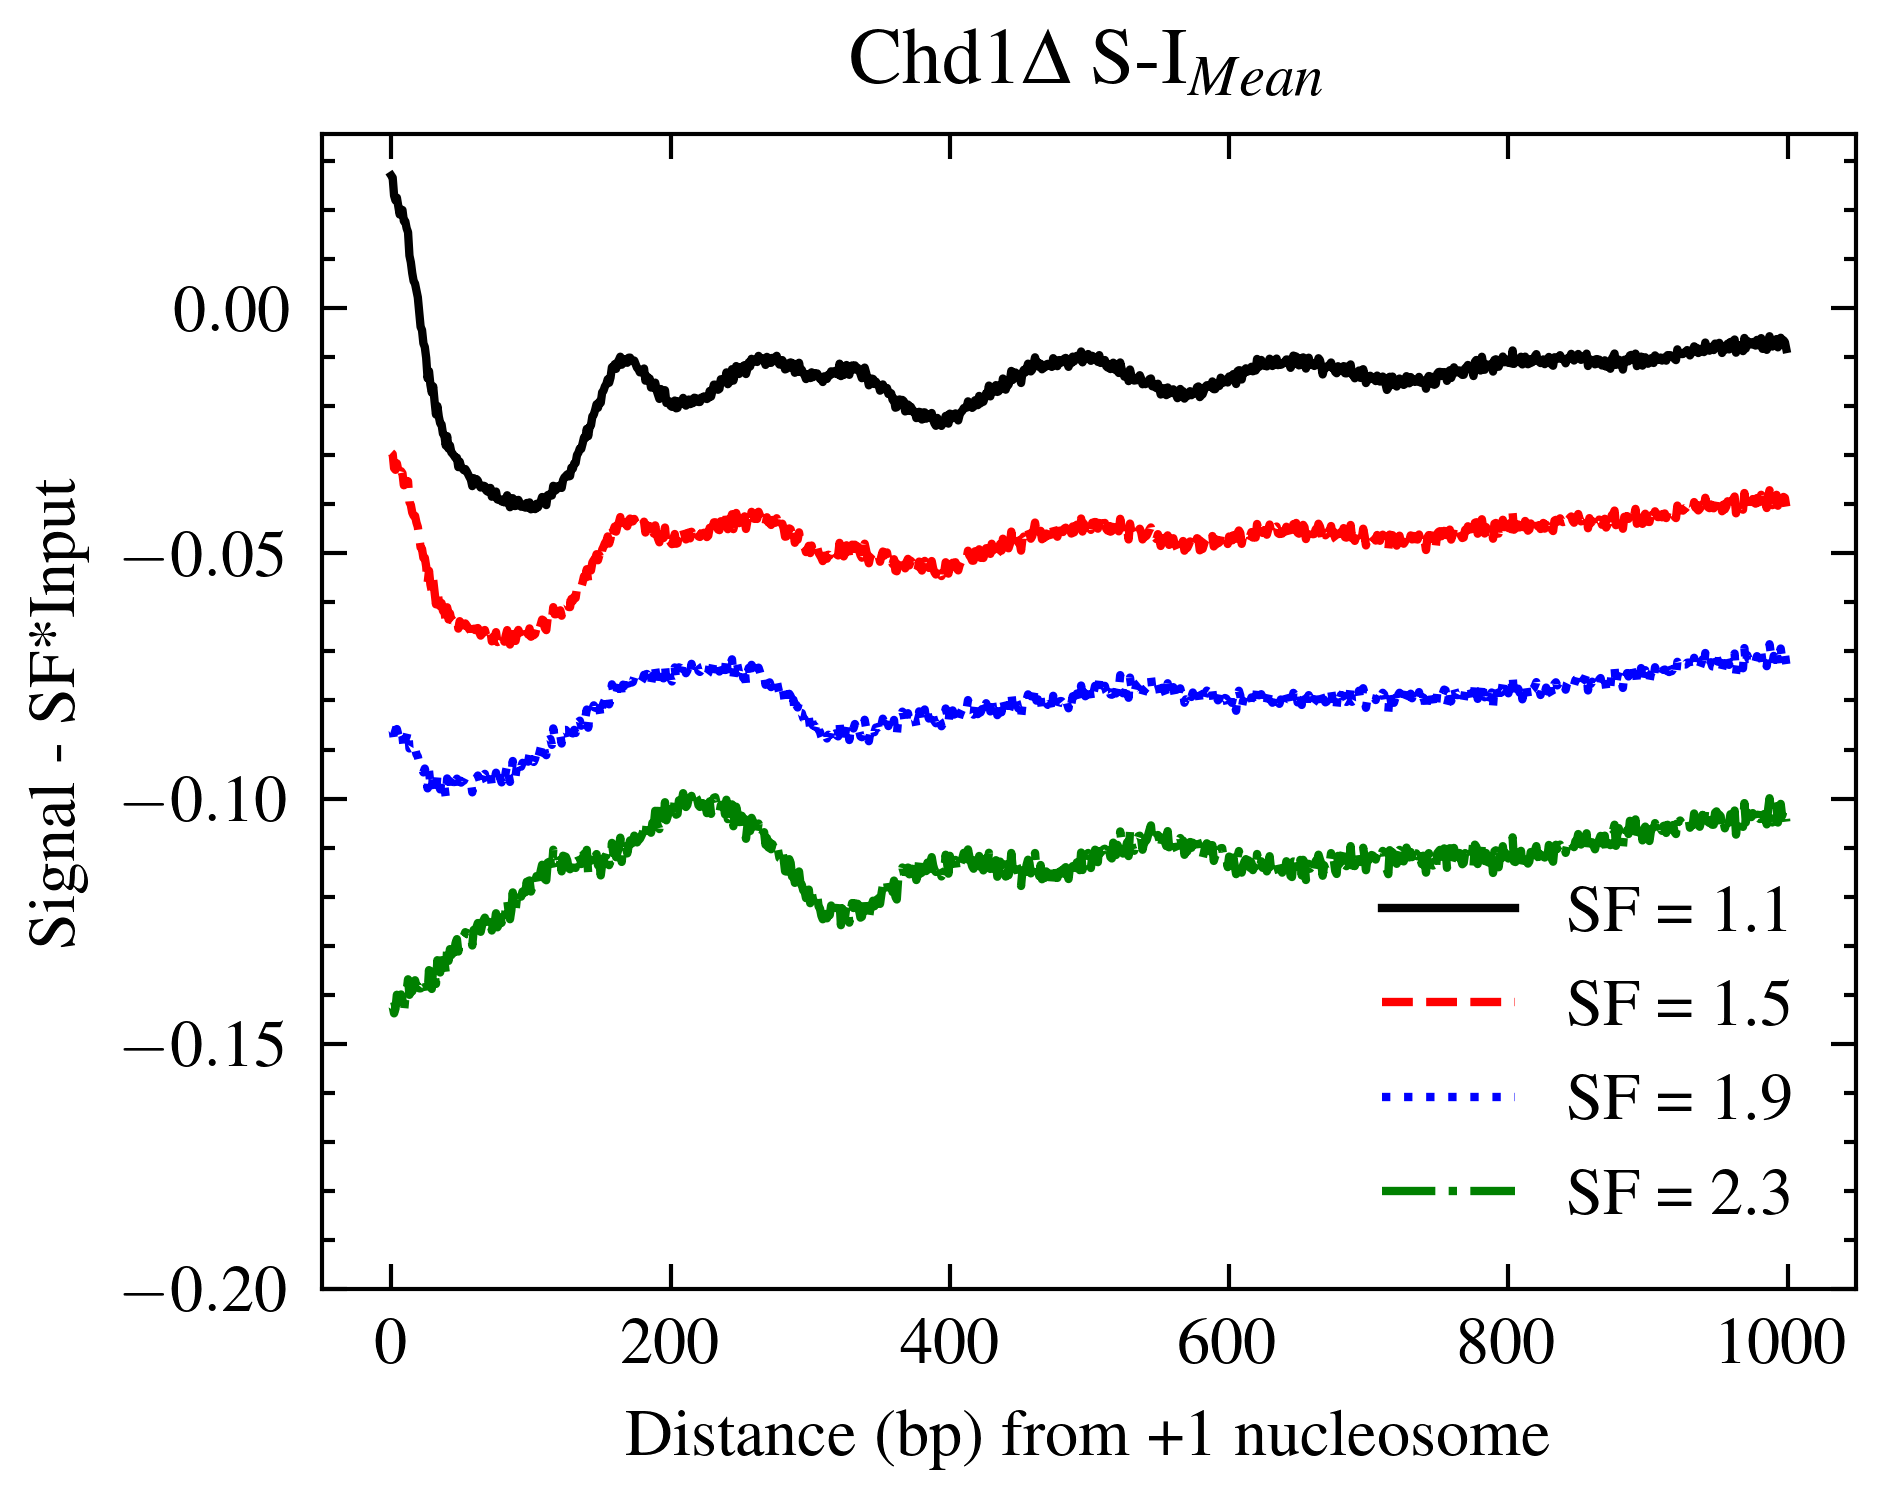

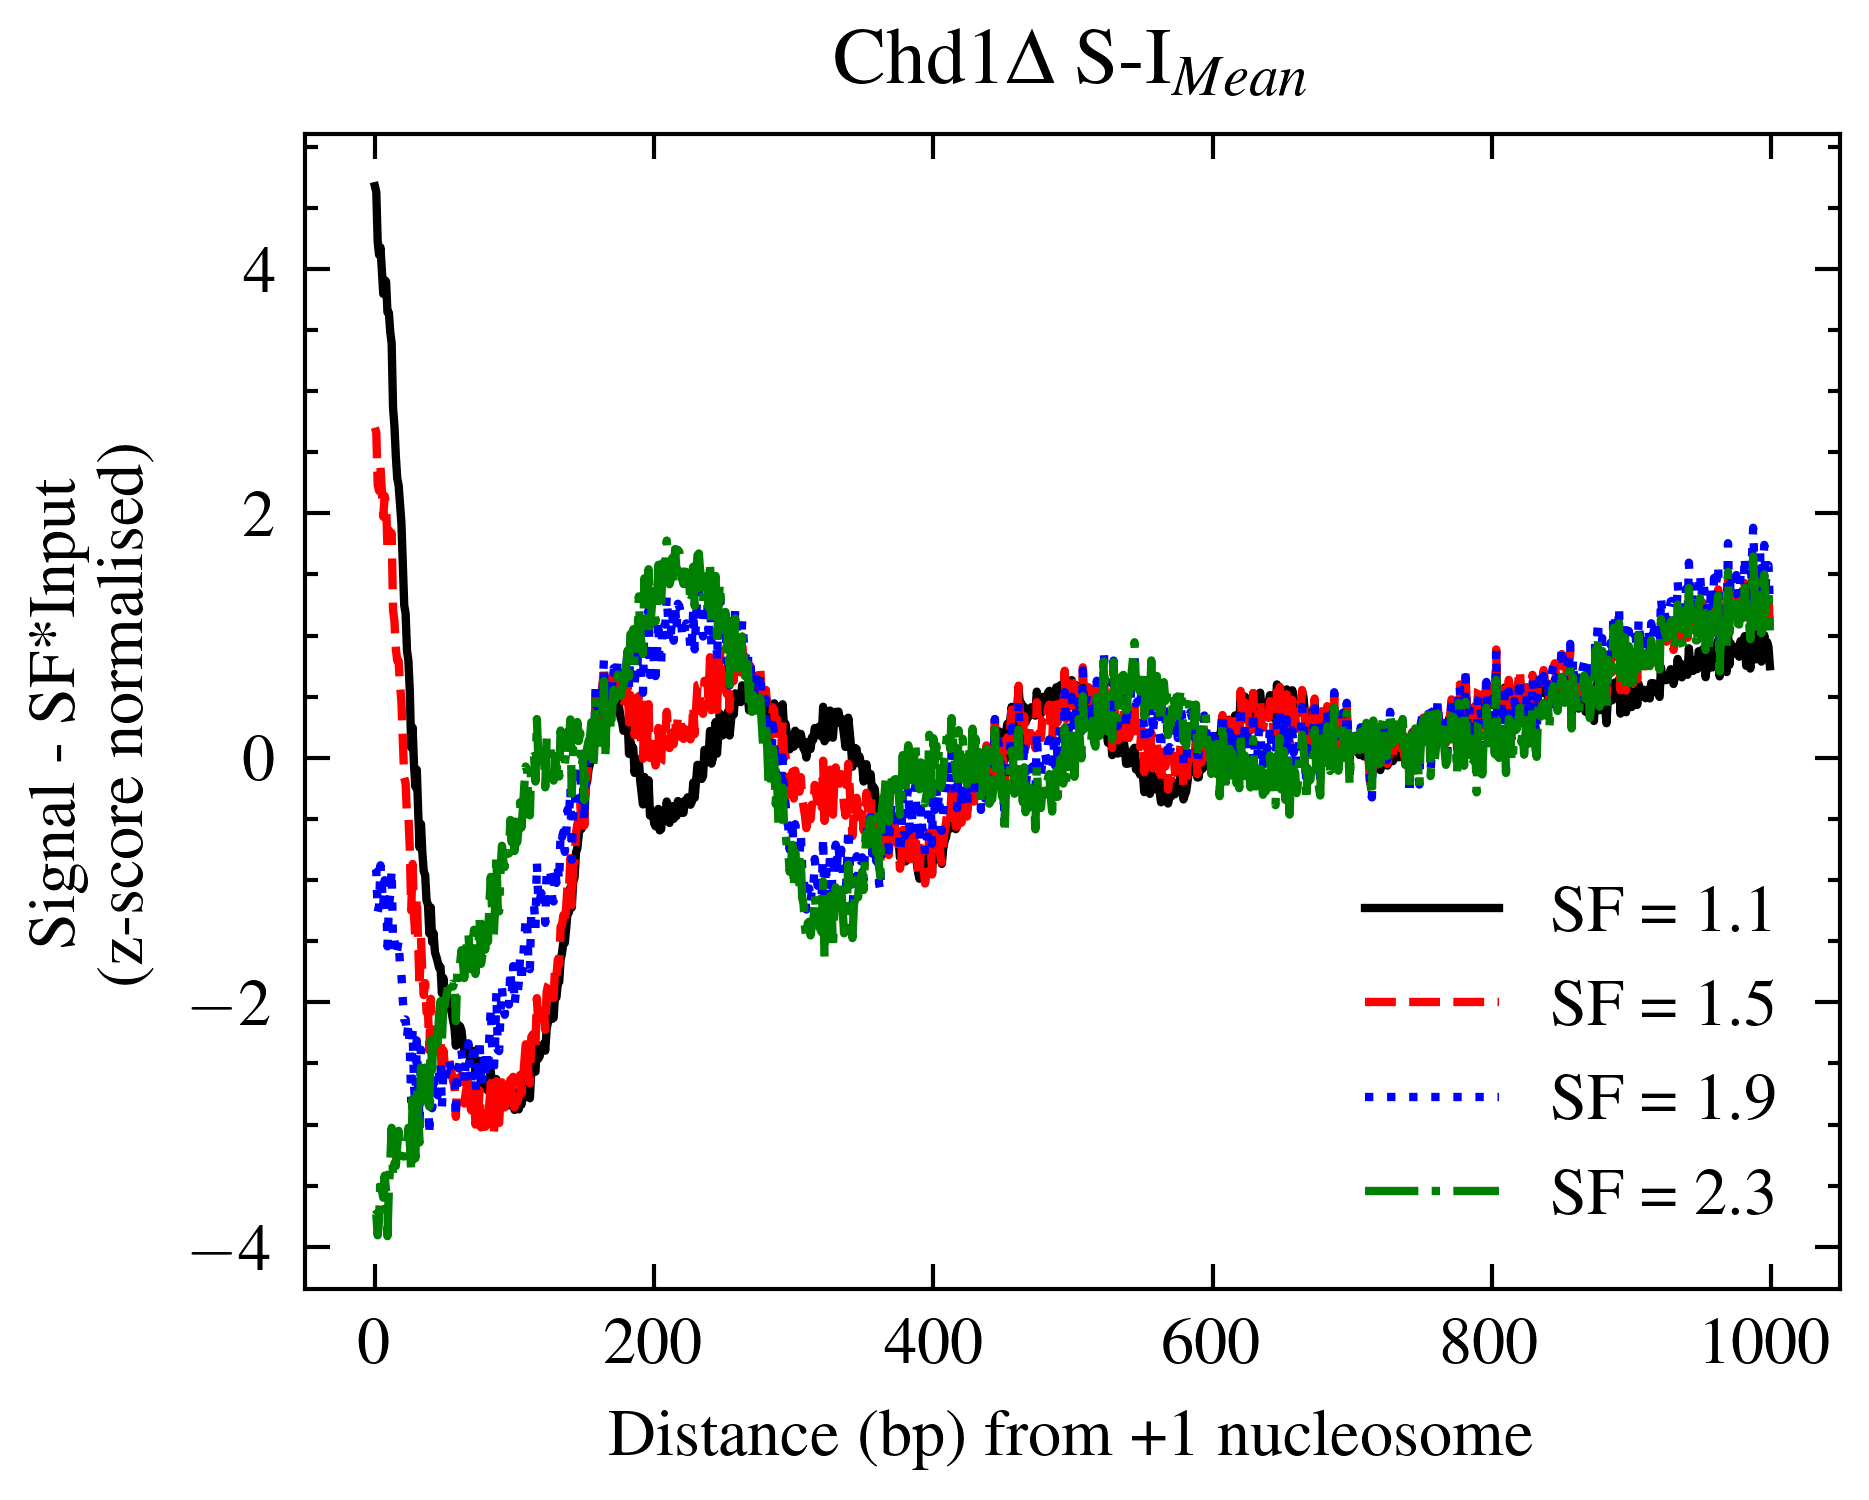

In [10]:
#Generates 4 full-scale plots for the mean WT and Chd1 S-I (standardised vs mean-normalised)

with plt.style.context(['science','ieee']):

    fig,ax = plt.subplots()
    for i in range(1,17,4): #plot results of different scaling factors (SF)
        tempMutant = WT_S.mean()-(1+i/10)*WT_input.mean()
        ax.plot(tempMutant,label= f"SF = {1+i/10}")

    plt.title('WT S-I$_{Mean}$')
    plt.ylabel('Signal - SF*Input')
    plt.xlabel('Distance (bp) from +1 nucleosome')
    plt.legend()
    plt.xticks(range(0,1001,200),minor=True)

    plt.show()

with plt.style.context(['science','ieee']):

    fig,ax = plt.subplots()
    for i in range(1,17,4):
        tempMutant = WT_S.mean()-(1+i/10)*WT_input.mean()
        ax.plot(znorm(tempMutant,axis=0),label= f"SF = {1+i/10}")

    plt.title('WT S-I$_{Mean}$')
    plt.ylabel('Signal - SF*Input \n (z-score normalised)')
    plt.xlabel('Distance (bp) from +1 nucleosome')
    plt.legend()
    plt.xticks(range(0,1001,200),minor=True)

    plt.show()

with plt.style.context(['science','ieee']):

    fig,ax = plt.subplots()
    for i in range(1,17,4):
        tempMutant = mutant_S.mean()-(1+i/10)*mutant_input.mean()
        ax.plot(tempMutant,label= f"SF = {1+i/10}")

    plt.title('Chd1$\Delta$ S-I$_{Mean}$')
    plt.ylabel('Signal - SF*Input')
    plt.xlabel('Distance (bp) from +1 nucleosome')
    
    plt.legend()
    plt.xticks(range(0,1001,200),minor=True)
    plt.ylim(bottom=-0.2) #to make the legend visible

    plt.show()

with plt.style.context(['science','ieee']):

    fig,ax = plt.subplots()
    for i in range(1,17,4):
        tempMutant = mutant_S.mean()-(1+i/10)*mutant_input.mean()
        ax.plot(znorm(tempMutant,axis=0),label= f"SF = {1+i/10}")

    plt.title('Chd1$\Delta$ S-I$_{Mean}$')
    plt.ylabel('Signal - SF*Input \n (z-score normalised)')
    plt.xlabel('Distance (bp) from +1 nucleosome')
    
    plt.legend()
    plt.xticks(range(0,1001,200),minor=True)

    plt.show()


### Fig 5. Scree plots

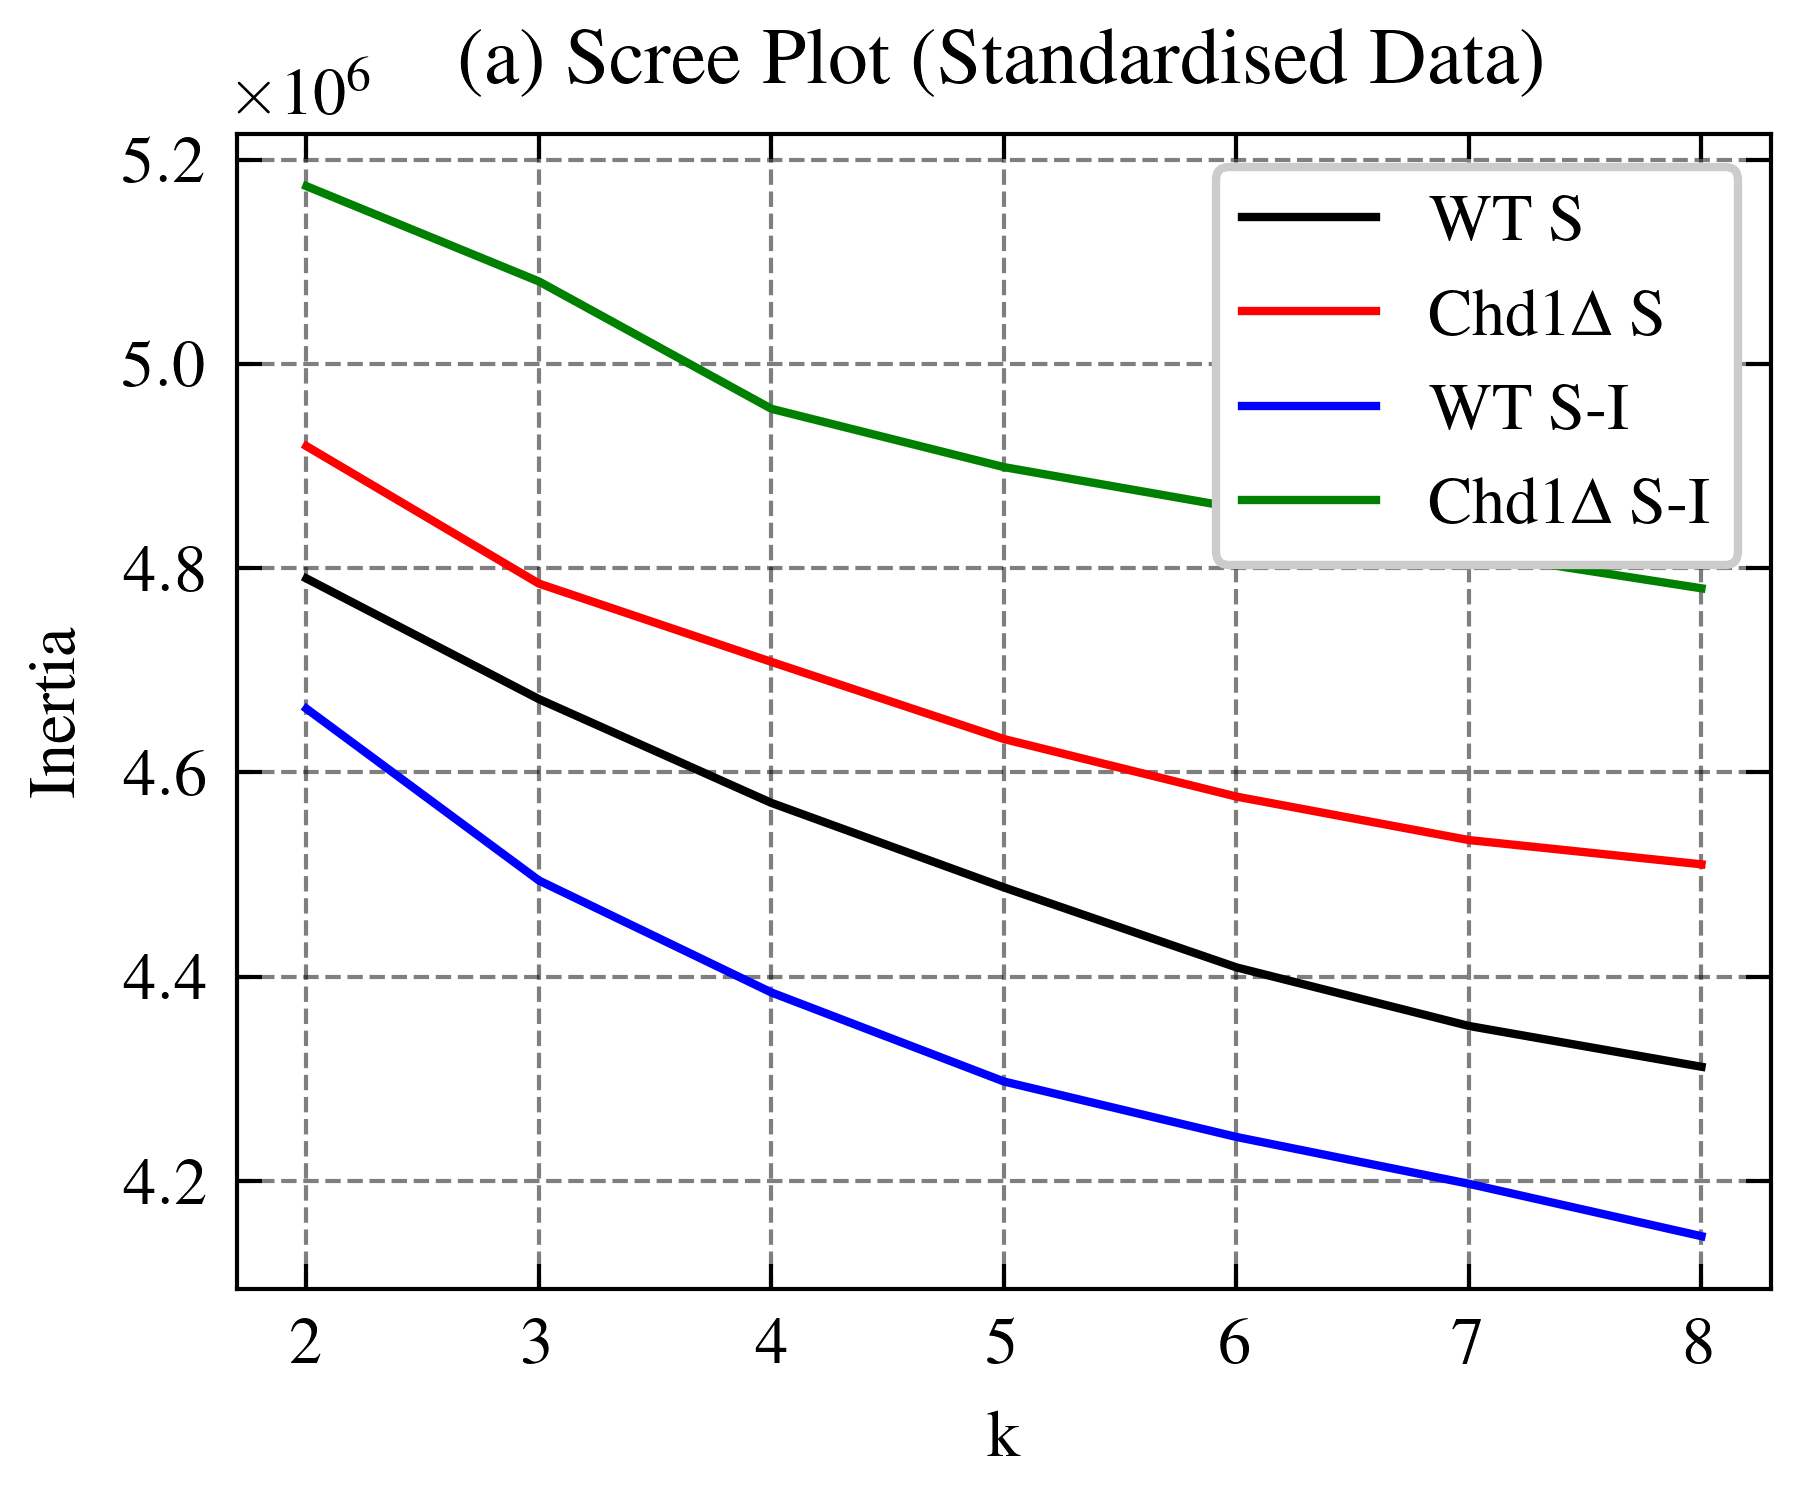

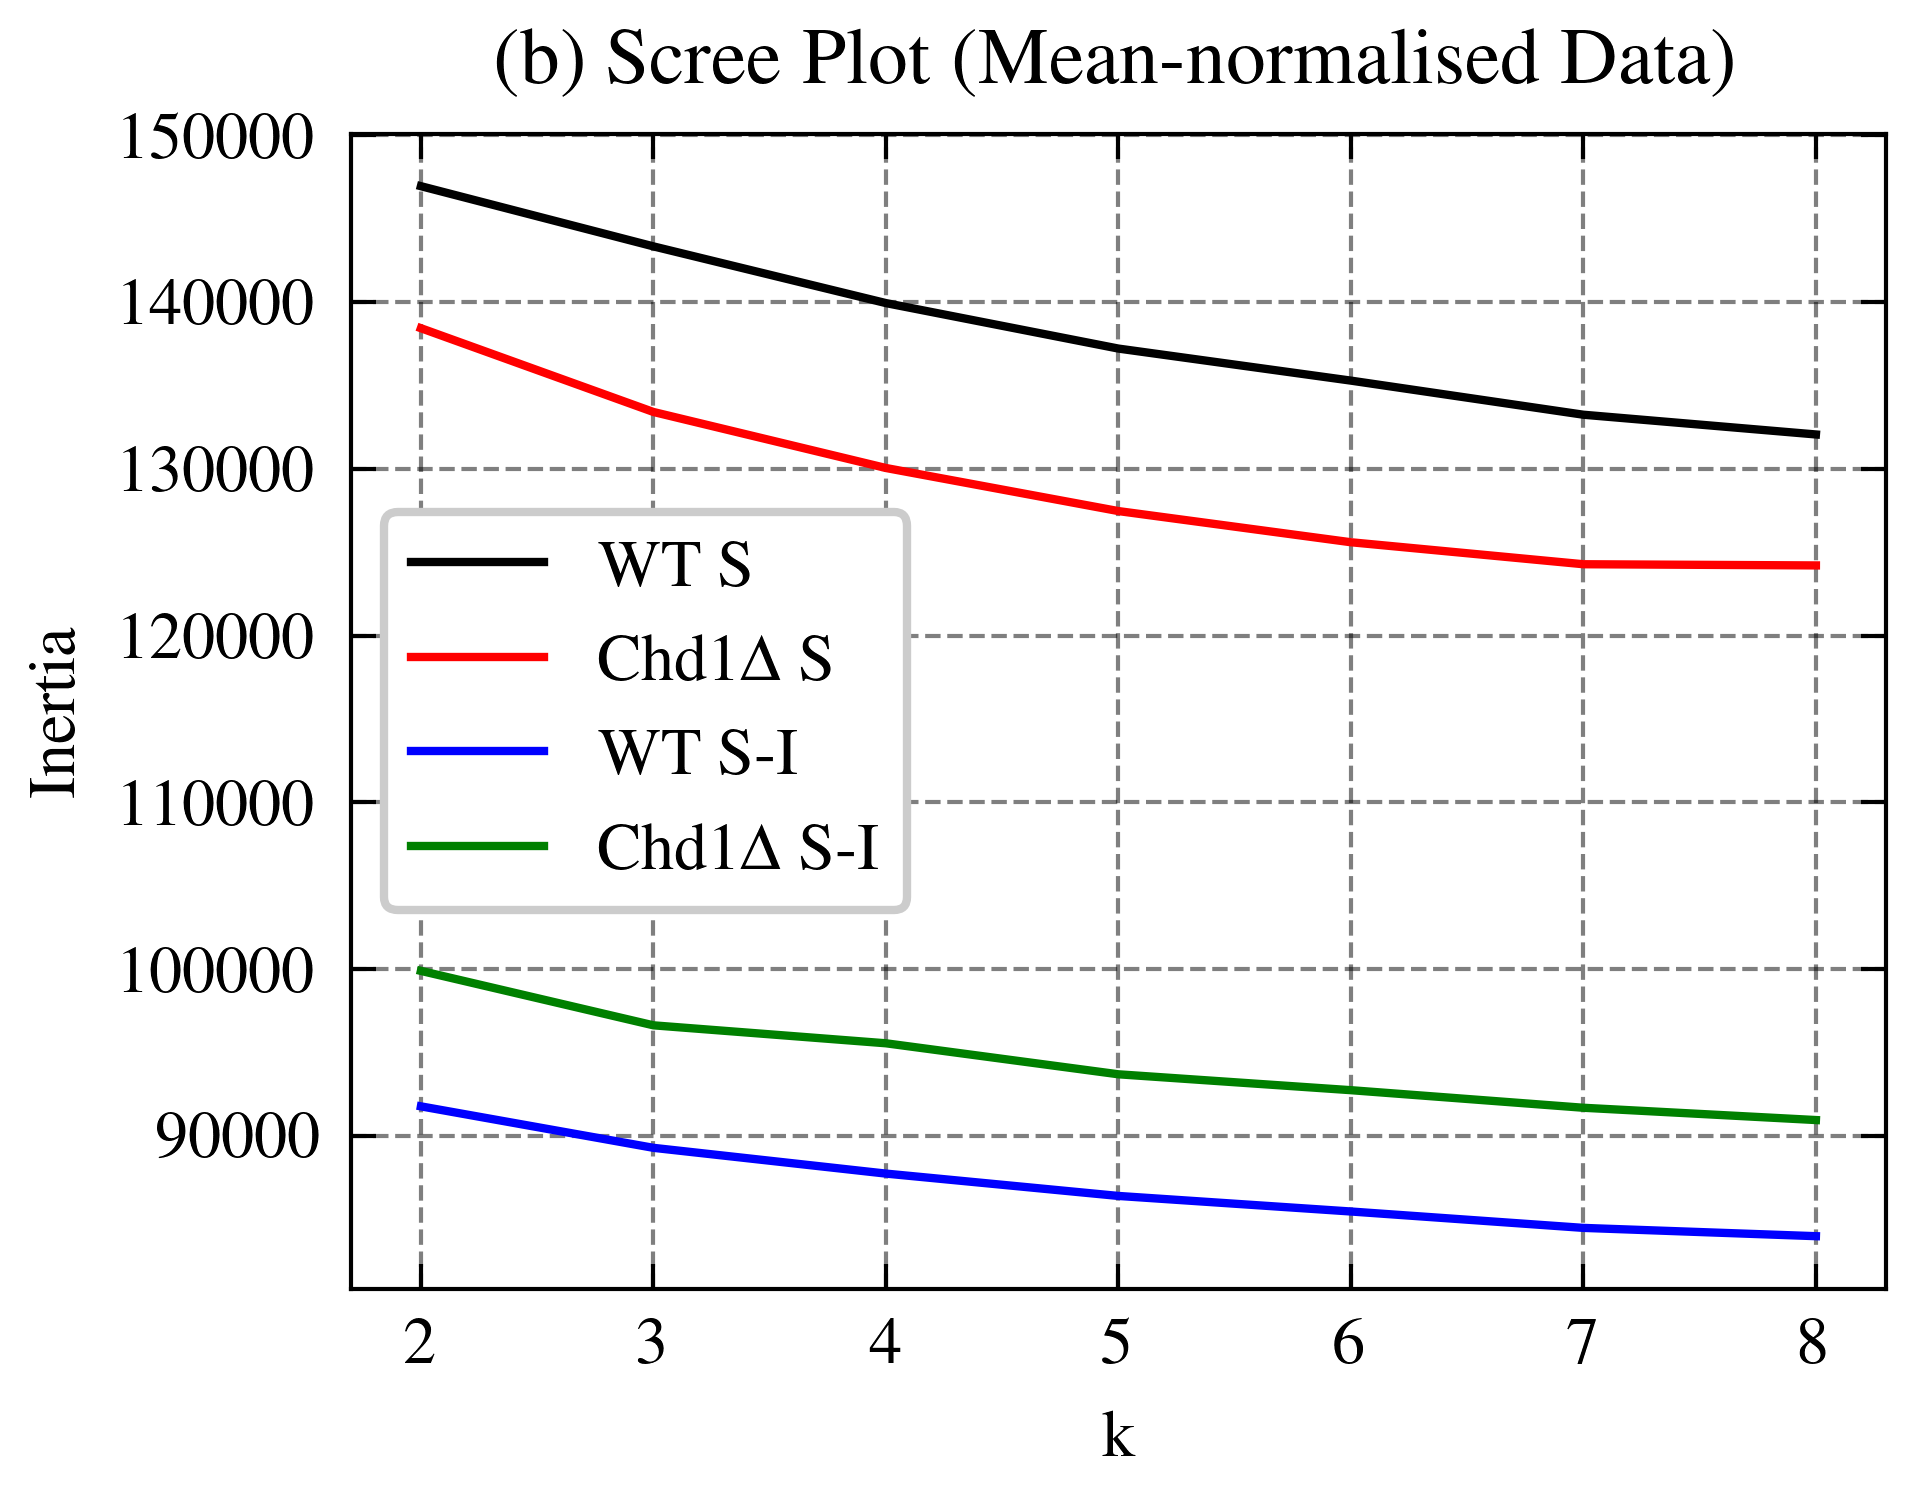

In [11]:

datasets = [WT_S_znorm, WT_SI_znorm,  mutant_S_znorm,mutant_SI_znorm]
inertias_ =[find_K_clusters(max_k,i)[2] for i in datasets]
dataset_labels = ["WT S", "Chd1$\Delta$ S", "WT S-I","Chd1$\Delta$ S-I"]

styles = ['-','-','-','-']

with plt.style.context(['science','ieee','grid']):

    fig,ax = plt.subplots()
    
    for i in inertias_:
        idx = inertias_.index(i)
        plt.plot(range(2,2+len(i)),i,styles[idx],label = dataset_labels[idx])
        plt.title('(a) Scree Plot (Standardised Data)')
        plt.ylabel('Inertia')
        #plt.xticks(range(2,ks+1,1),minor=False)
        plt.minorticks_off()
        plt.xlabel('k')
        plt.legend()
        

    plt.show()



datasets = [WT_S_meannorm, mutant_S_meannorm, WT_SI_meannorm, mutant_SI_meannorm]
inertias_ =[find_K_clusters(max_k,i)[2] for i in datasets]
dataset_labels = ["WT S", "Chd1$\Delta$ S", "WT S-I","Chd1$\Delta$ S-I"]

styles = ['-','-','-','-']

with plt.style.context(['science','ieee','grid']):

    fig,ax = plt.subplots()
    
    for i in inertias_:
        idx = inertias_.index(i)
        plt.plot(range(2,2+len(i)),i,styles[idx],label = dataset_labels[idx])
        plt.title('(b) Scree Plot (Mean-normalised Data)')
        plt.ylabel('Inertia')
        #plt.xticks(range(2,ks+1,1),minor=False)
        plt.minorticks_off()
        plt.xlabel('k')
        plt.legend()
        

    plt.show()


### Fig 6. Silhouette Plots

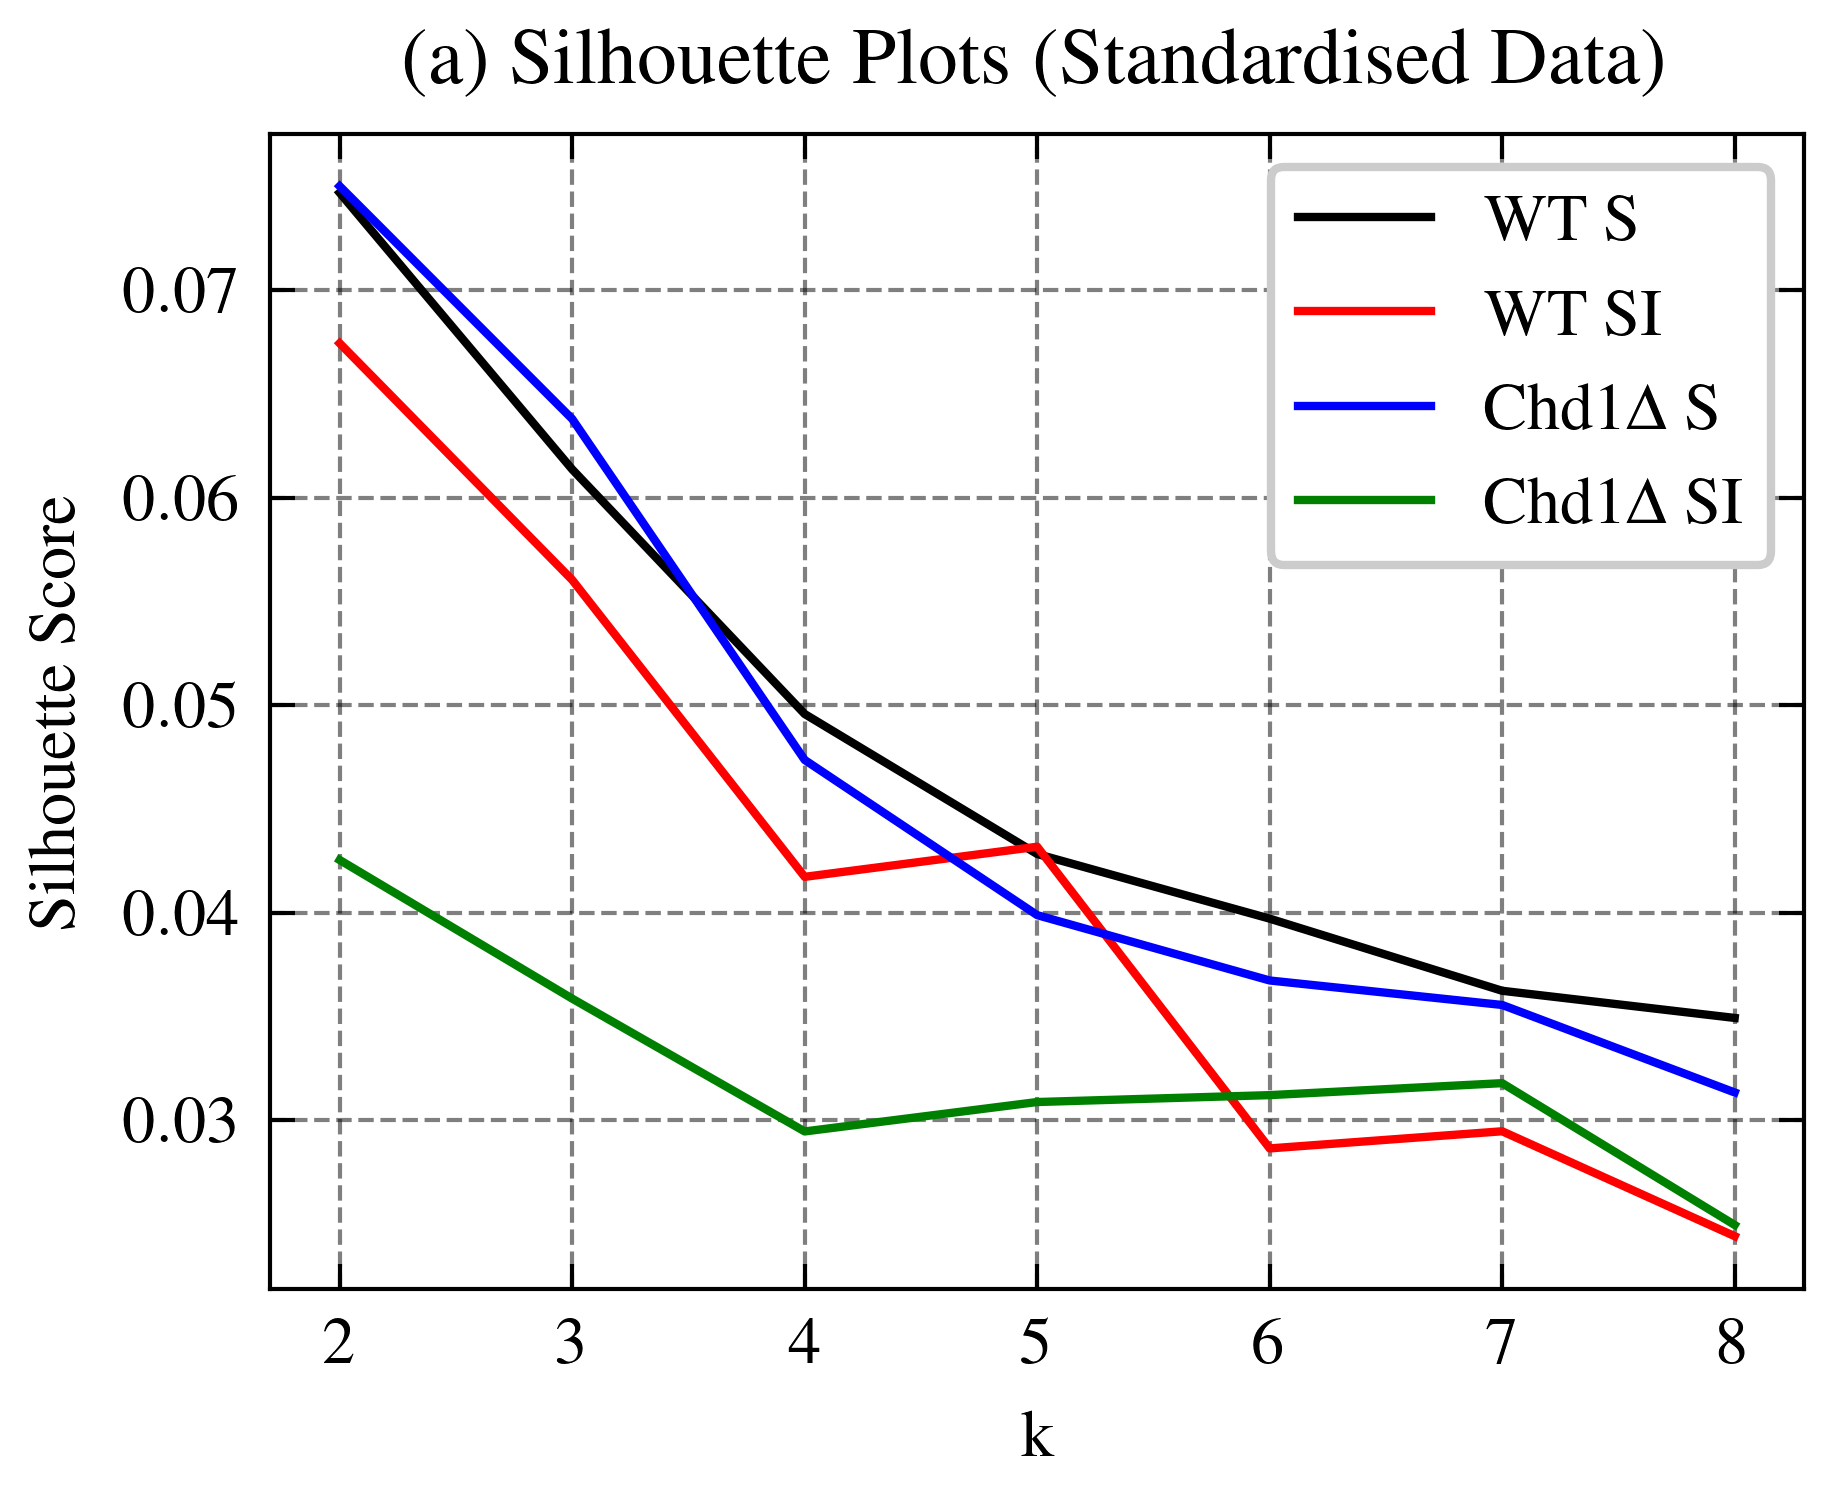

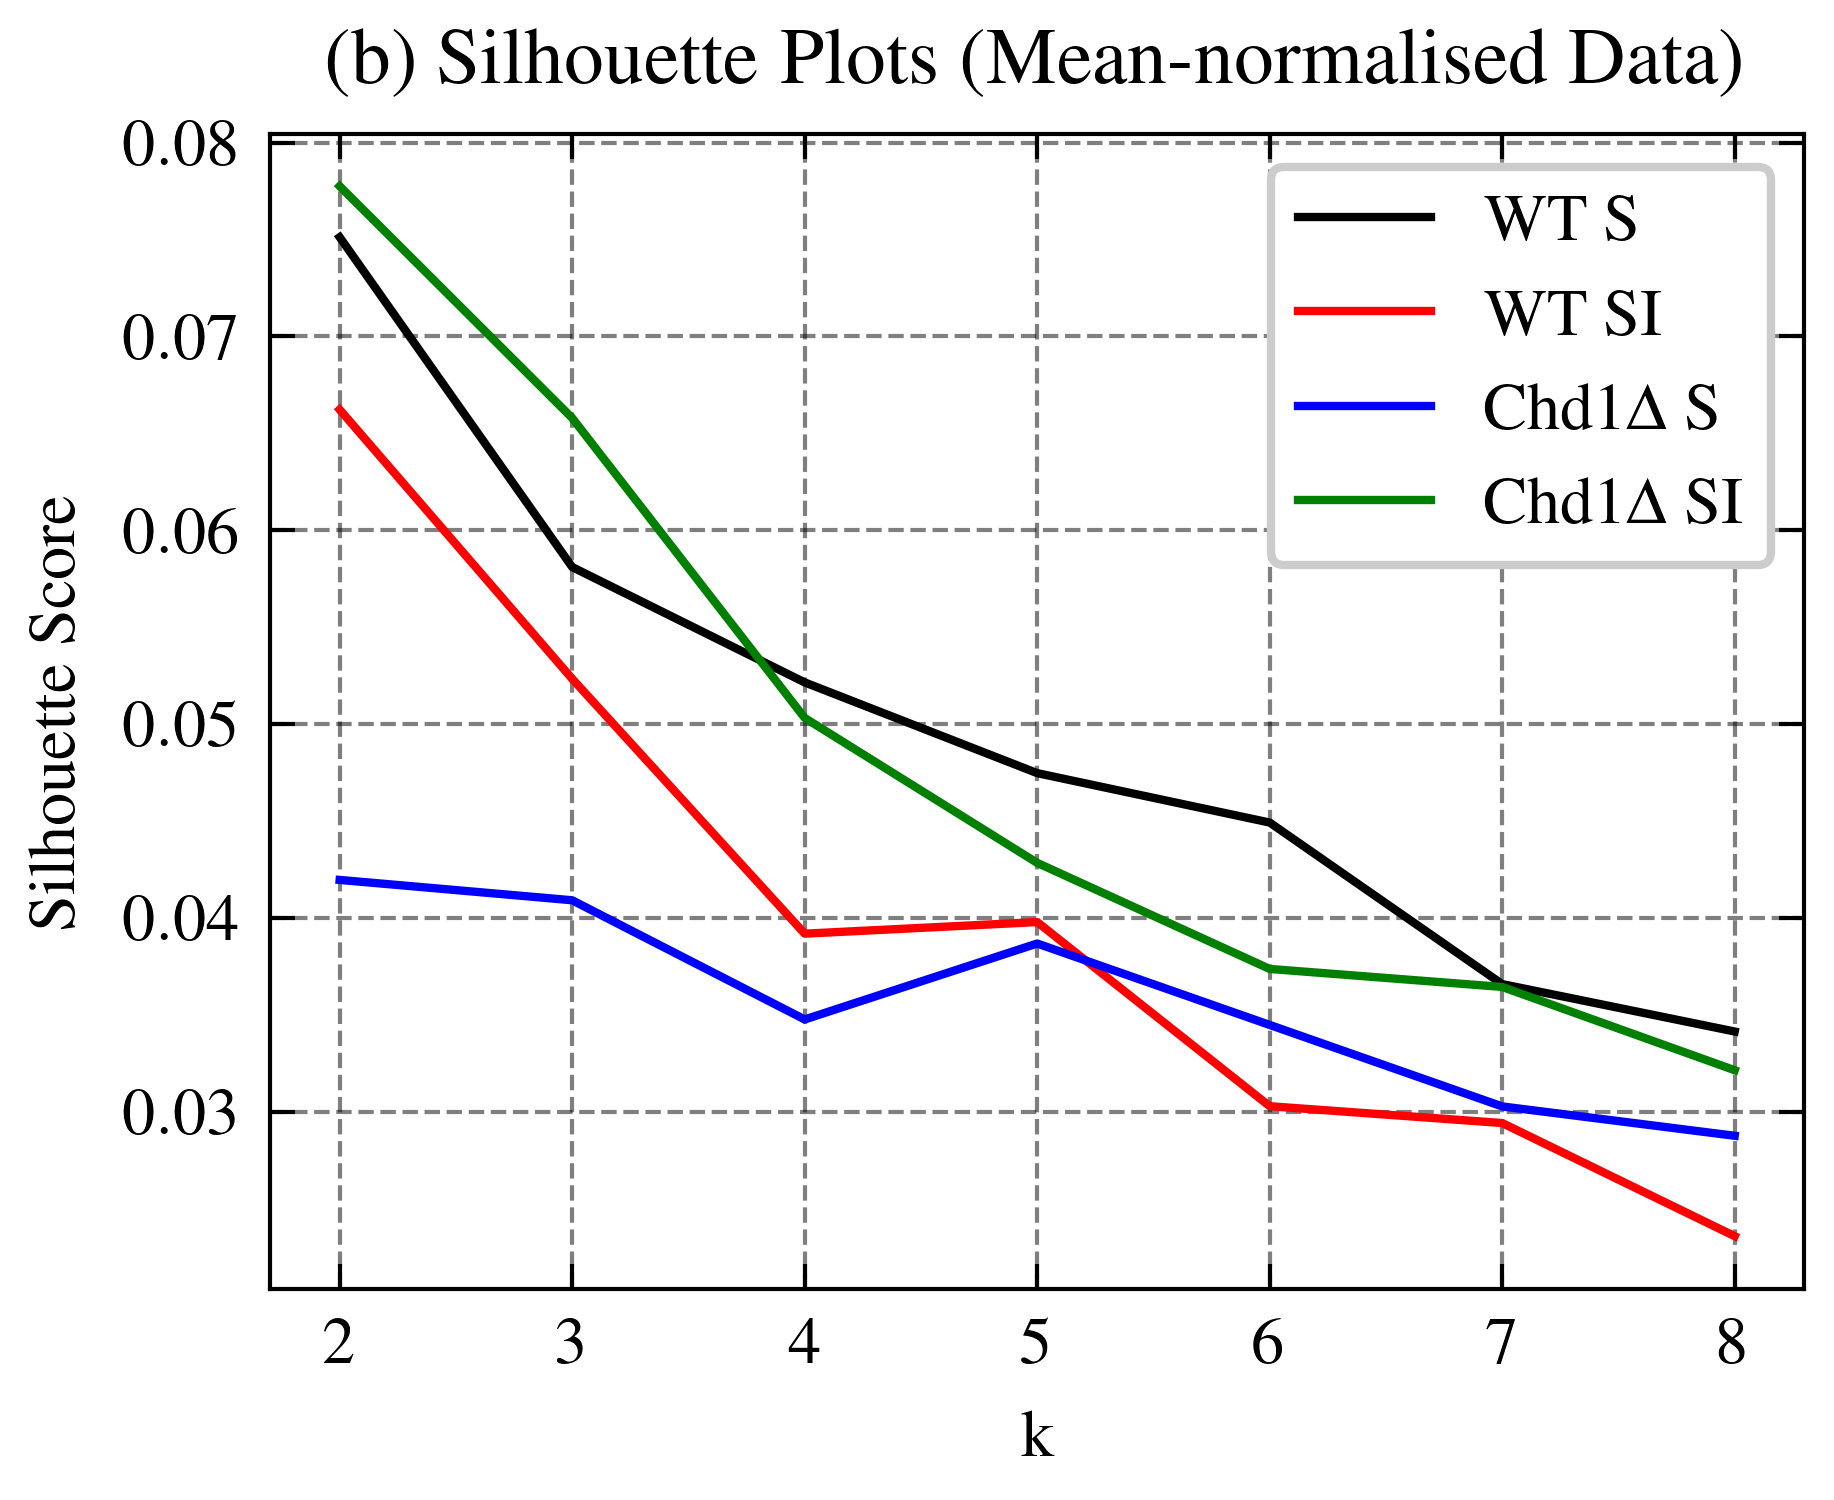

In [12]:
datasets = ["WT_S_znorm","WT_SI_znorm","mutant_S_znorm","mutant_SI_znorm"]
labels = ["WT S","WT SI","Chd1$\Delta$ S","Chd1$\Delta$ SI"] 
scores= SS_df[datasets].T.values

with plt.style.context(['science','ieee','grid']):

    fig,ax = plt.subplots()
    for i in range(len(scores)):
        plt.plot(range(2,2+len(scores[i])),scores[i],'-',label = labels[i])
        plt.title('(a) Silhouette Plots (Standardised Data)')
        plt.ylabel('Silhouette Score')
        #plt.xticks(range(2,ks+1,1),minor=False)
        plt.minorticks_off()
        plt.xlabel('k')
        plt.legend()
        
    plt.show()


datasets = ["WT_S_meannorm","WT_SI_meannorm","mutant_SI_meannorm","mutant_S_meannorm"]
labels = ["WT S","WT SI","Chd1$\Delta$ S","Chd1$\Delta$ SI"] 
scores= SS_df[datasets].T.values

with plt.style.context(['science','ieee','grid']):

    fig,ax = plt.subplots()
    for i in range(len(scores)):
        plt.plot(range(2,2+len(scores[i])),scores[i],'-',label = labels[i])
        plt.title('(b) Silhouette Plots (Mean-normalised Data)')
        plt.ylabel('Silhouette Score')
        #plt.xticks(range(2,ks+1,1),minor=False)
        plt.minorticks_off()
        plt.xlabel('k')
        plt.legend()
        

    plt.show()

### Fig 7. WT and Chd1∆ Clusters

In [13]:
# find_K-clusters returns (cluster, label, inertia).
# [0] selects clusters and [-1] selects the clusters for the latest run, i.e. k=3
WT_S_znorm_clusters = find_K_clusters(3,WT_S_znorm)[0][-1]
WT_S_meannorm_clusters = find_K_clusters(3,WT_S_znorm)[0][-1]
WT_SI_znorm_clusters = find_K_clusters(3,WT_SI_znorm)[0][-1]
WT_SI_meannorm_clusters = find_K_clusters(3, WT_SI_meannorm)[0][-1]

mutant_S_znorm_clusters = find_K_clusters(3,mutant_S_znorm)[0][-1]
mutant_S_meannorm_clusters = find_K_clusters(3,mutant_S_znorm)[0][-1]
mutant_SI_znorm_clusters = find_K_clusters(3,mutant_SI_znorm)[0][-1]
mutant_SI_meannorm_clusters = find_K_clusters(3, mutant_SI_meannorm)[0][-1]

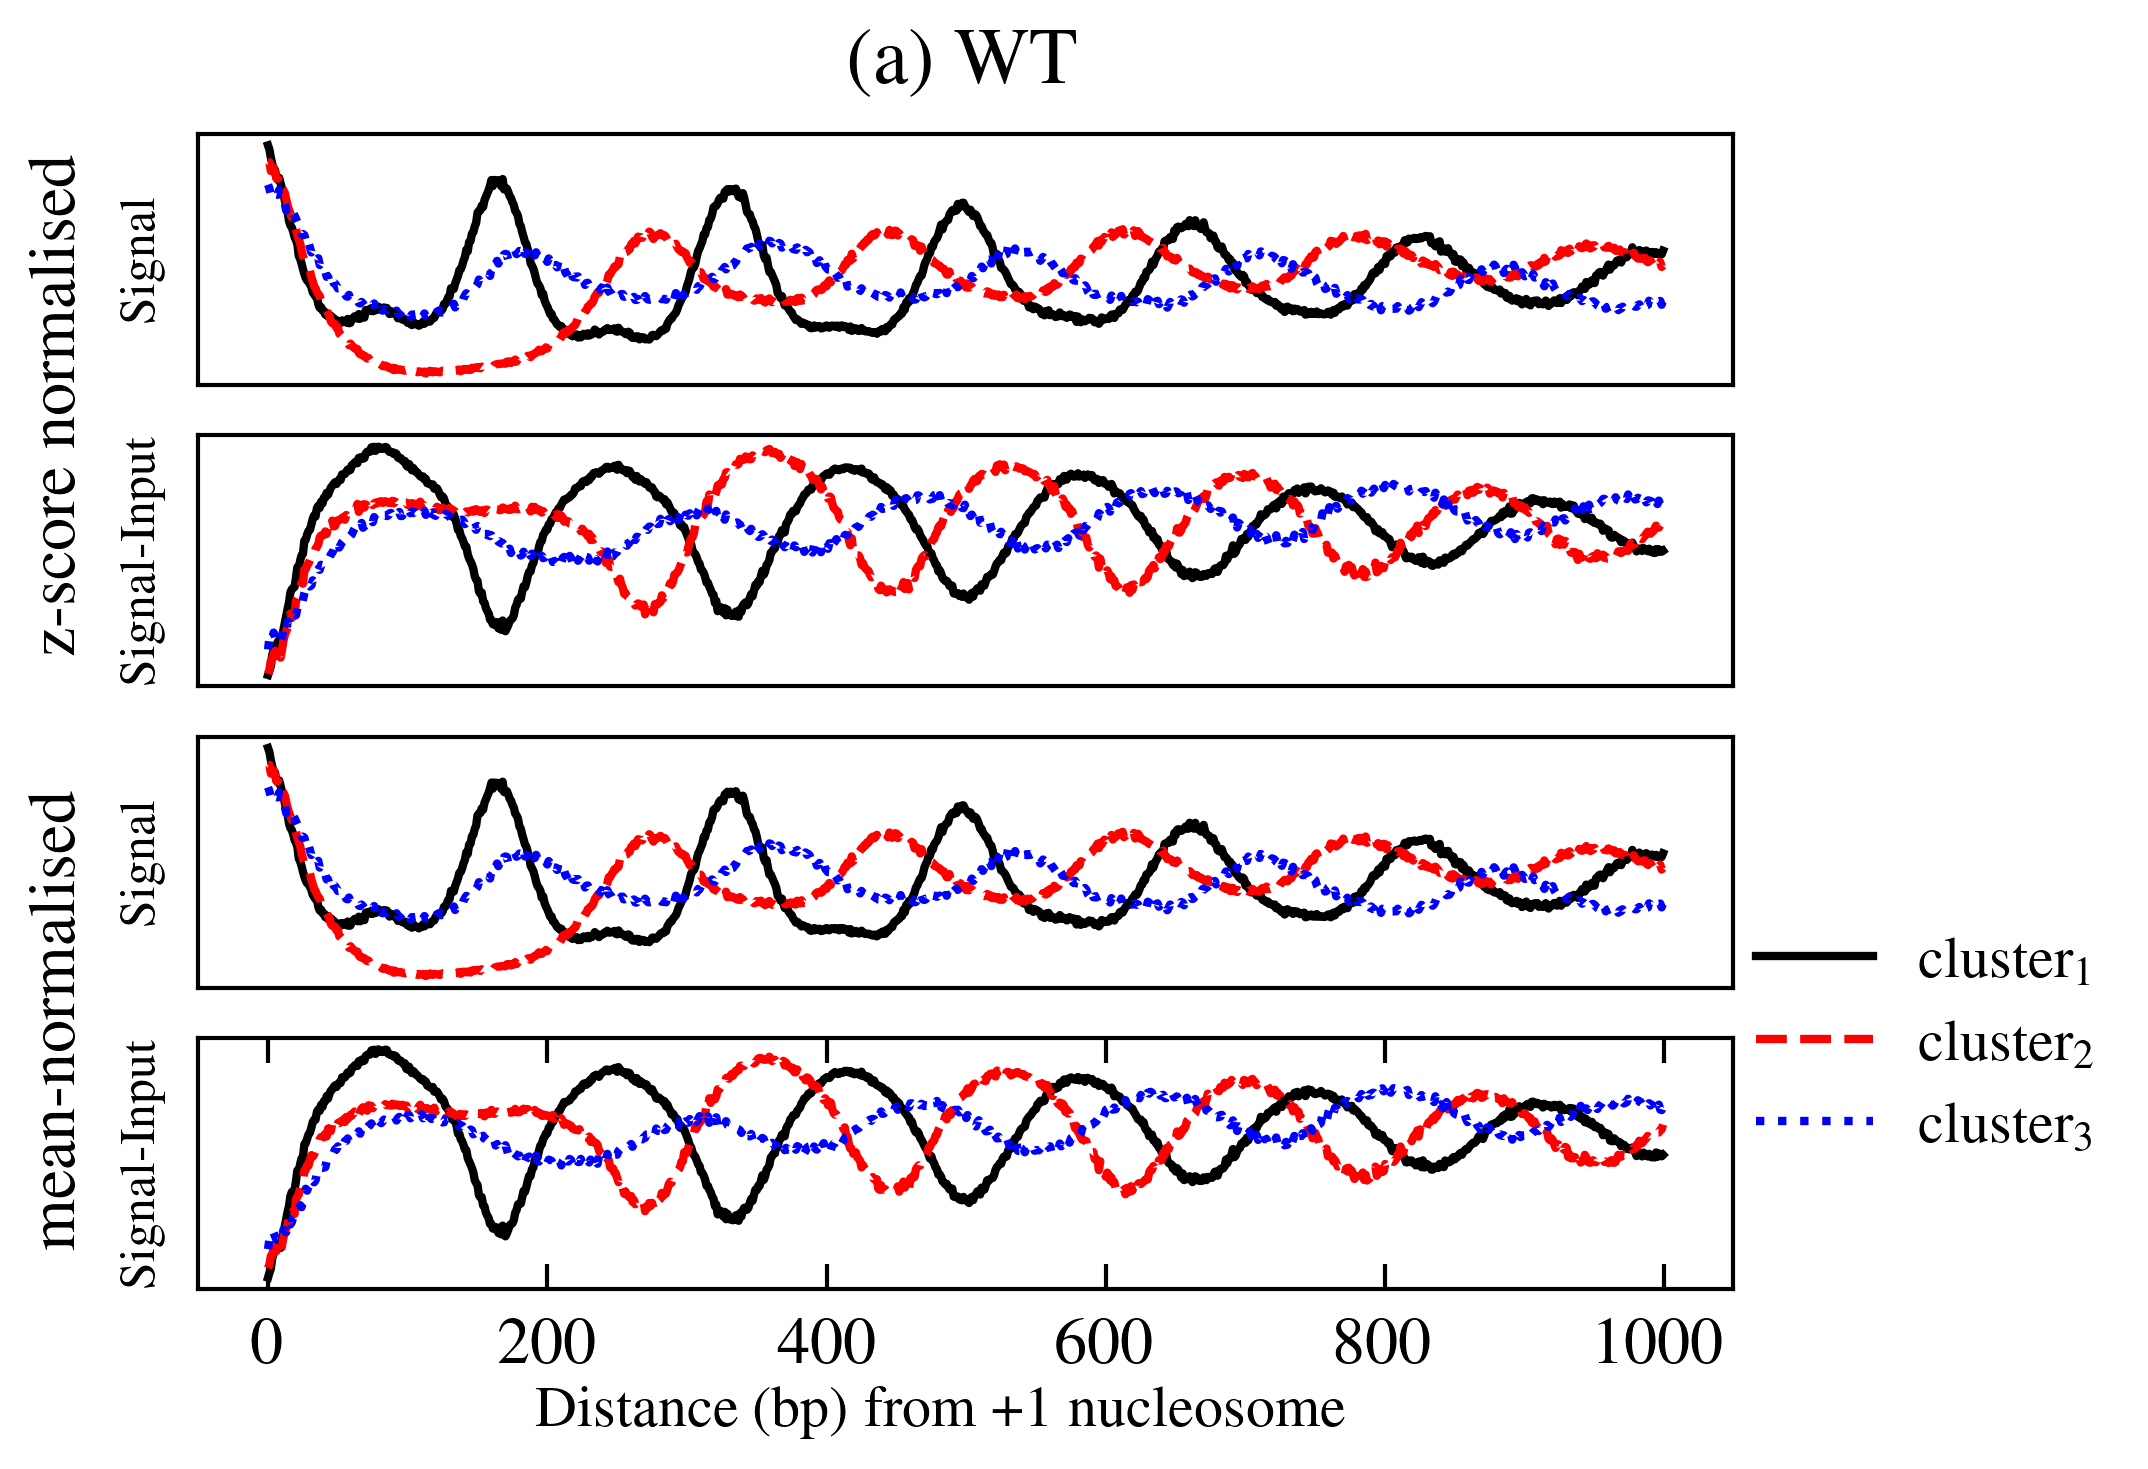

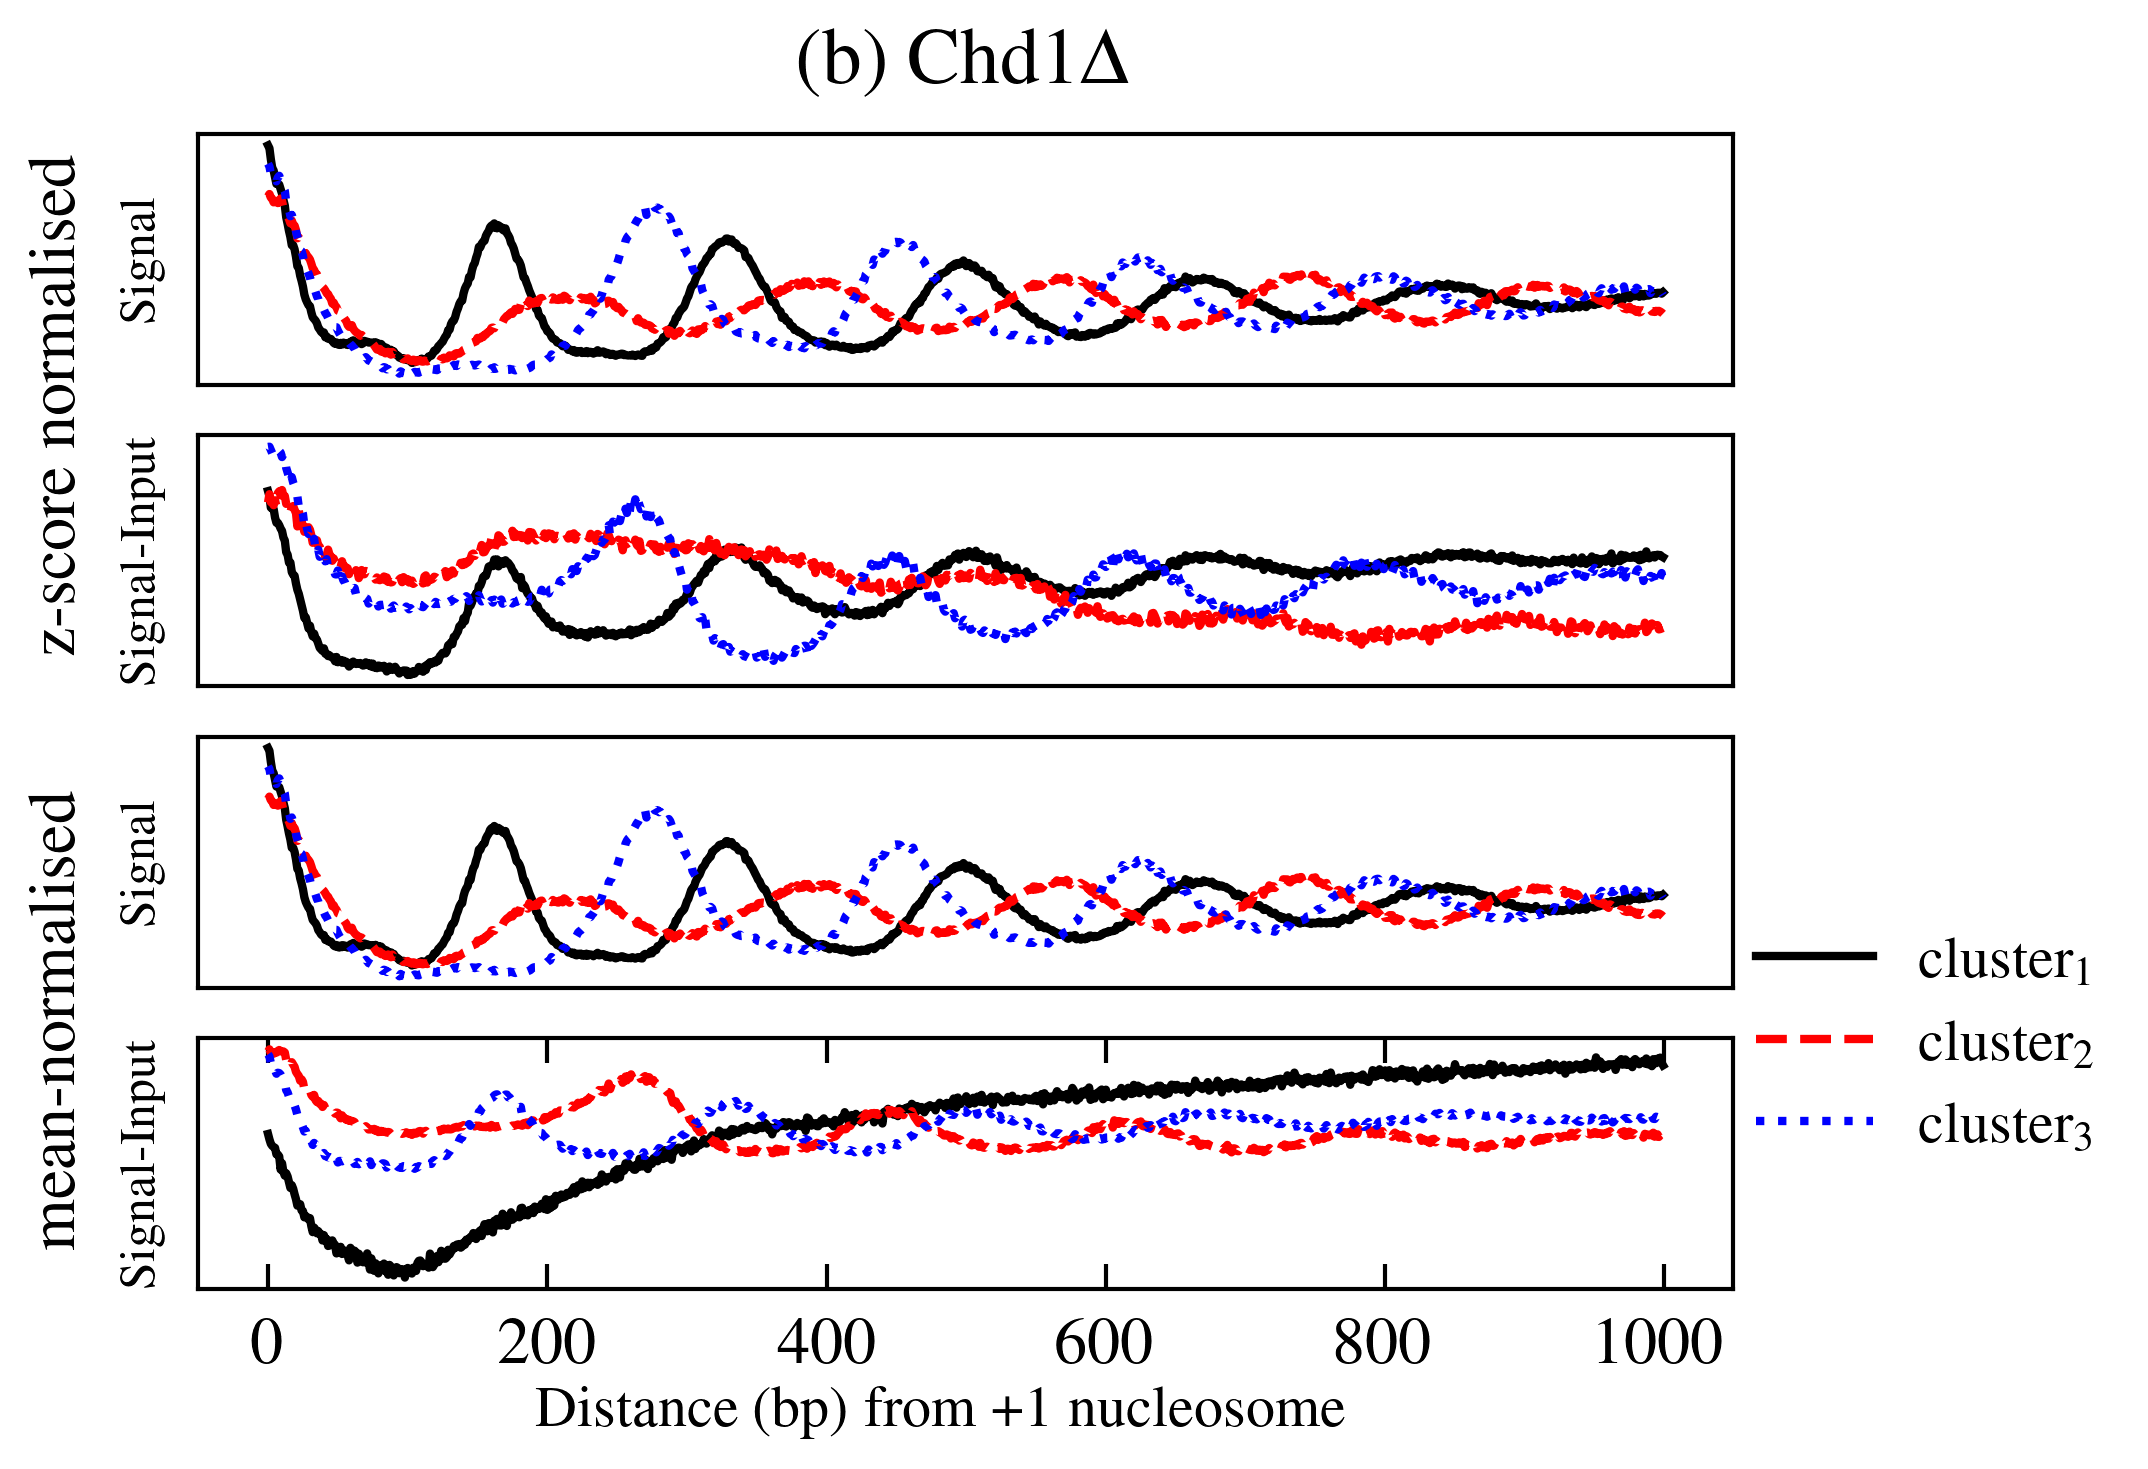

In [14]:
with plt.style.context(['science','ieee']):

    fig = plt.figure()
    gs = fig.add_gridspec(4,1) #to reduce width-space
    (ax1,ax2,ax3,ax4) = gs.subplots()

    for i in range(3):
        
        ax1.plot(WT_S_znorm_clusters[i].mean(), label = f"cluster$_{i}$ n = {len(WT_S_znorm_clusters[i])}")
        ax2.plot(WT_SI_znorm_clusters[i].mean(), label = f"cluster$_{i}$ n = {len(WT_SI_znorm_clusters[i])}")
        ax3.plot(WT_S_meannorm_clusters[i].mean(), label = f"cluster$_{i}$ n = {len(WT_S_meannorm_clusters[i])}")
        ax4.plot(WT_SI_meannorm_clusters[i].mean(), label = f"cluster$_{i+1}$")  
    
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax3.set_xticks([])

    ax1.set_yticks([])
    ax2.set_yticks([])
    ax3.set_yticks([])
    ax4.set_yticks([])

    fig.text(0.04, 0.29, 'mean-normalised', va='center', rotation='vertical')
    fig.text(0.04, 0.7, 'z-score normalised', va='center', rotation='vertical')
    
    ax1.set_title('(a) WT')
    ax1.set_ylabel('Signal',fontsize=6)
    ax2.set_ylabel('Signal-Input',fontsize=6)
    ax3.set_ylabel('Signal',fontsize=6)
    ax4.set_ylabel('Signal-Input',fontsize=6)
    fig.supxlabel('Distance (bp) from +1 nucleosome',fontsize=7)
    ax4.legend(bbox_to_anchor=(1, 1.5),loc='upper left', borderaxespad=0.,fontsize=7)
   
    plt.xticks(range(0,1001,200),minor = True) #boolean causes many x values to disappear

    plt.show()


with plt.style.context(['science','ieee']):

    fig = plt.figure()
    gs = fig.add_gridspec(4,1) #to reduce width-space
    (ax1,ax2,ax3,ax4) = gs.subplots()

    for i in range(3):
        
        ax1.plot(mutant_S_znorm_clusters[i].mean(), label = f"cluster$_{i}$ n = {len(WT_S_znorm_clusters[i])}")
        ax2.plot(mutant_SI_znorm_clusters[i].mean(), label = f"cluster$_{i}$ n = {len(WT_SI_znorm_clusters[i])}")
        ax3.plot(mutant_S_meannorm_clusters[i].mean(), label = f"cluster$_{i}$ n = {len(WT_S_meannorm_clusters[i])}")
        ax4.plot(mutant_SI_meannorm_clusters[i].mean(), label = f"cluster$_{i+1}$")  
    
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax3.set_xticks([])

    ax1.set_yticks([])
    ax2.set_yticks([])
    ax3.set_yticks([])
    ax4.set_yticks([])


    fig.text(0.04, 0.29, 'mean-normalised', va='center', rotation='vertical')
    fig.text(0.04, 0.7, 'z-score normalised', va='center', rotation='vertical')
    
    ax1.set_title('(b) Chd1$\Delta$')
    ax1.set_ylabel('Signal',fontsize=6)
    ax2.set_ylabel('Signal-Input',fontsize=6)
    ax3.set_ylabel('Signal',fontsize=6)
    ax4.set_ylabel('Signal-Input',fontsize=6)
    fig.supxlabel('Distance (bp) from +1 nucleosome',fontsize=7)
    ax4.legend(bbox_to_anchor=(1, 1.5),loc='upper left', borderaxespad=0.,fontsize=7)
   
    plt.xticks(range(0,1001,200),minor = True) #boolean causes many x values to disappear

    plt.show()

### Fig 8. GO over-representation analysis

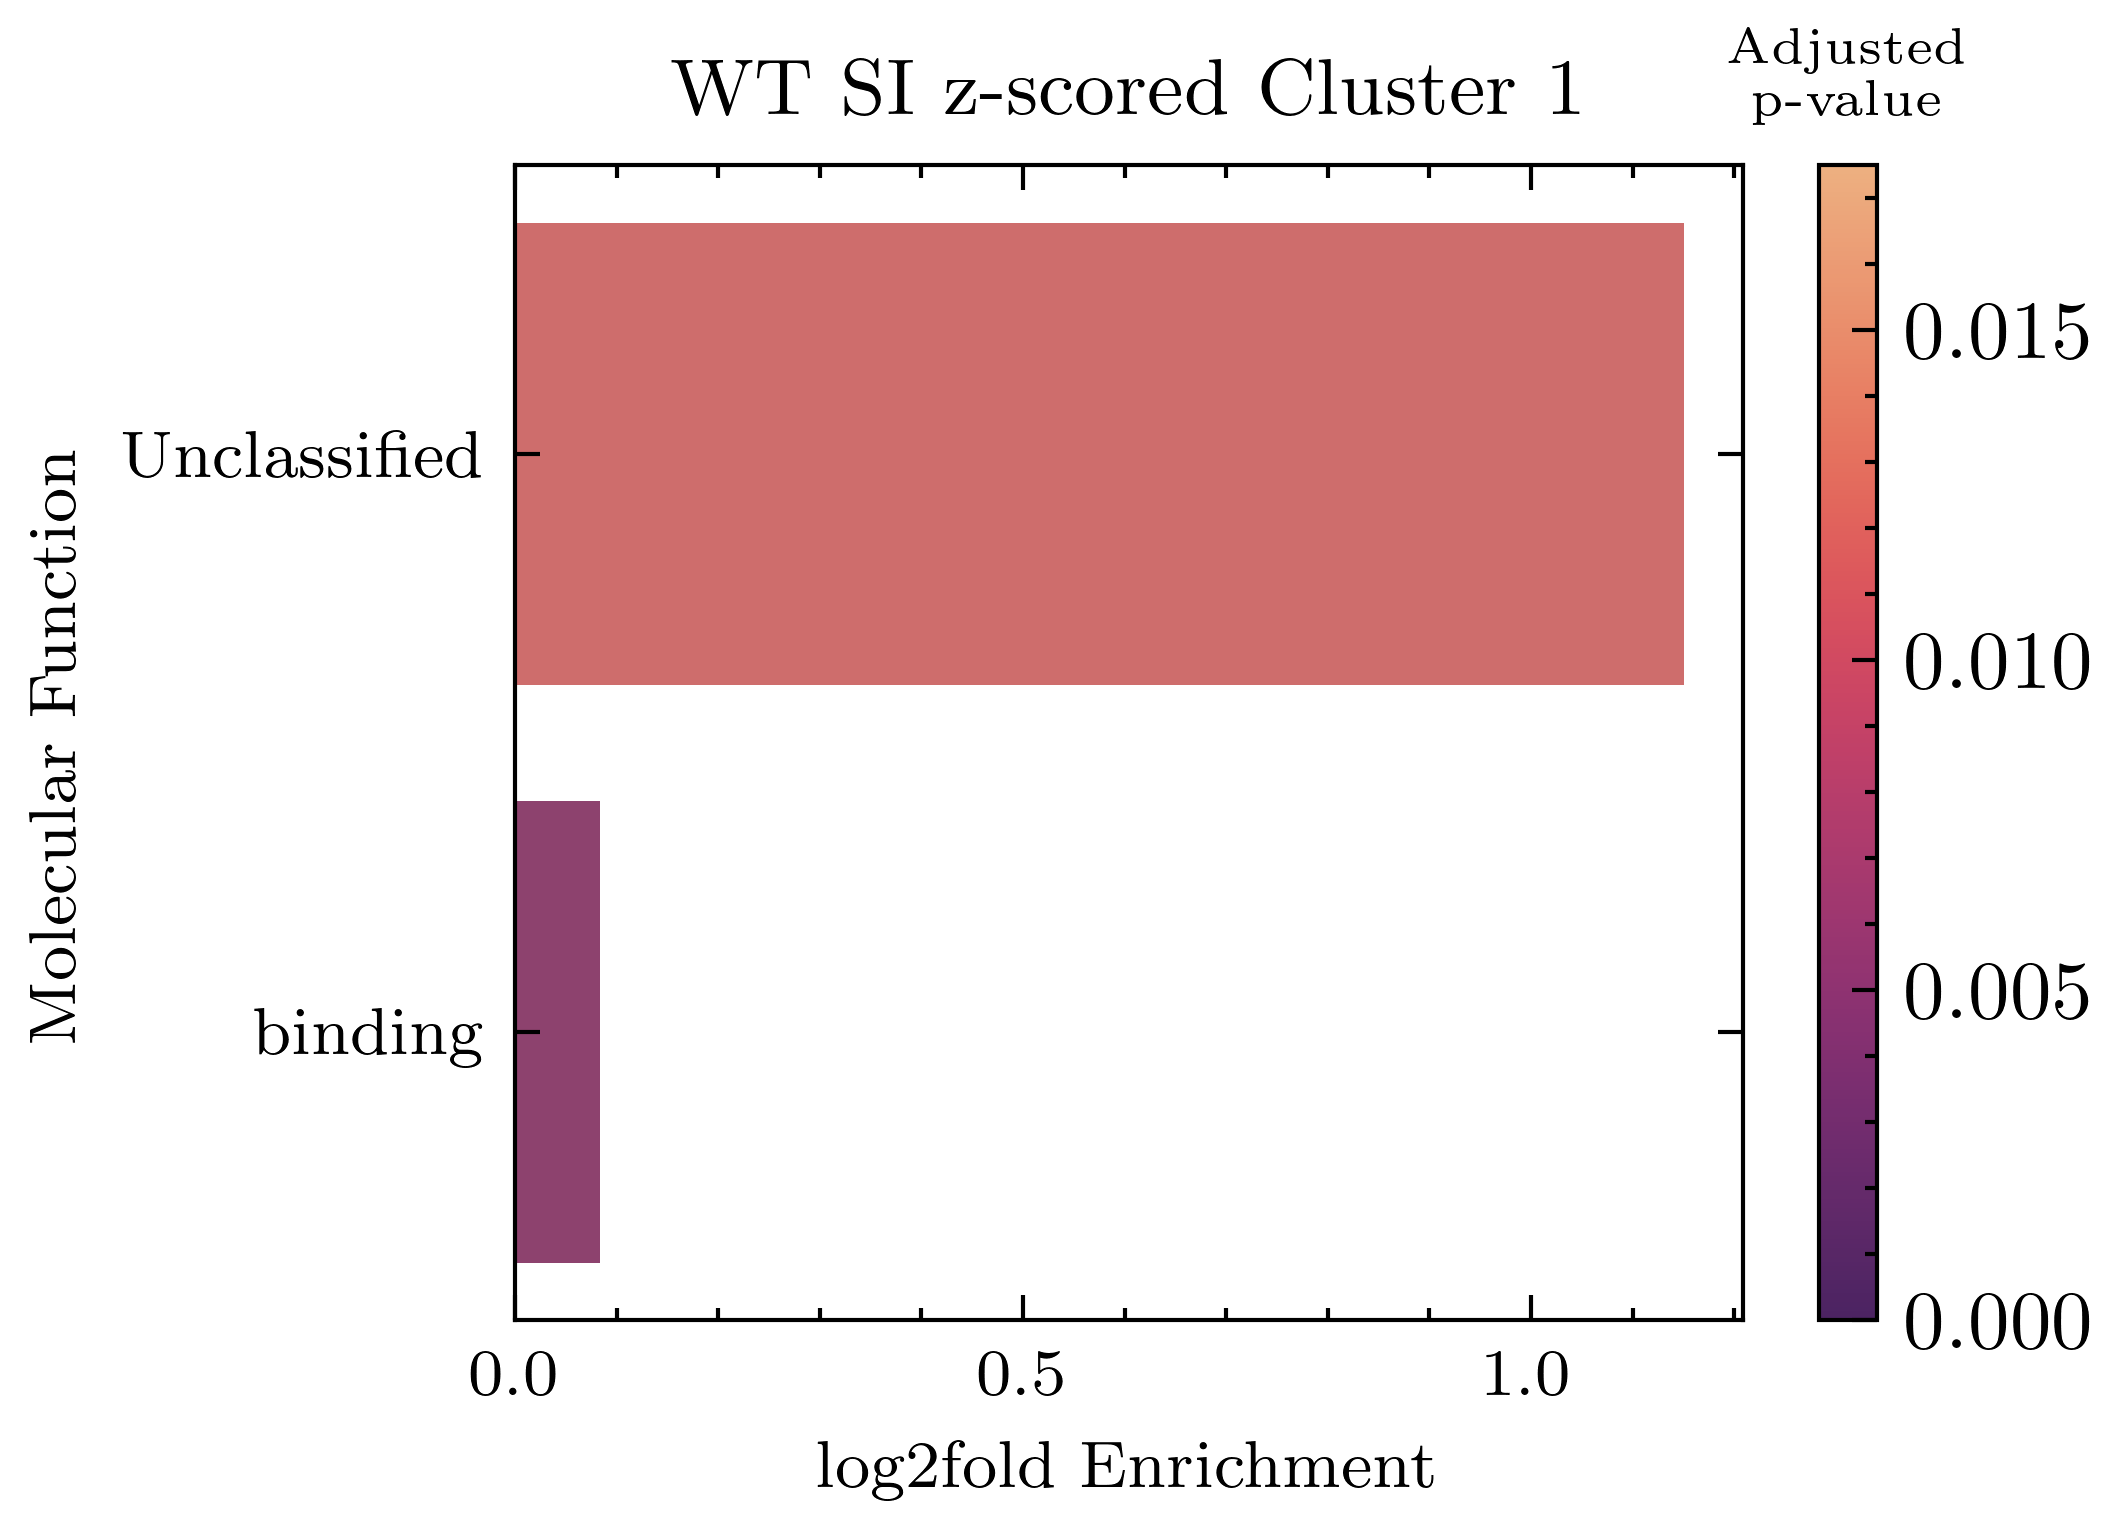

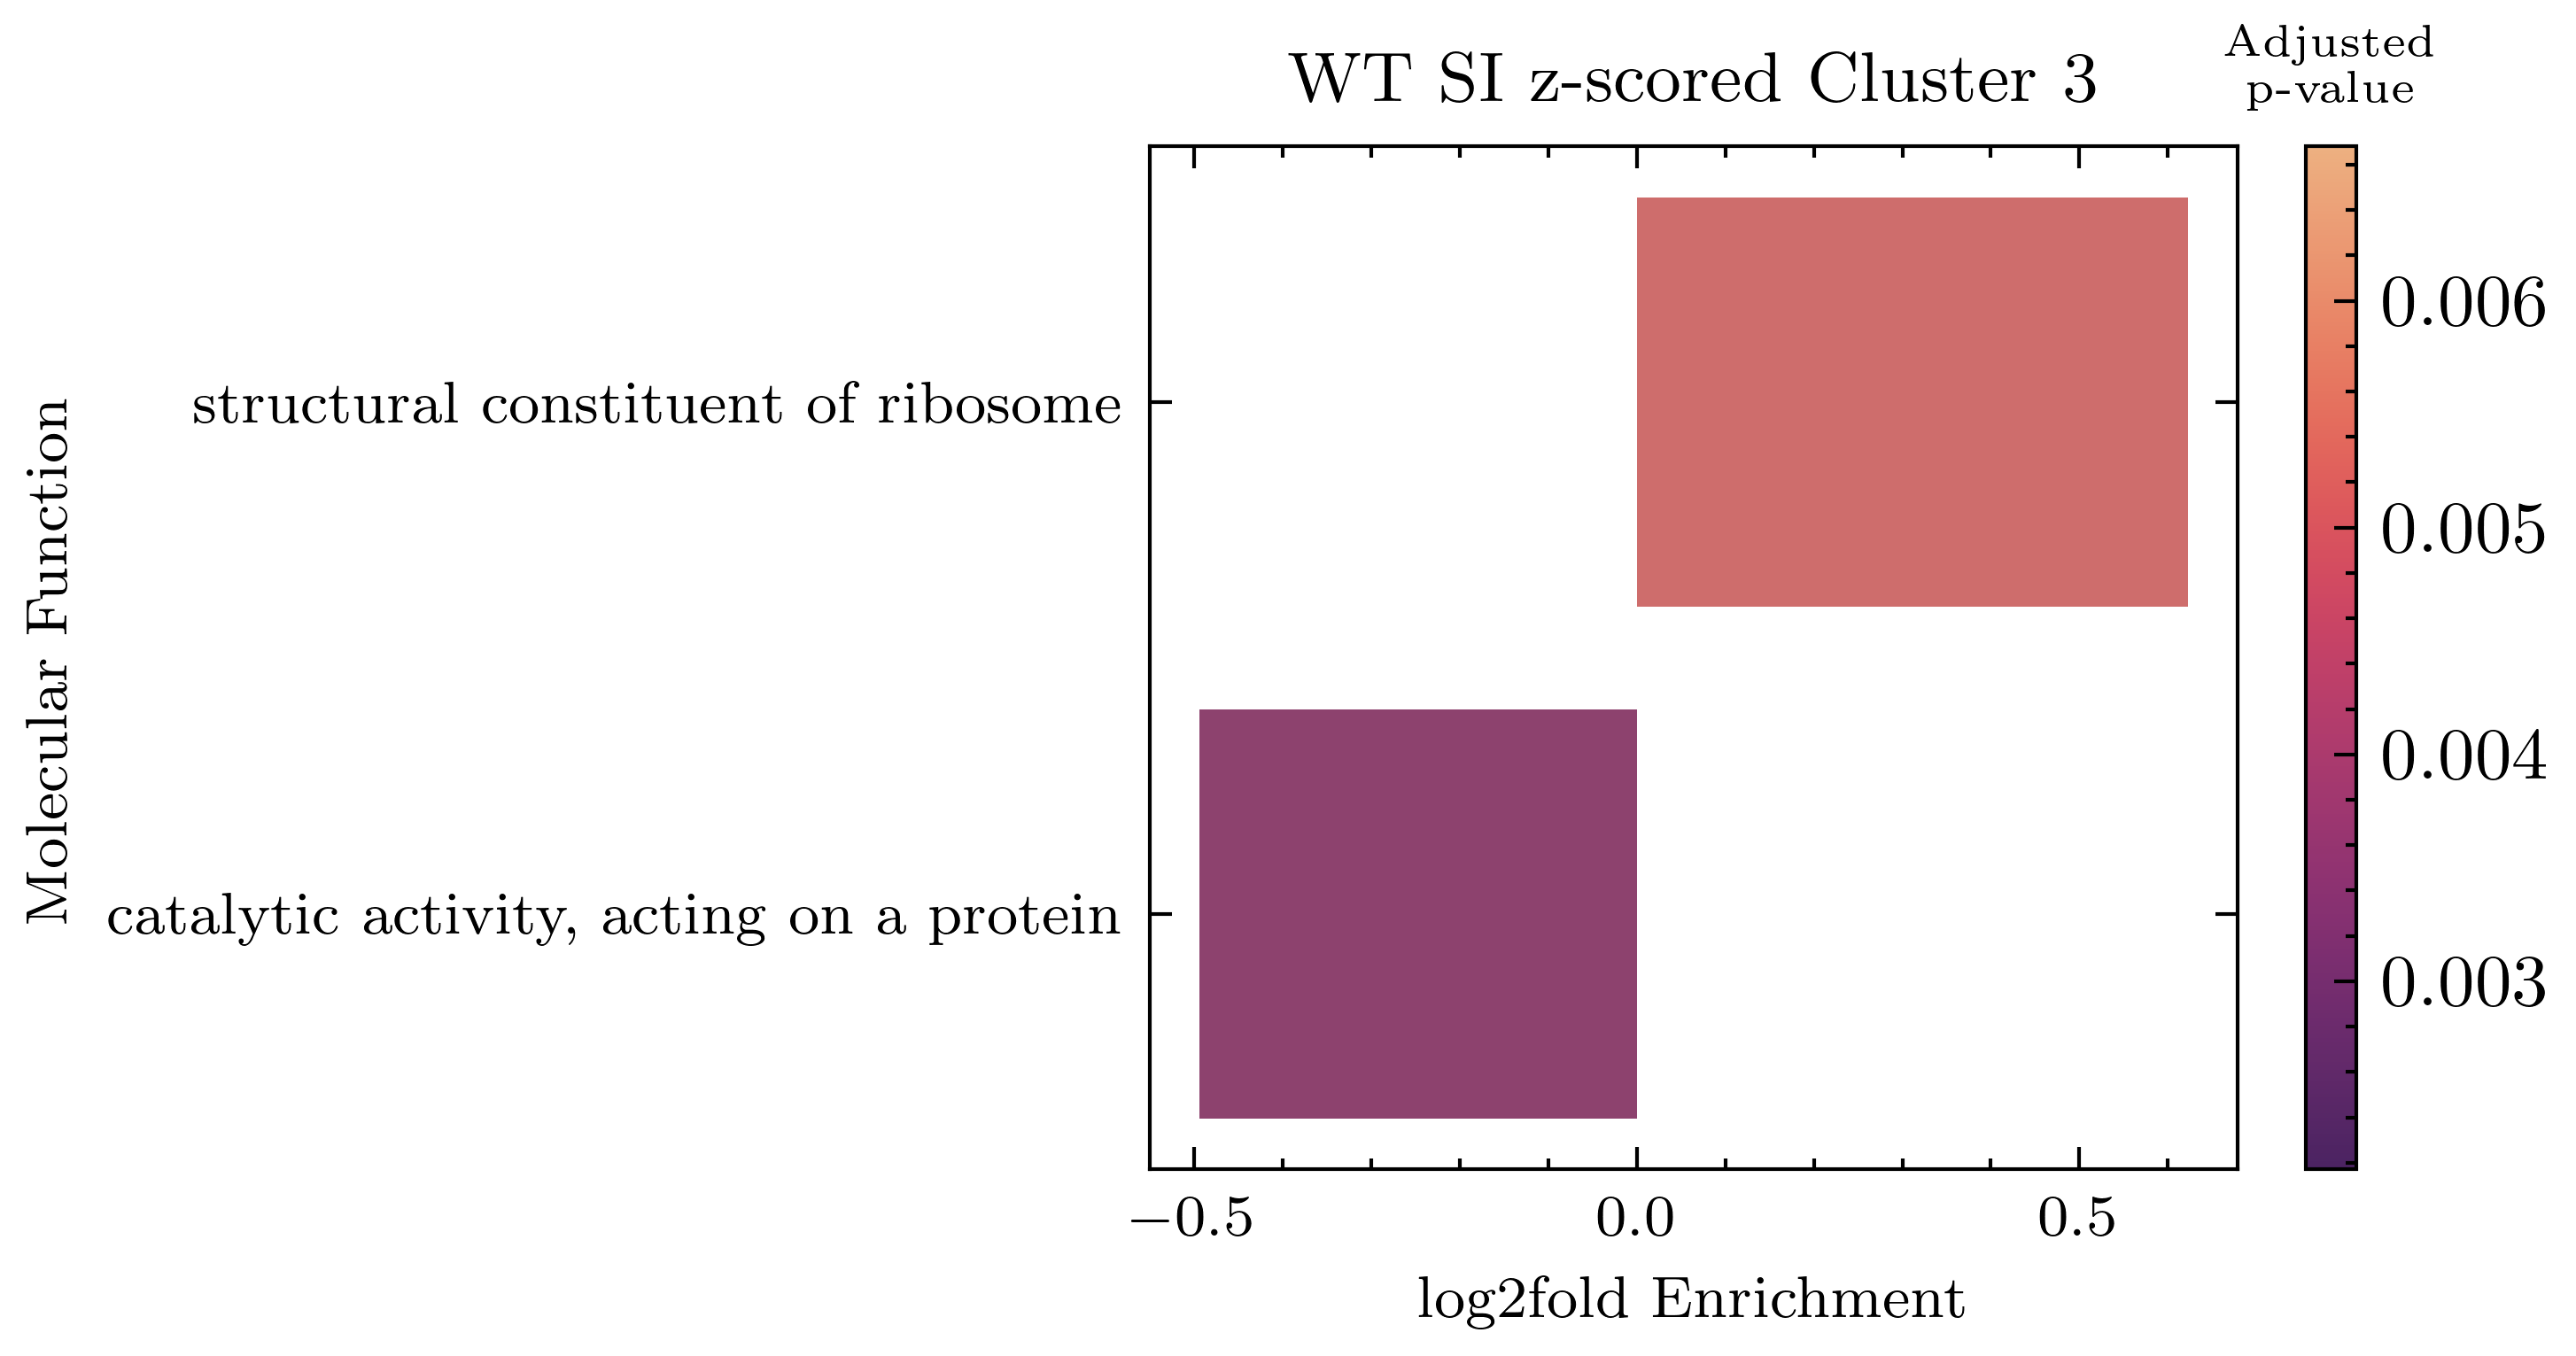

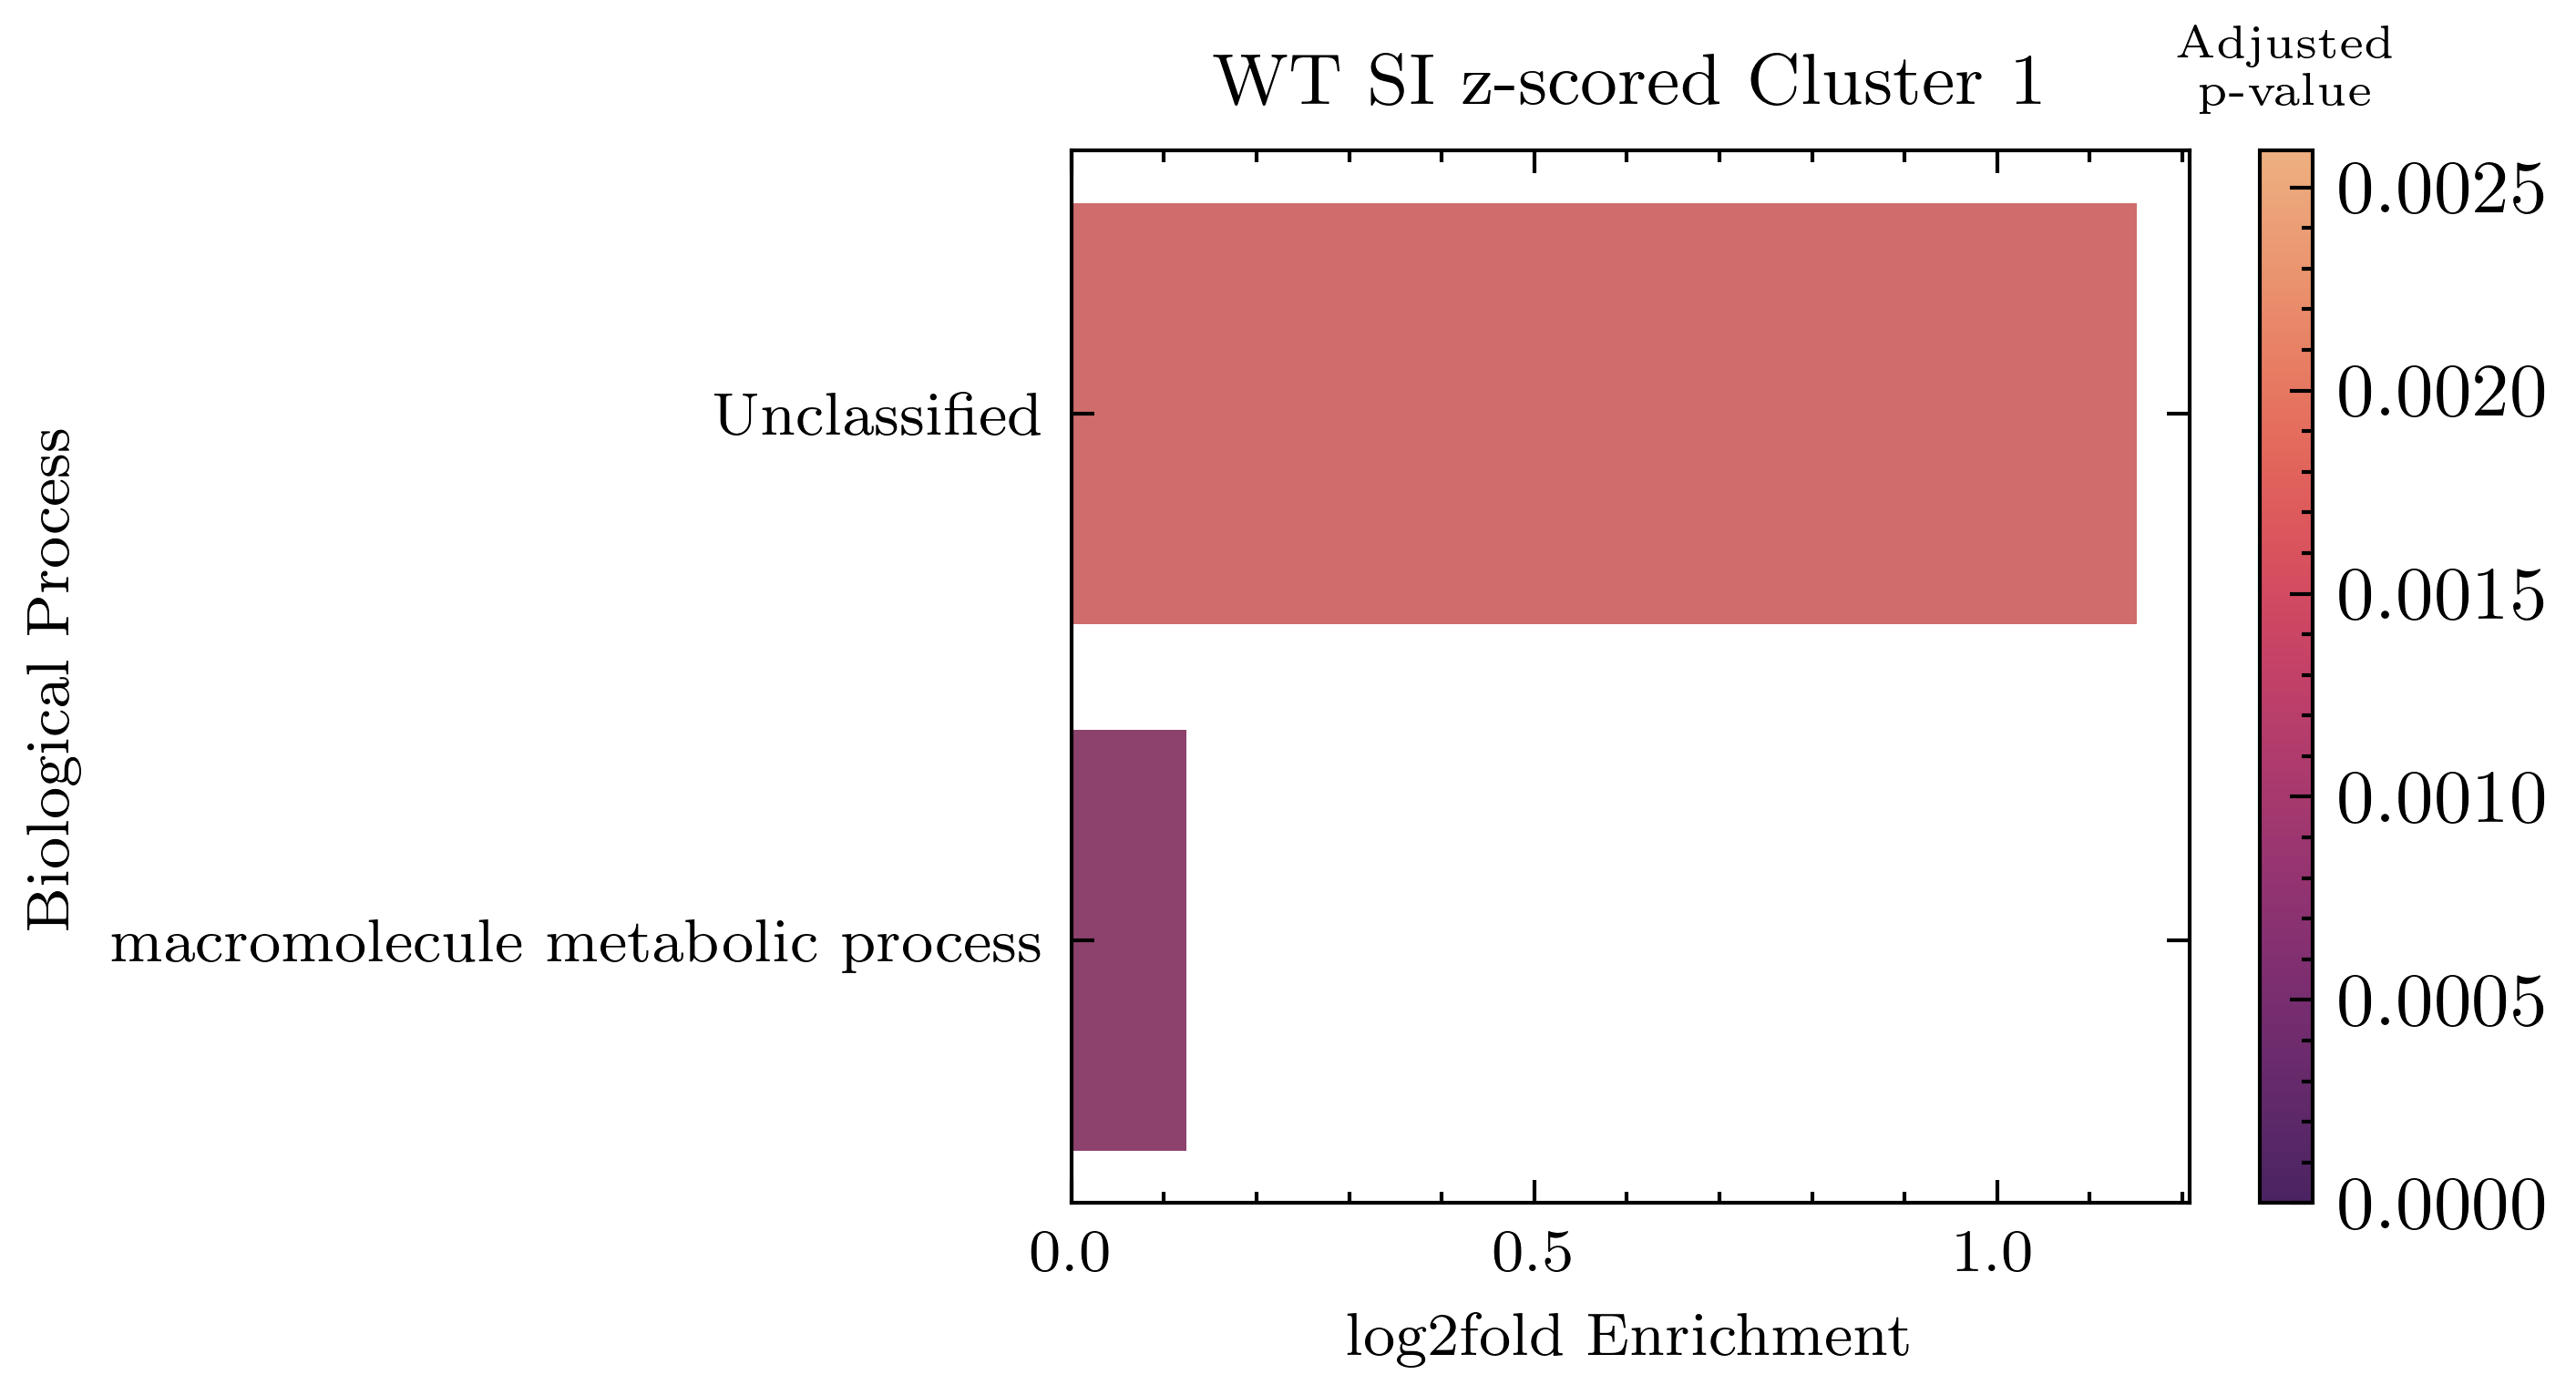

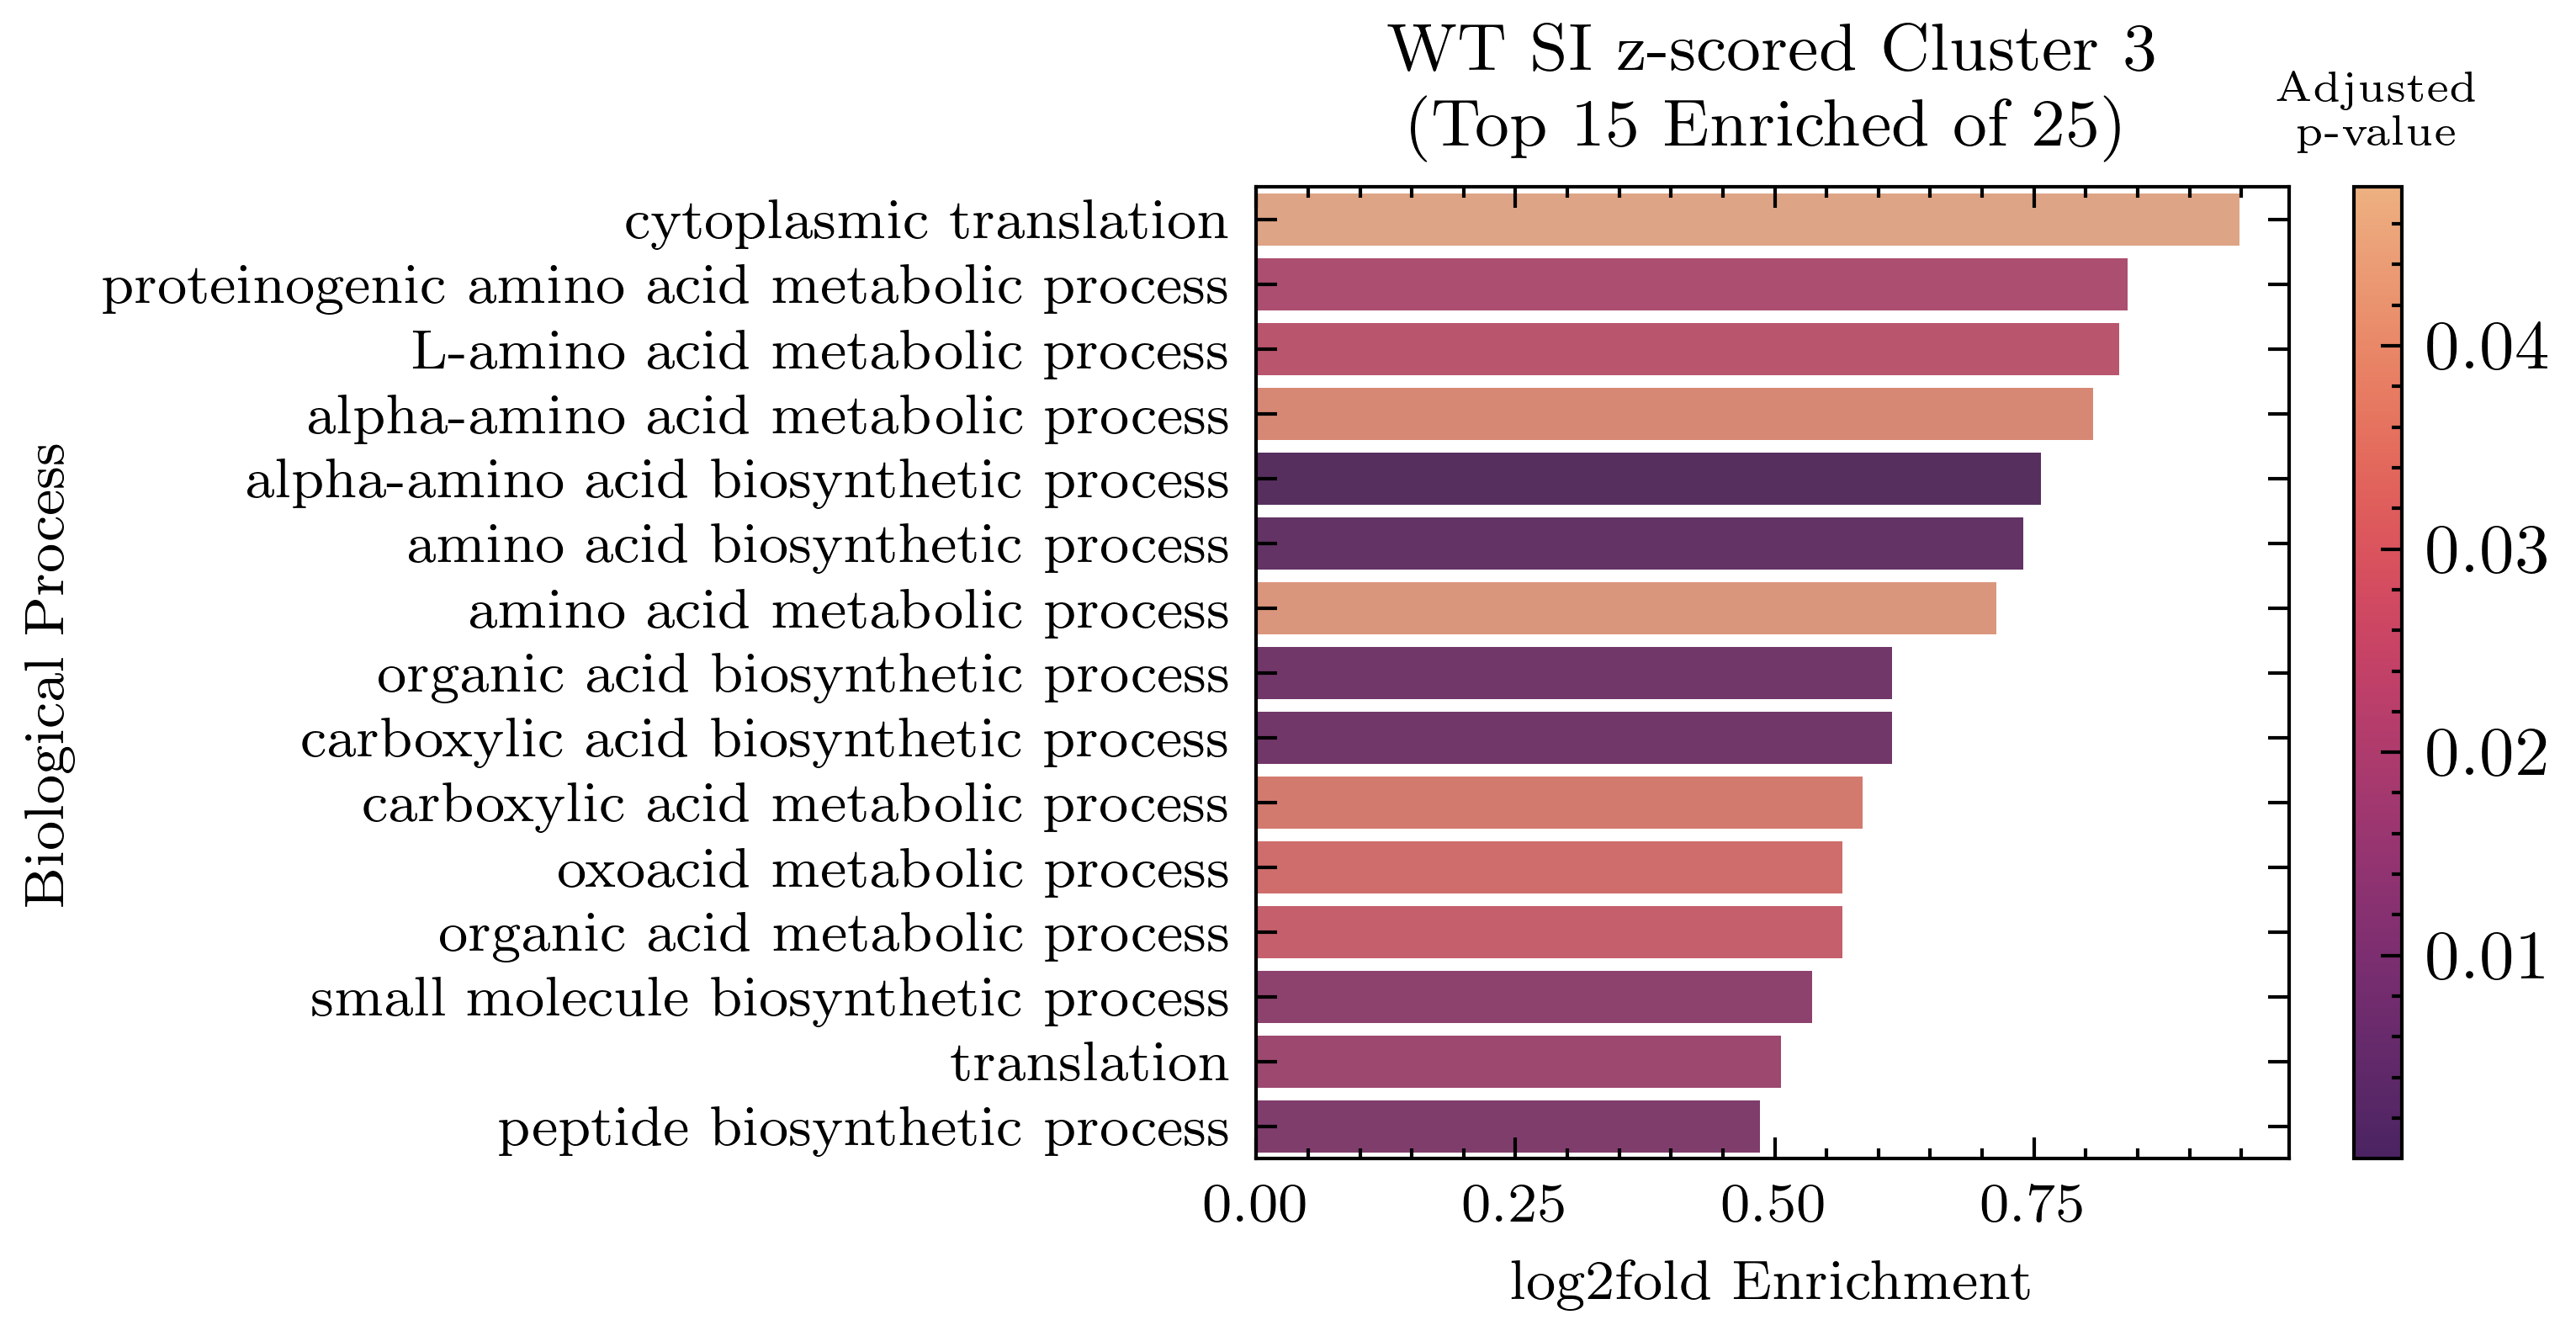

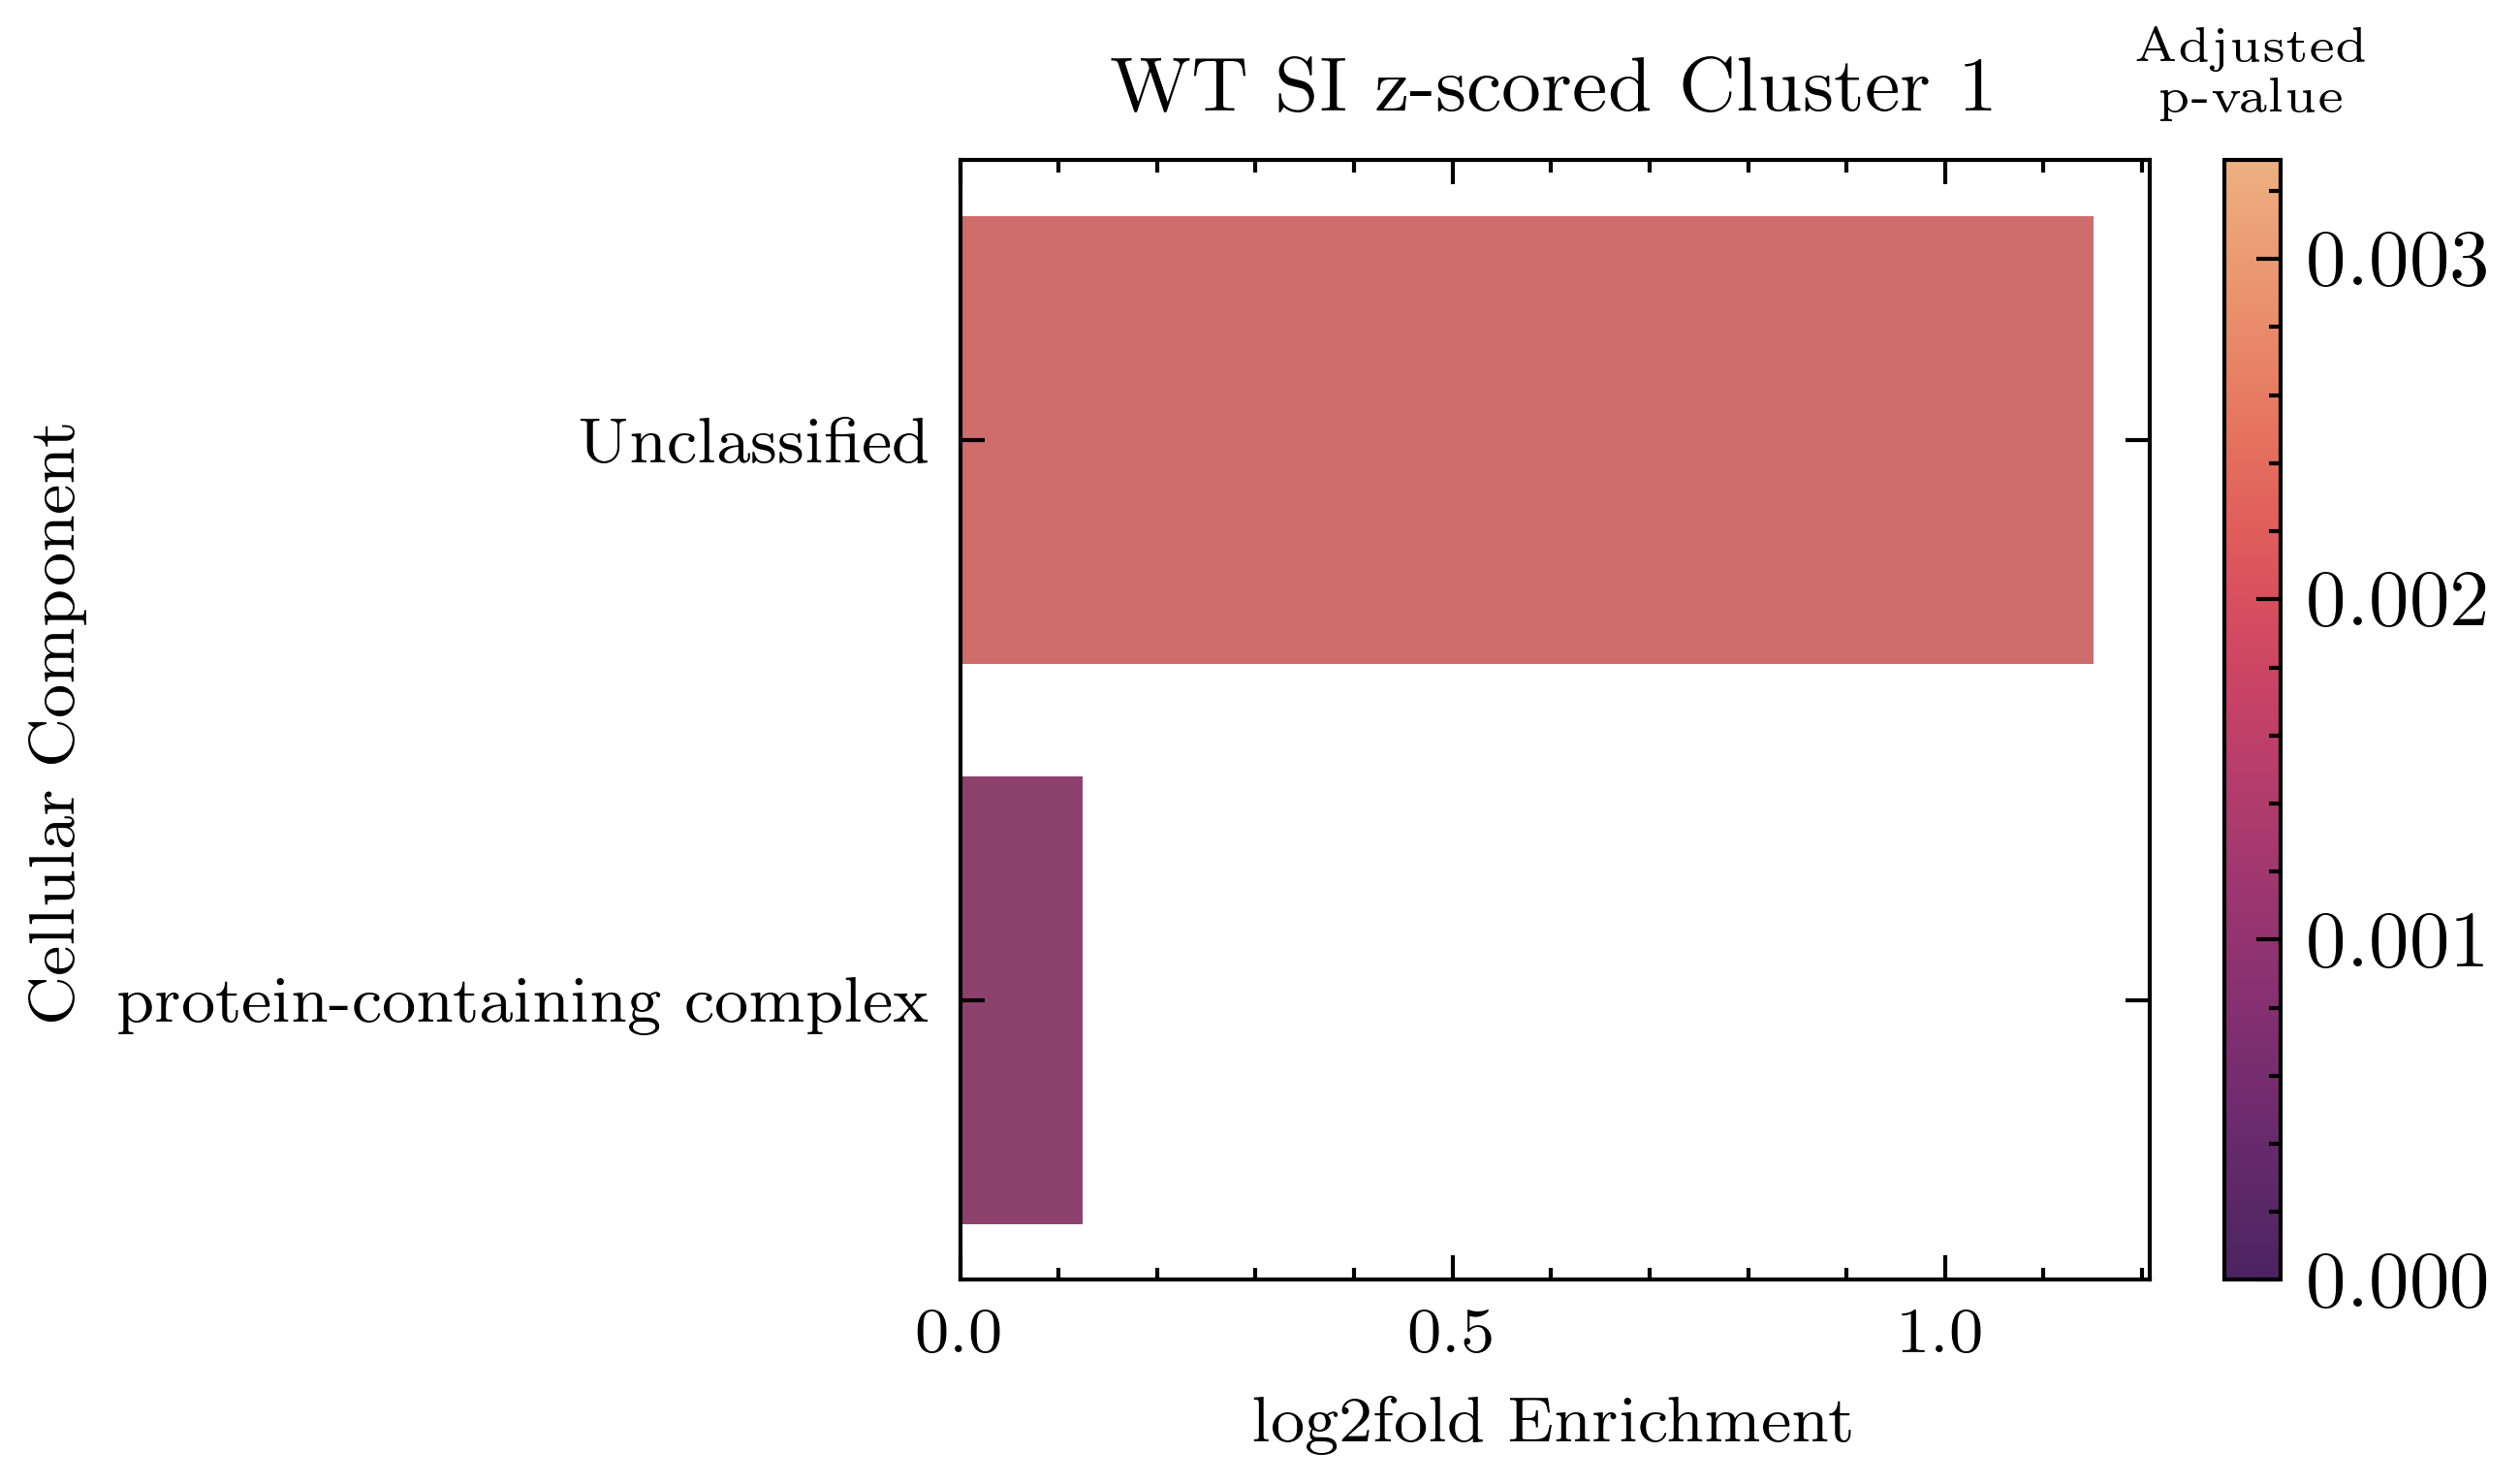

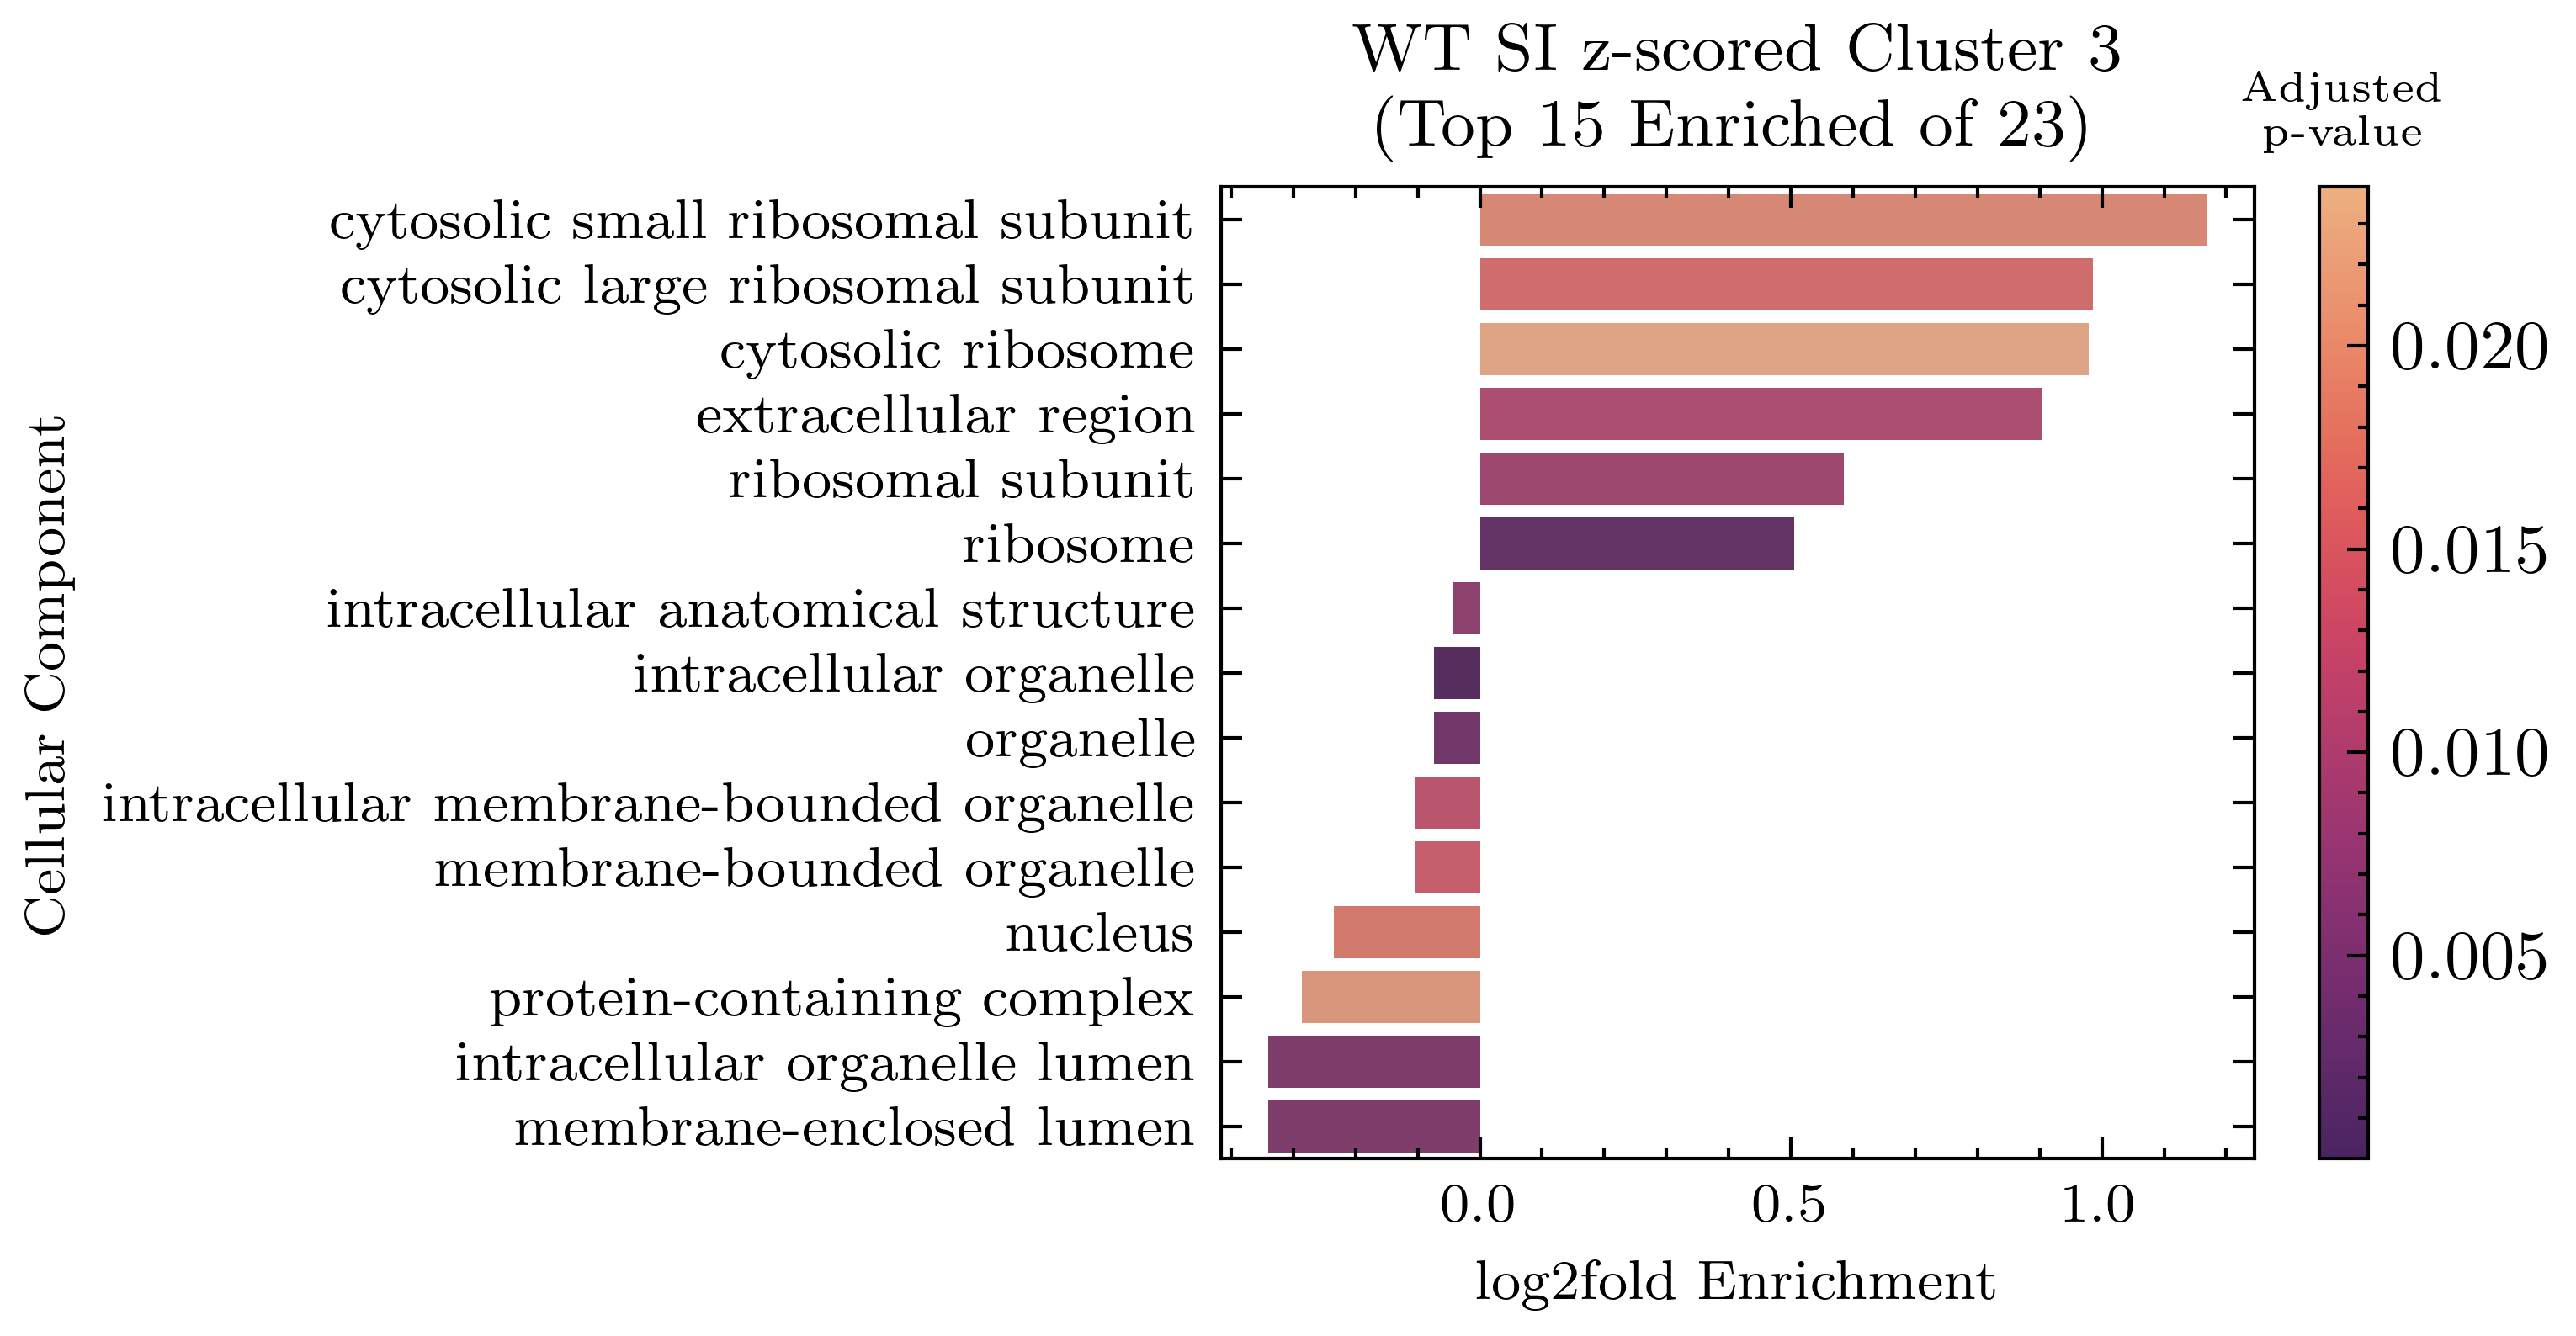

In [15]:

for i in range(3):
    data = [cl1_mol,cl2_mol,cl3_mol][i]
    
    if len(data) ==0: #skip iteration if no significant results (i.e., no rows in dataset)
        continue

    top15alert="" #if >15 significant results, generate disclaimer & trim results to top-15
    if(data.shape[0])>15:
        top15alert = f"\n(Top 15 Enriched of {data.shape[0]})"
        data = data.iloc[:15,:]

    with plt.style.context(['science','ieee']):
        s = sns.barplot( data, y = 'Molecular Function',x="log2fold Enrichment", hue="Adjusted p",
                        palette="flare", dodge=False)
        plt.title(f'WT SI z-scored Cluster {i+1} {top15alert}')
        plt.legend([],[], frameon=False)
        plt.yticks([],minor=True)


    #creating the colorbar of adj-p values
    norm = mpl.colors.Normalize(vmin=data["Adjusted p"].min(), vmax=data["Adjusted p"].max())
    cbar =plt.colorbar(plt.cm.ScalarMappable(cmap='flare_r', norm = norm), ax = plt.gca())
    cbar.ax.set_xlabel("Adjusted \np-value",fontsize=6, labelpad = 6)
    cbar.ax.xaxis.set_label_position('top') 
    plt.show()

for i in range(3):
    data = [cl1_bio,cl2_bio,cl3_bio][i]
    
    if len(data) ==0: #skip iteration if no significant results (i.e., no rows in dataset)
        continue

    top15alert="" #if >15 significant results, generate disclaimer & trim results to top-15
    if(data.shape[0])>15:
        top15alert = f"\n(Top 15 Enriched of {data.shape[0]})"
        data = data.iloc[:15,:]

    with plt.style.context(['science','ieee']):
        s = sns.barplot( data, y = 'Biological Process',x="log2fold Enrichment", hue="Adjusted p",
                        palette="flare", dodge=False)
        plt.title(f'WT SI z-scored Cluster {i+1} {top15alert}')
        plt.legend([],[], frameon=False)
        plt.yticks([],minor=True)


    #creating the colorbar of adj-p values
    norm = mpl.colors.Normalize(vmin=data["Adjusted p"].min(), vmax=data["Adjusted p"].max())
    cbar =plt.colorbar(plt.cm.ScalarMappable(cmap='flare_r', norm = norm), ax = plt.gca())
    cbar.ax.set_xlabel("Adjusted \np-value",fontsize=6, labelpad = 6)
    cbar.ax.xaxis.set_label_position('top') 
    plt.show()

for i in range(3):
    data = [cl1_cell,cl2_cell,cl3_cell][i]

    if len(data) ==0: #skip iteration if no significant results (i.e., no rows in dataset)
        continue

    top15alert="" #if >15 significant results, generate disclaimer & trim results to top-15
    if(data.shape[0])>15:
        top15alert = f"\n(Top 15 Enriched of {data.shape[0]})"
        data = data.iloc[:15,:]
    

    with plt.style.context(['science','ieee']):
        s = sns.barplot( data, y = 'Cellular Component',x="log2fold Enrichment", hue="Adjusted p",
                        palette="flare", dodge=False)
        plt.title(f'WT SI z-scored Cluster {i+1} {top15alert}')
        plt.legend([],[], frameon=False)
        plt.yticks([],minor=True)


    #creating the colorbar of adj-p values
    norm = mpl.colors.Normalize(vmin=data["Adjusted p"].min(), vmax=data["Adjusted p"].max())
    cbar =plt.colorbar(plt.cm.ScalarMappable(cmap='flare_r', norm = norm), ax = plt.gca())
    cbar.ax.set_xlabel("Adjusted \np-value",fontsize=6, labelpad = 6)
    cbar.ax.xaxis.set_label_position('top') 
    plt.show()

## Supplementary Figures

### SF1. Outlier Genes

In [16]:
gene_mean = WT_S.mean(axis=1)
gene_mean = gene_mean.sort_values()

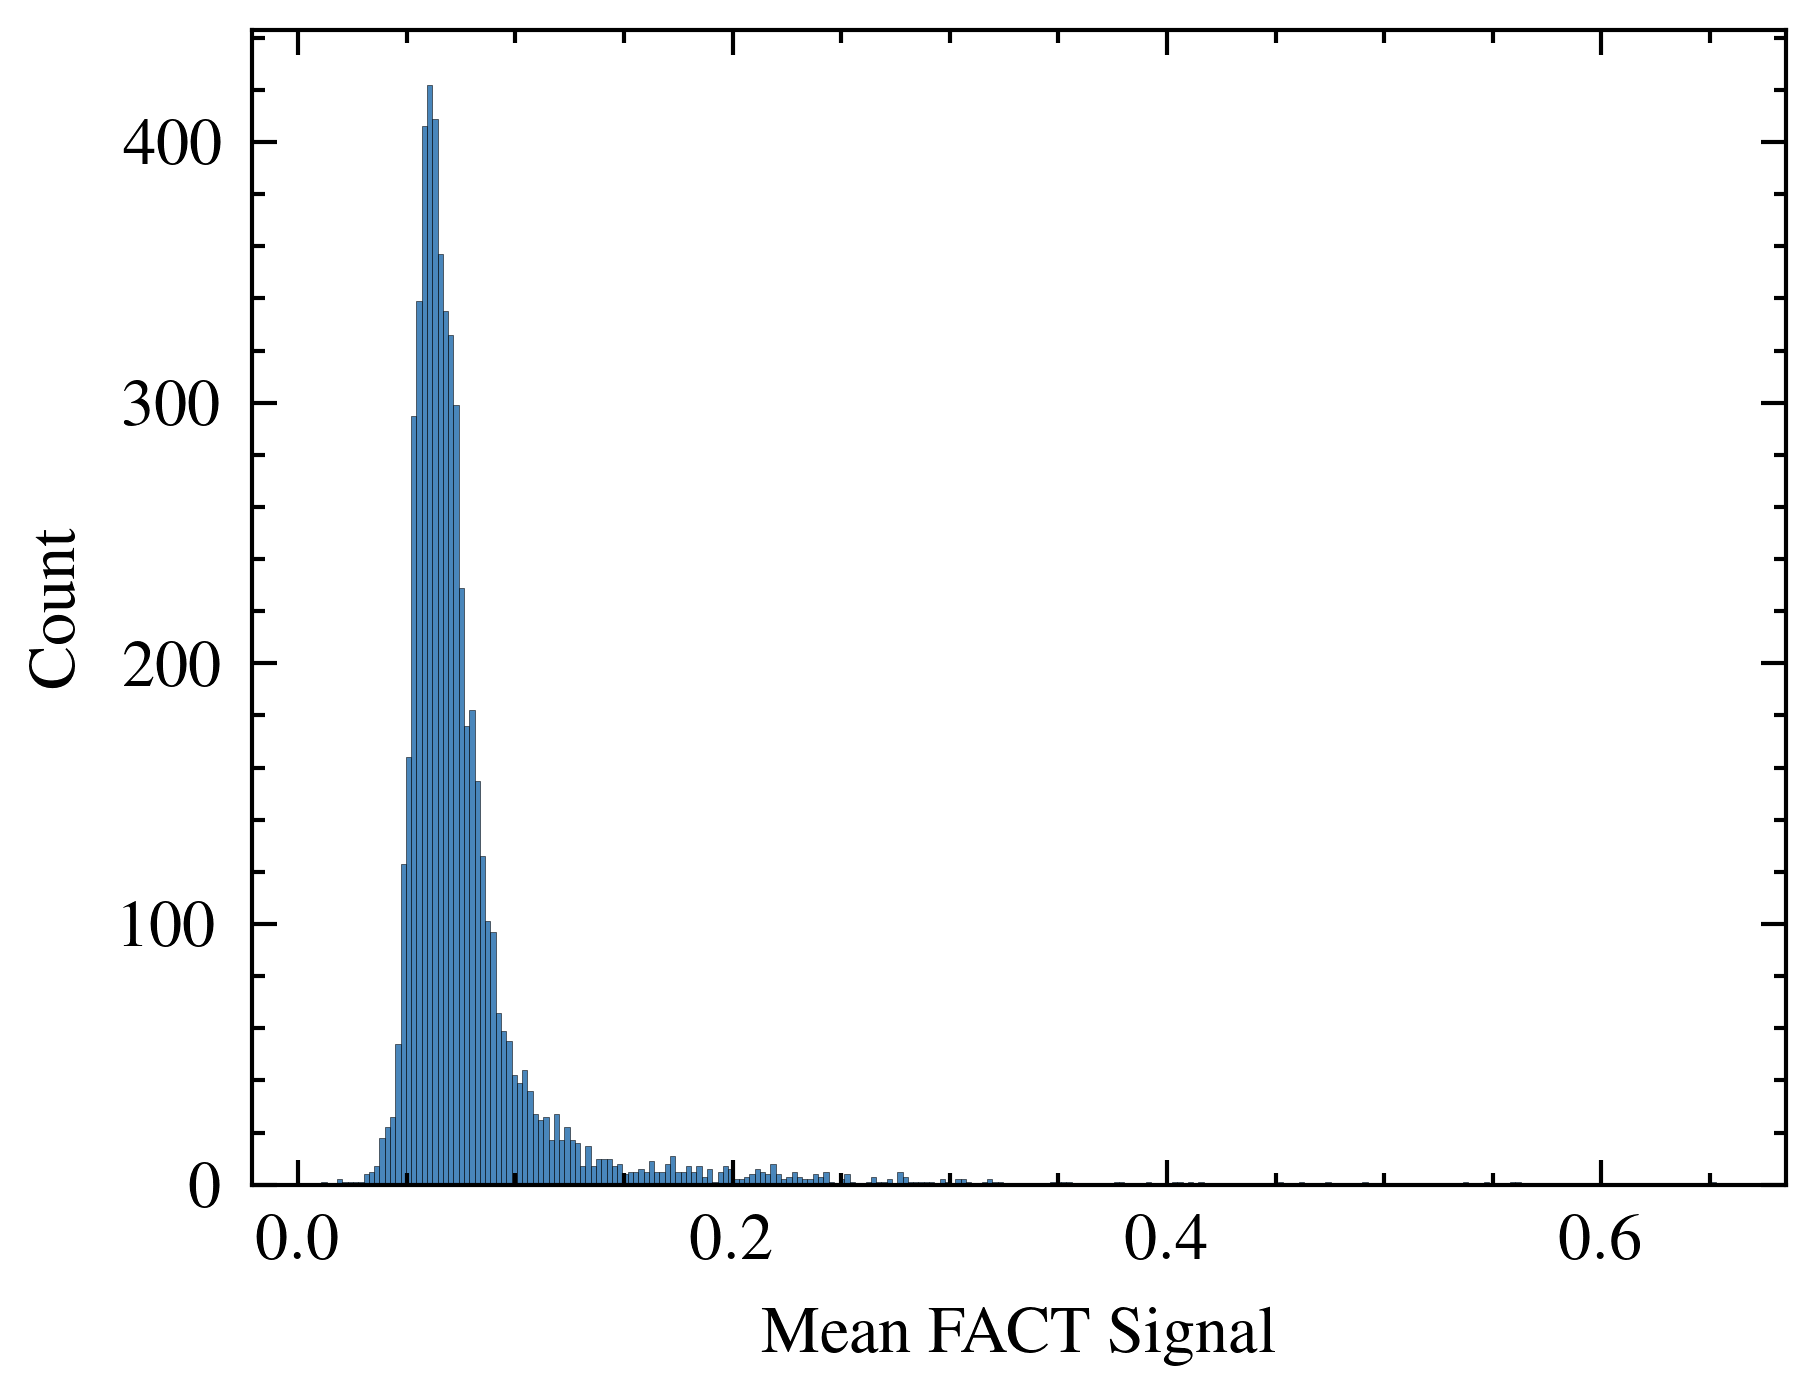

In [17]:
with plt.style.context(['science','ieee','std-colors']):
    sns.histplot(gene_mean)
    plt.xlabel("Mean FACT Signal")
    plt.show()

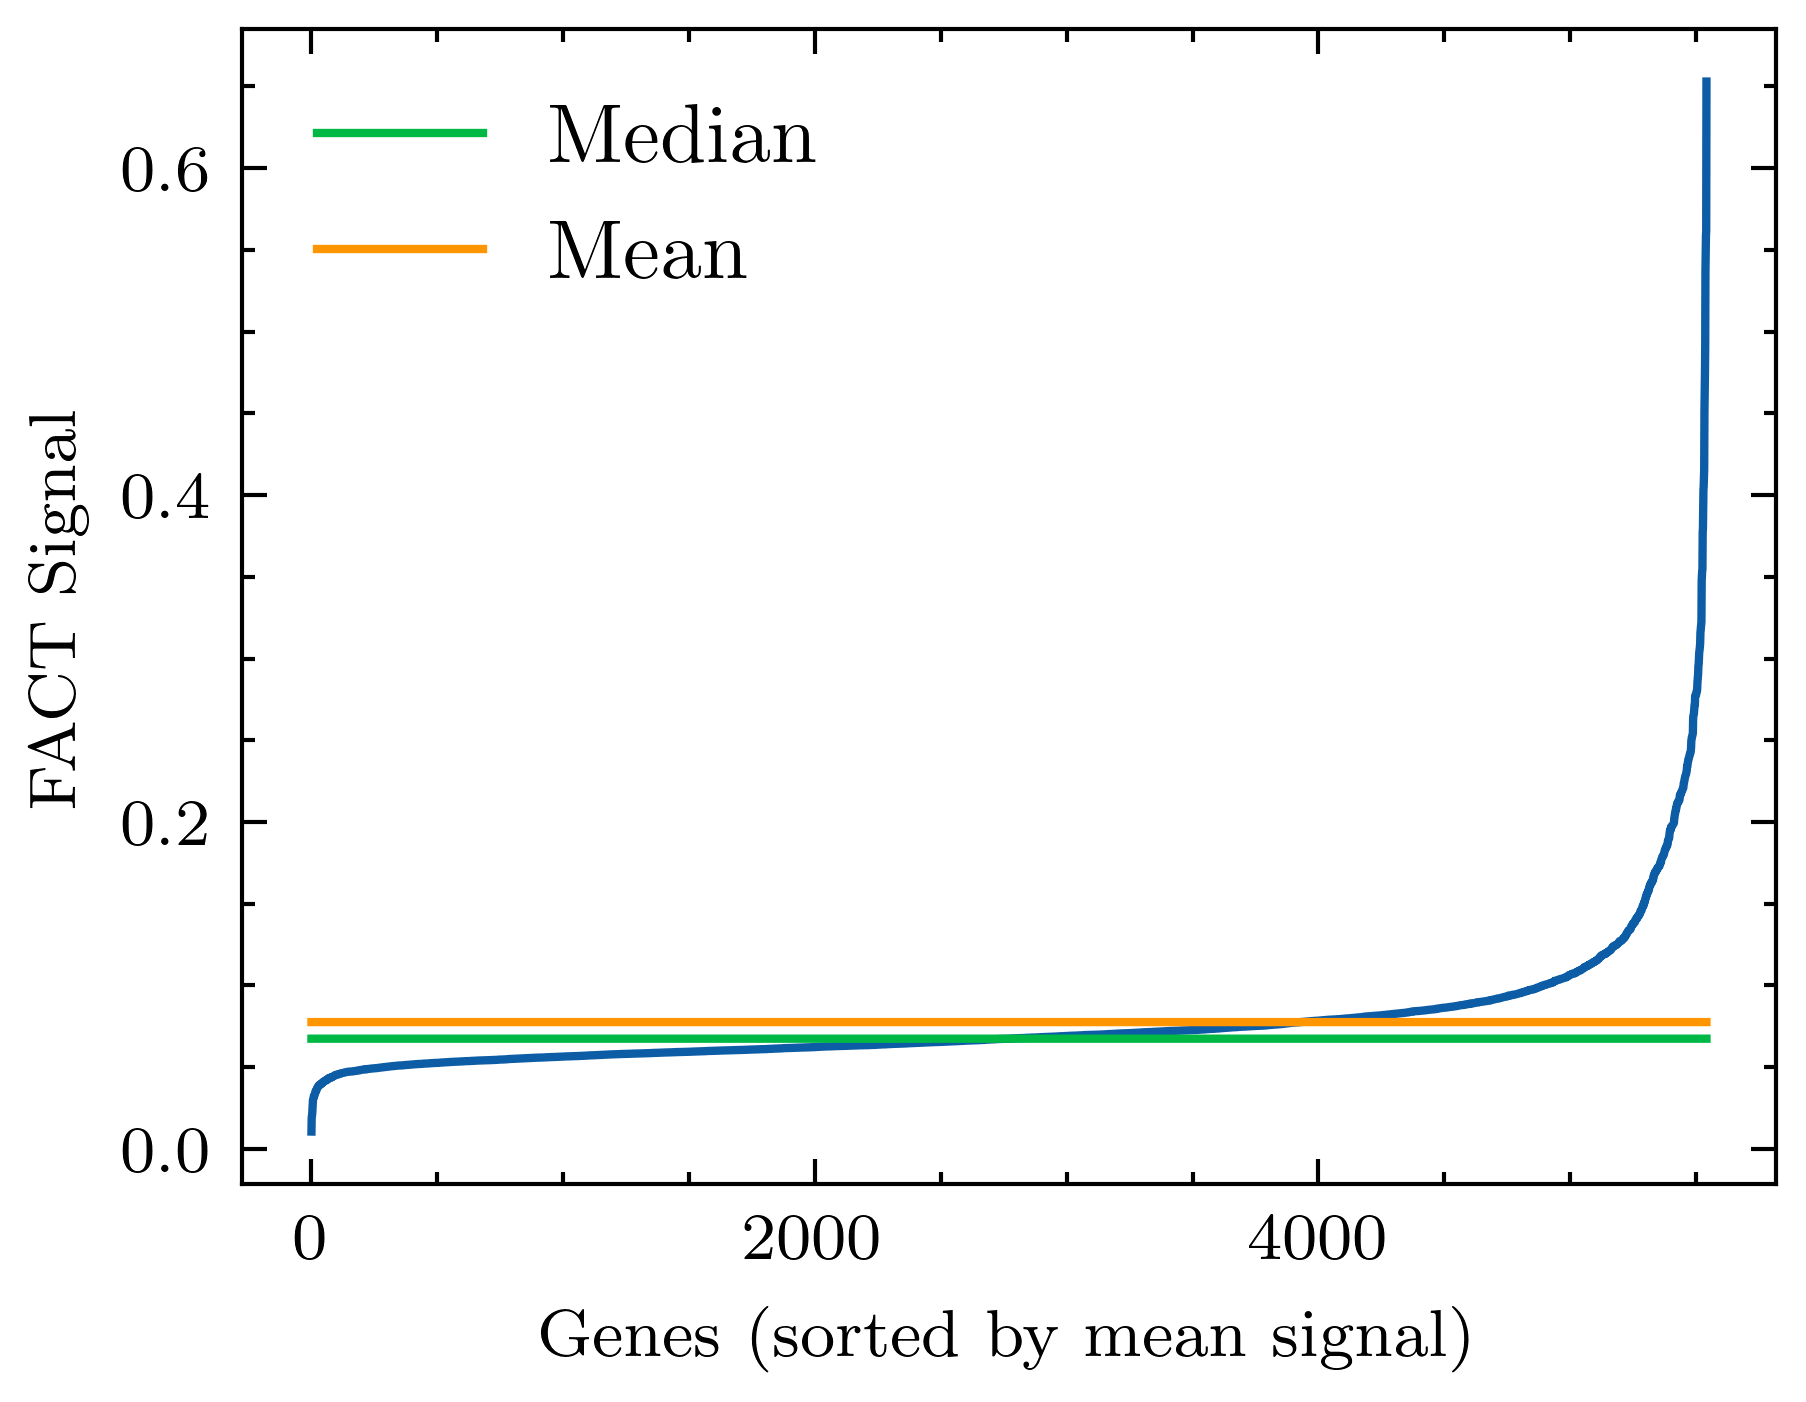

In [18]:
x = gene_mean
median =[x[round(len(x)/2)]]*5542
mean = [gene_mean.mean()]*5542
with plt.style.context(['science','ieee','std-colors']):
    x = gene_mean.to_list()
    plt.plot(x)
    plt.plot(median, label = "Median")
    plt.plot(mean, label = "Mean")
    plt.xlabel("Genes (sorted by mean signal)")
    plt.ylabel("FACT Signal")
    
plt.legend()
plt.show()

### SF2. Unlike WT, Chd1 occupancy pattern does not converge as SF is increased

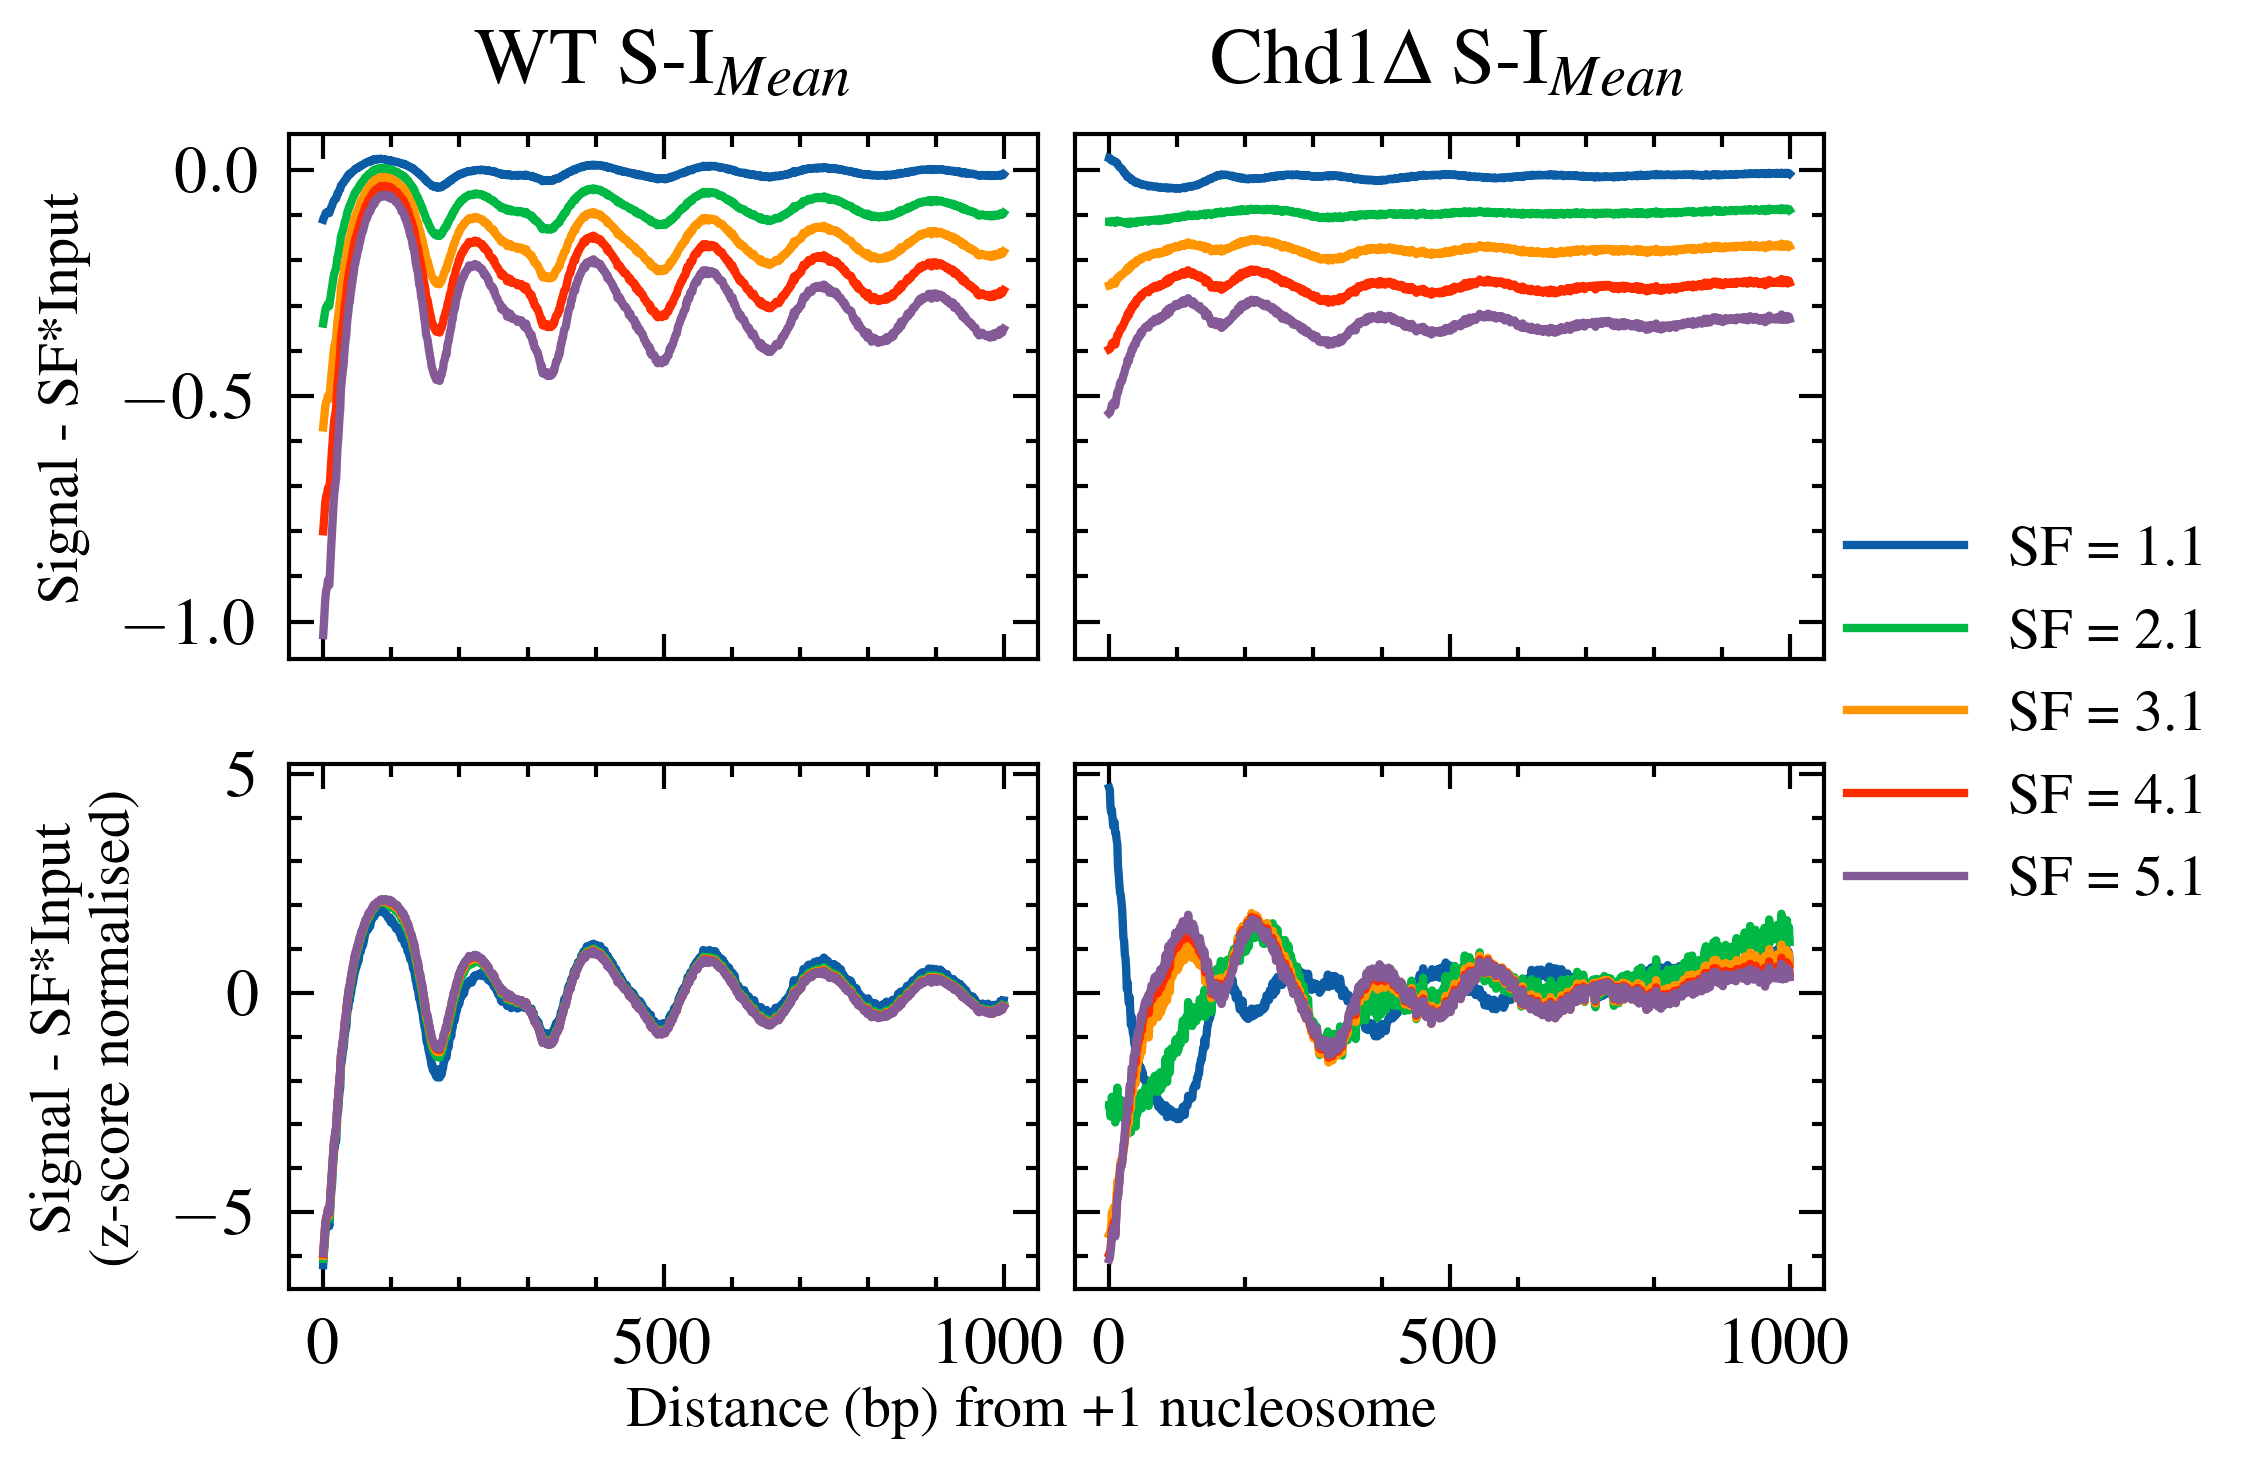

In [19]:
with plt.style.context(['science','ieee', 'std-colors']):

    fig = plt.figure()
    gs = fig.add_gridspec(2,2, wspace=0.05) #to reduce width-space
    ((ax1,ax2),(ax3,ax4)) = gs.subplots()

    for i in range(1,50,10):
        tempWT = WT_S.mean()-(1+i/10)*WT_input.mean()
        tempMutant = mutant_S.mean()-(1+i/10)*mutant_input.mean()

        ax1.plot(tempWT,label= f"SF = {1+i/10}")
        ax3.plot(znorm(tempWT,axis=0),label = f"SF = {1+i/10}")

        ax2.plot(tempMutant,label= f"SF = {1+i/10}")
        ax4.plot(znorm(tempMutant,axis=0),label = f"SF = {1+i/10}")

    ax1.sharey(ax2)
    ax3.sharey(ax4)

    ax1.set_title('WT S-I$_{Mean}$')
    ax2.set_title('Chd1$\Delta$ S-I$_{Mean}$')
    ax1.set_ylabel('Signal - SF*Input',fontsize=7)
    ax3.set_ylabel('Signal - SF*Input \n (z-score normalised)',fontsize=7)
    fig.supxlabel('Distance (bp) from +1 nucleosome',fontsize=7)
    ax4.legend(bbox_to_anchor=(1, 1.5),
                         loc='upper left', borderaxespad=0.,fontsize=7)
    plt.xticks(range(0,1001,200),minor = True) #boolean causes many x values to disappear
    
    for ax in fig.get_axes(): #drop x-tick labels and y-ones from appropriate subplots
        ax.label_outer()

    plt.show()

### SF3. Silhouette plots over the long run

In [20]:
'''max_k=50

for idx in range (len(ds_names_list)):
    silhouette_score_dict[ds_names_list[idx]] = find_silhouette(max_k, ds_list[idx])
SS_df = pd.DataFrame(silhouette_score_dict)

SS_df.to_excel("SS_long_run.xlsx")

'''

'max_k=50\n\nfor idx in range (len(ds_names_list)):\n    silhouette_score_dict[ds_names_list[idx]] = find_silhouette(max_k, ds_list[idx])\nSS_df = pd.DataFrame(silhouette_score_dict)\n\nSS_df.to_excel("SS_long_run.xlsx")\n\n'

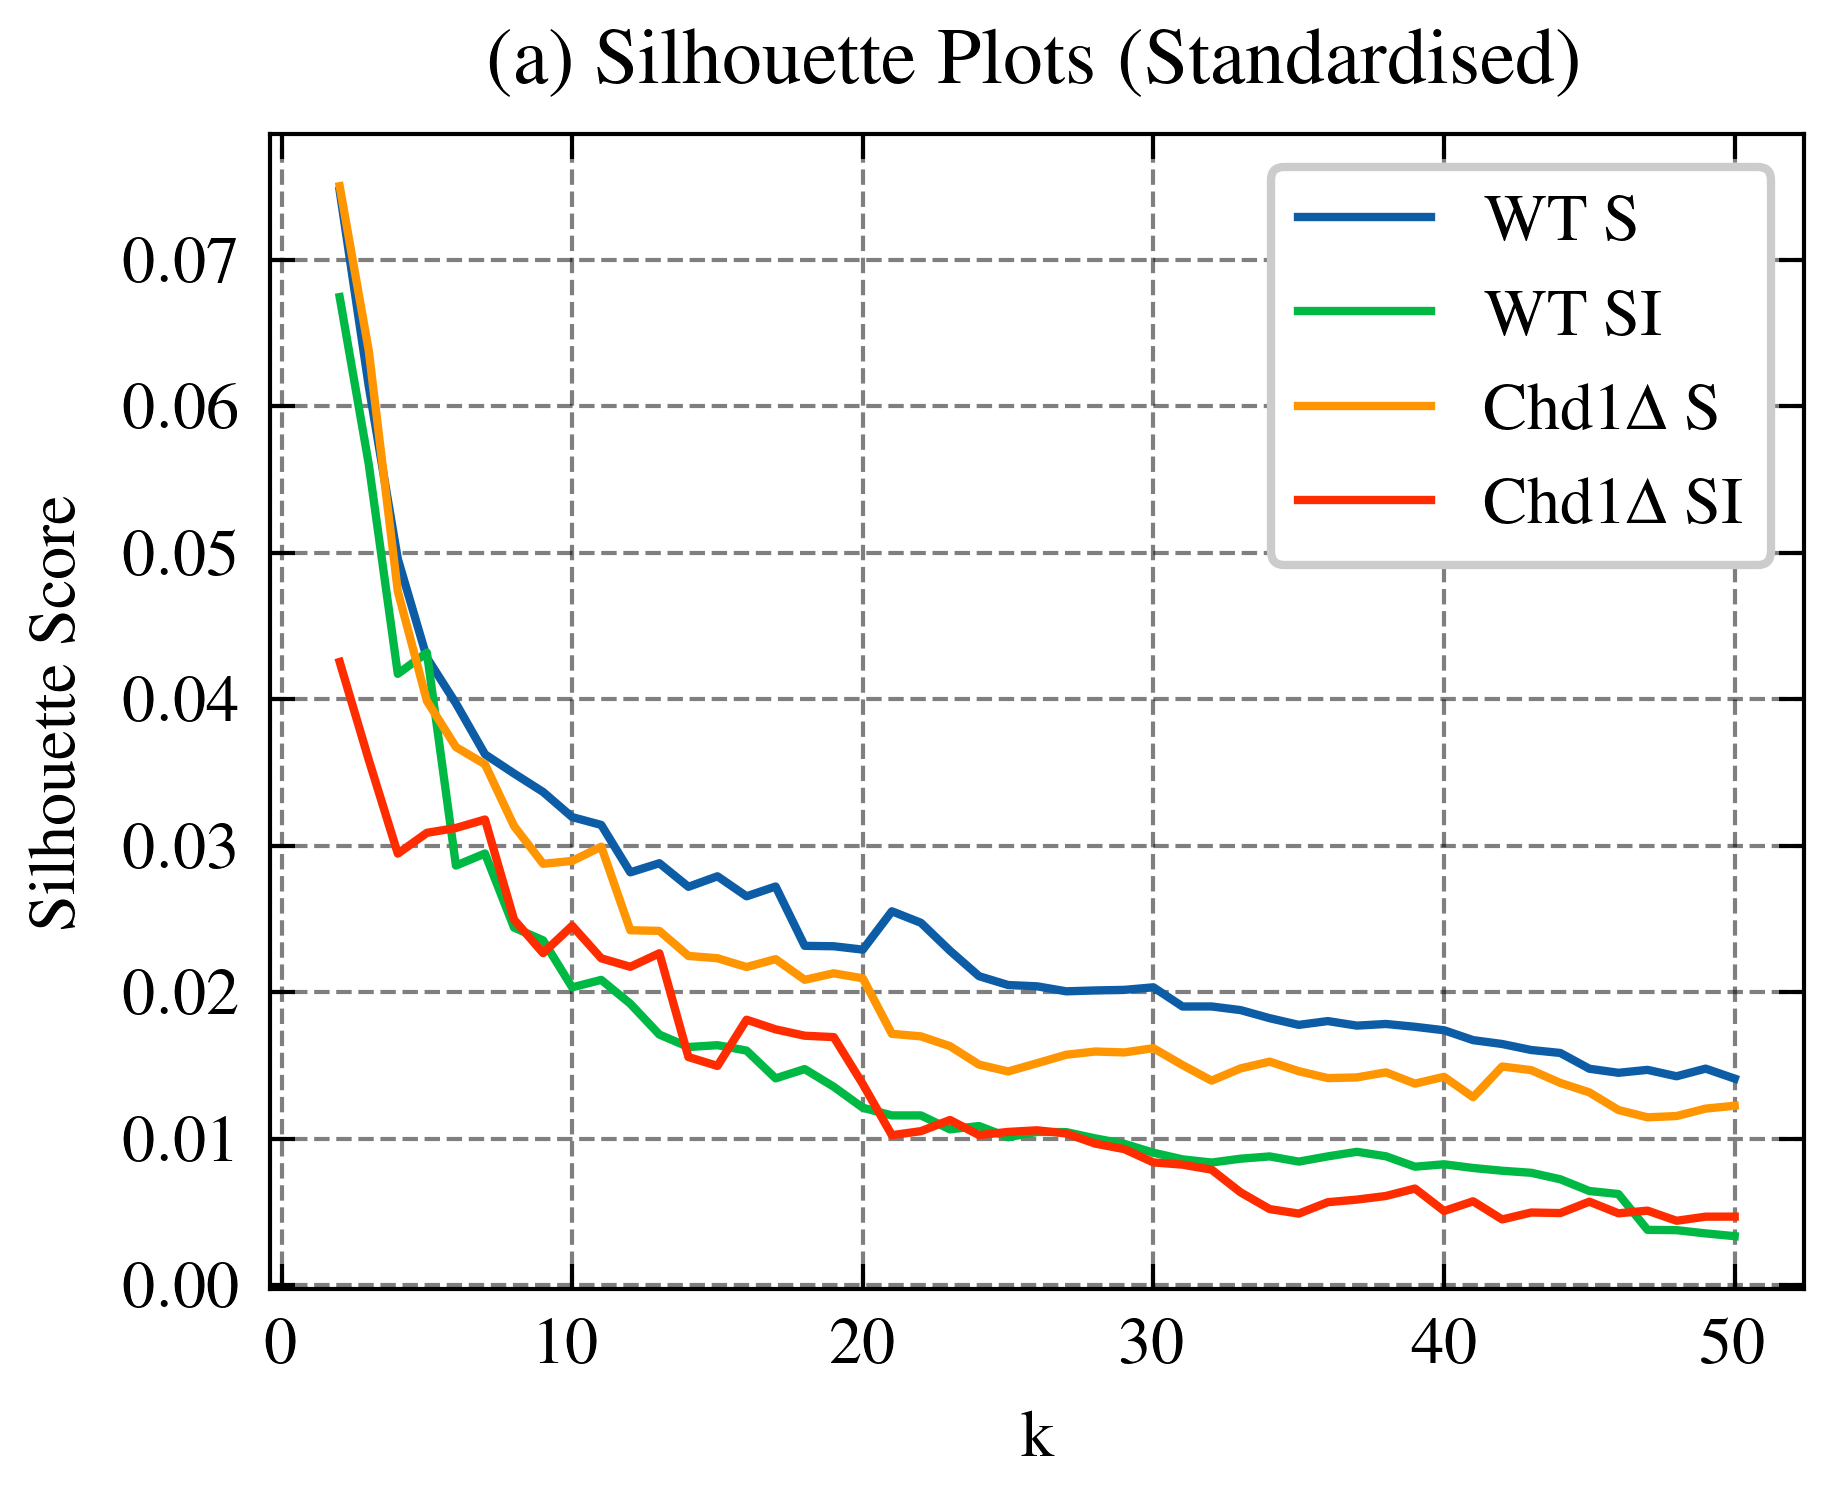

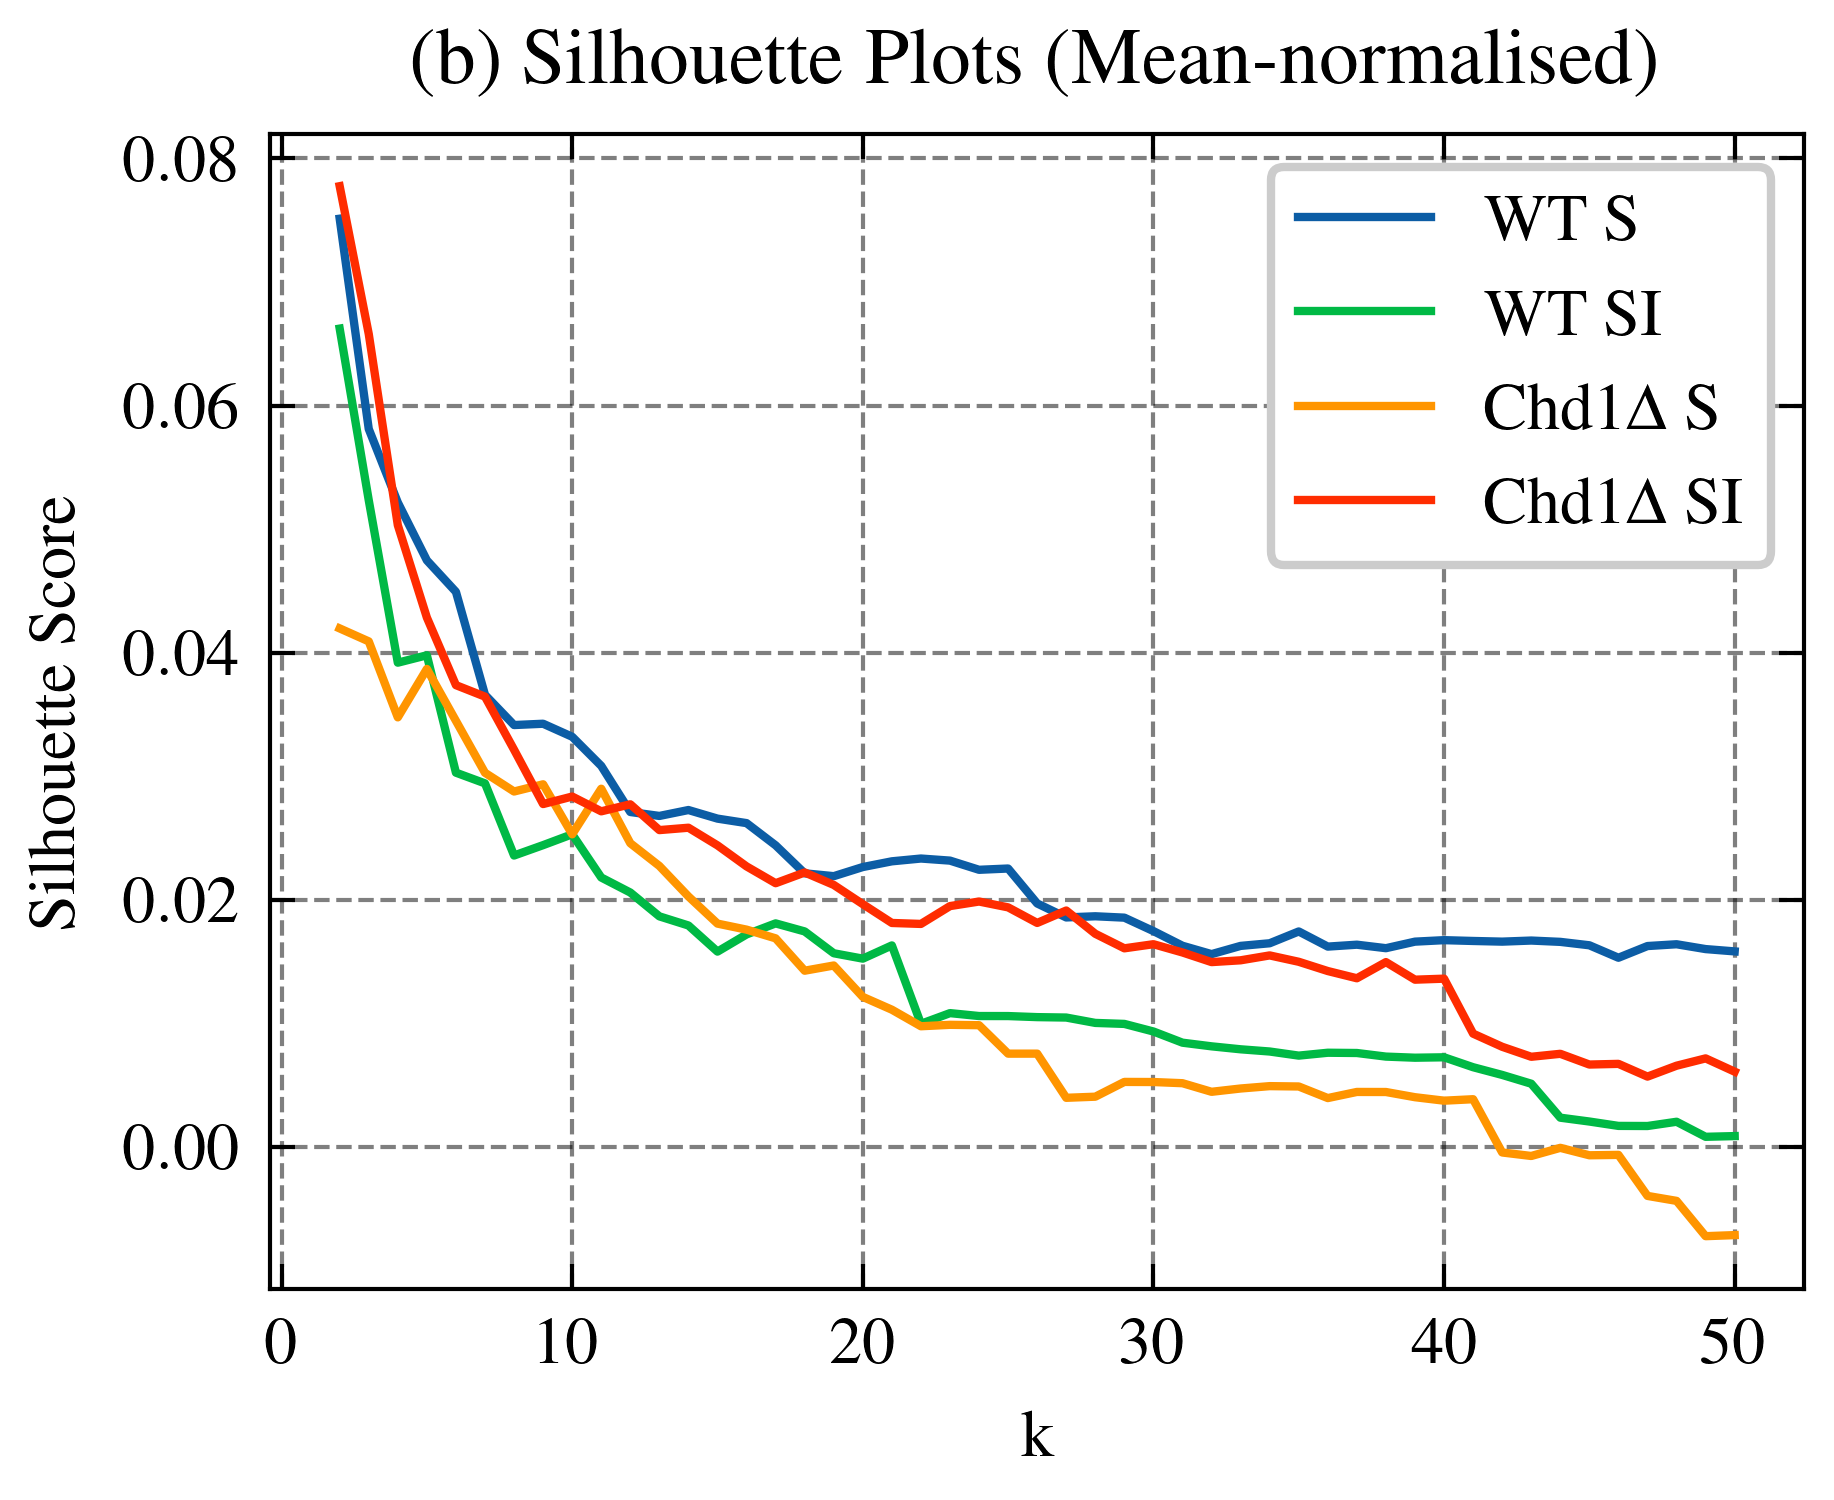

In [21]:
SS_df =pd.read_excel("SS_long_run.xlsx") #Load SS for k = 50


datasets = ["WT_S_znorm","WT_SI_znorm","mutant_S_znorm","mutant_SI_znorm"]
labels = ["WT S","WT SI","Chd1$\Delta$ S","Chd1$\Delta$ SI"] 
scores= SS_df[datasets].T.values

with plt.style.context(['science','ieee','grid','std-colors']):

    fig,ax = plt.subplots()
    for i in range(len(scores)):
        plt.plot(range(2,2+len(scores[i])),scores[i],'-',label = labels[i])
        plt.title('(a) Silhouette Plots (Standardised)')
        plt.ylabel('Silhouette Score')
        #plt.xticks(range(2,ks+1,1),minor=False)
        plt.minorticks_off()
        plt.xlabel('k')
        plt.legend()
        
    plt.show()


datasets = ["WT_S_meannorm","WT_SI_meannorm","mutant_SI_meannorm","mutant_S_meannorm"]
labels = ["WT S","WT SI","Chd1$\Delta$ S","Chd1$\Delta$ SI"] 
scores= SS_df[datasets].T.values

with plt.style.context(['science','ieee','grid','std-colors']):

    fig,ax = plt.subplots()
    for i in range(len(scores)):
        plt.plot(range(2,2+len(scores[i])),scores[i],'-',label = labels[i])
        plt.title('(b) Silhouette Plots (Mean-normalised)')
        plt.ylabel('Silhouette Score')
        #plt.xticks(range(2,ks+1,1),minor=False)
        plt.minorticks_off()
        plt.xlabel('k')
        plt.legend()
        

    plt.show()

### SF4. WT SI k=3 Clusters (Additional info.)

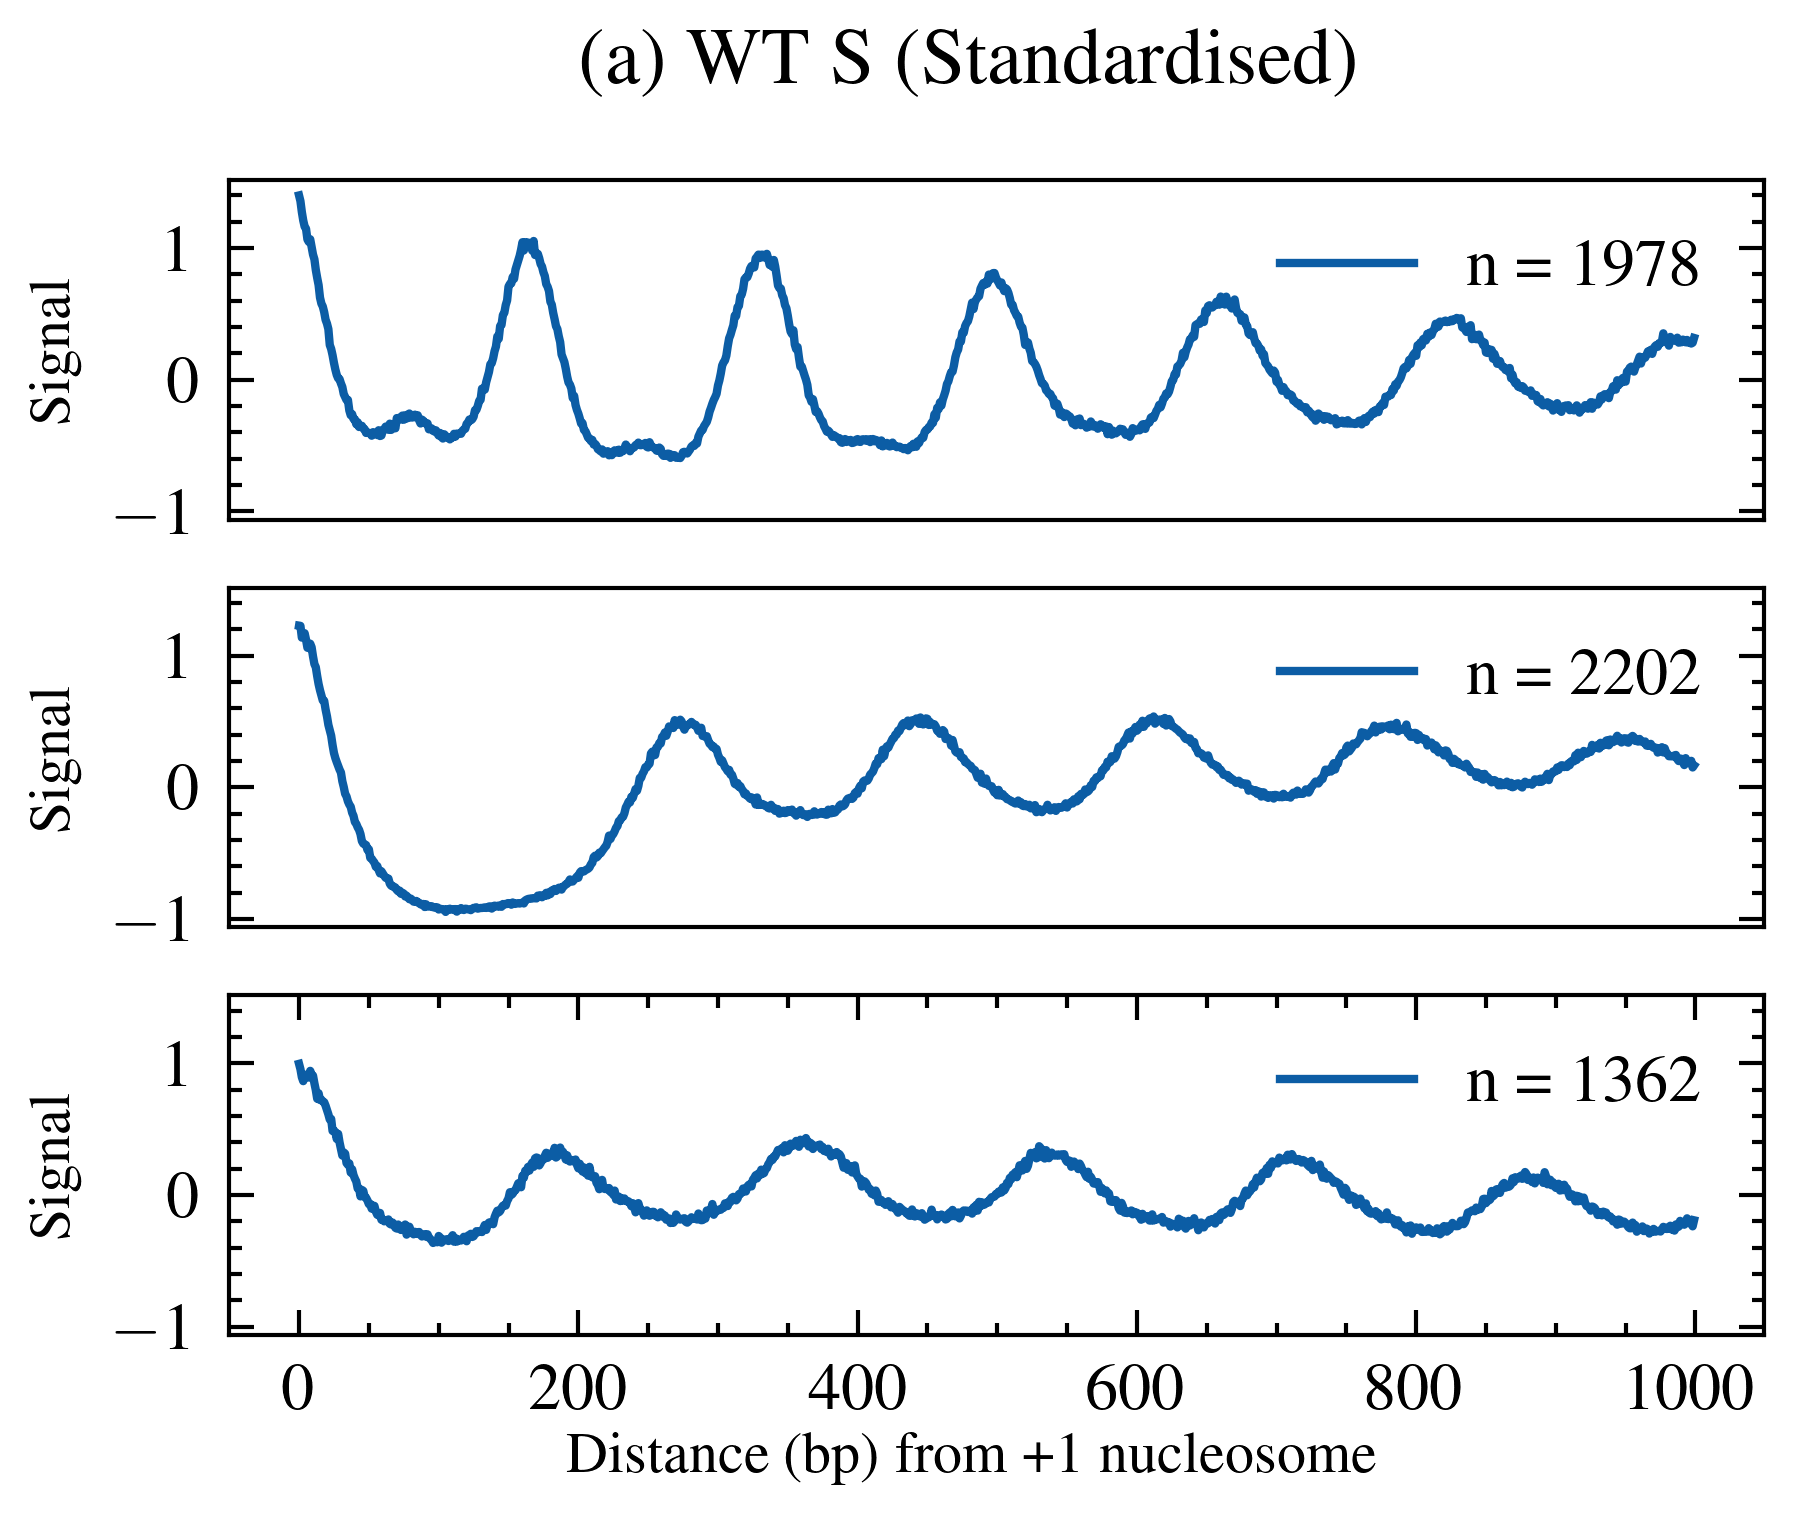

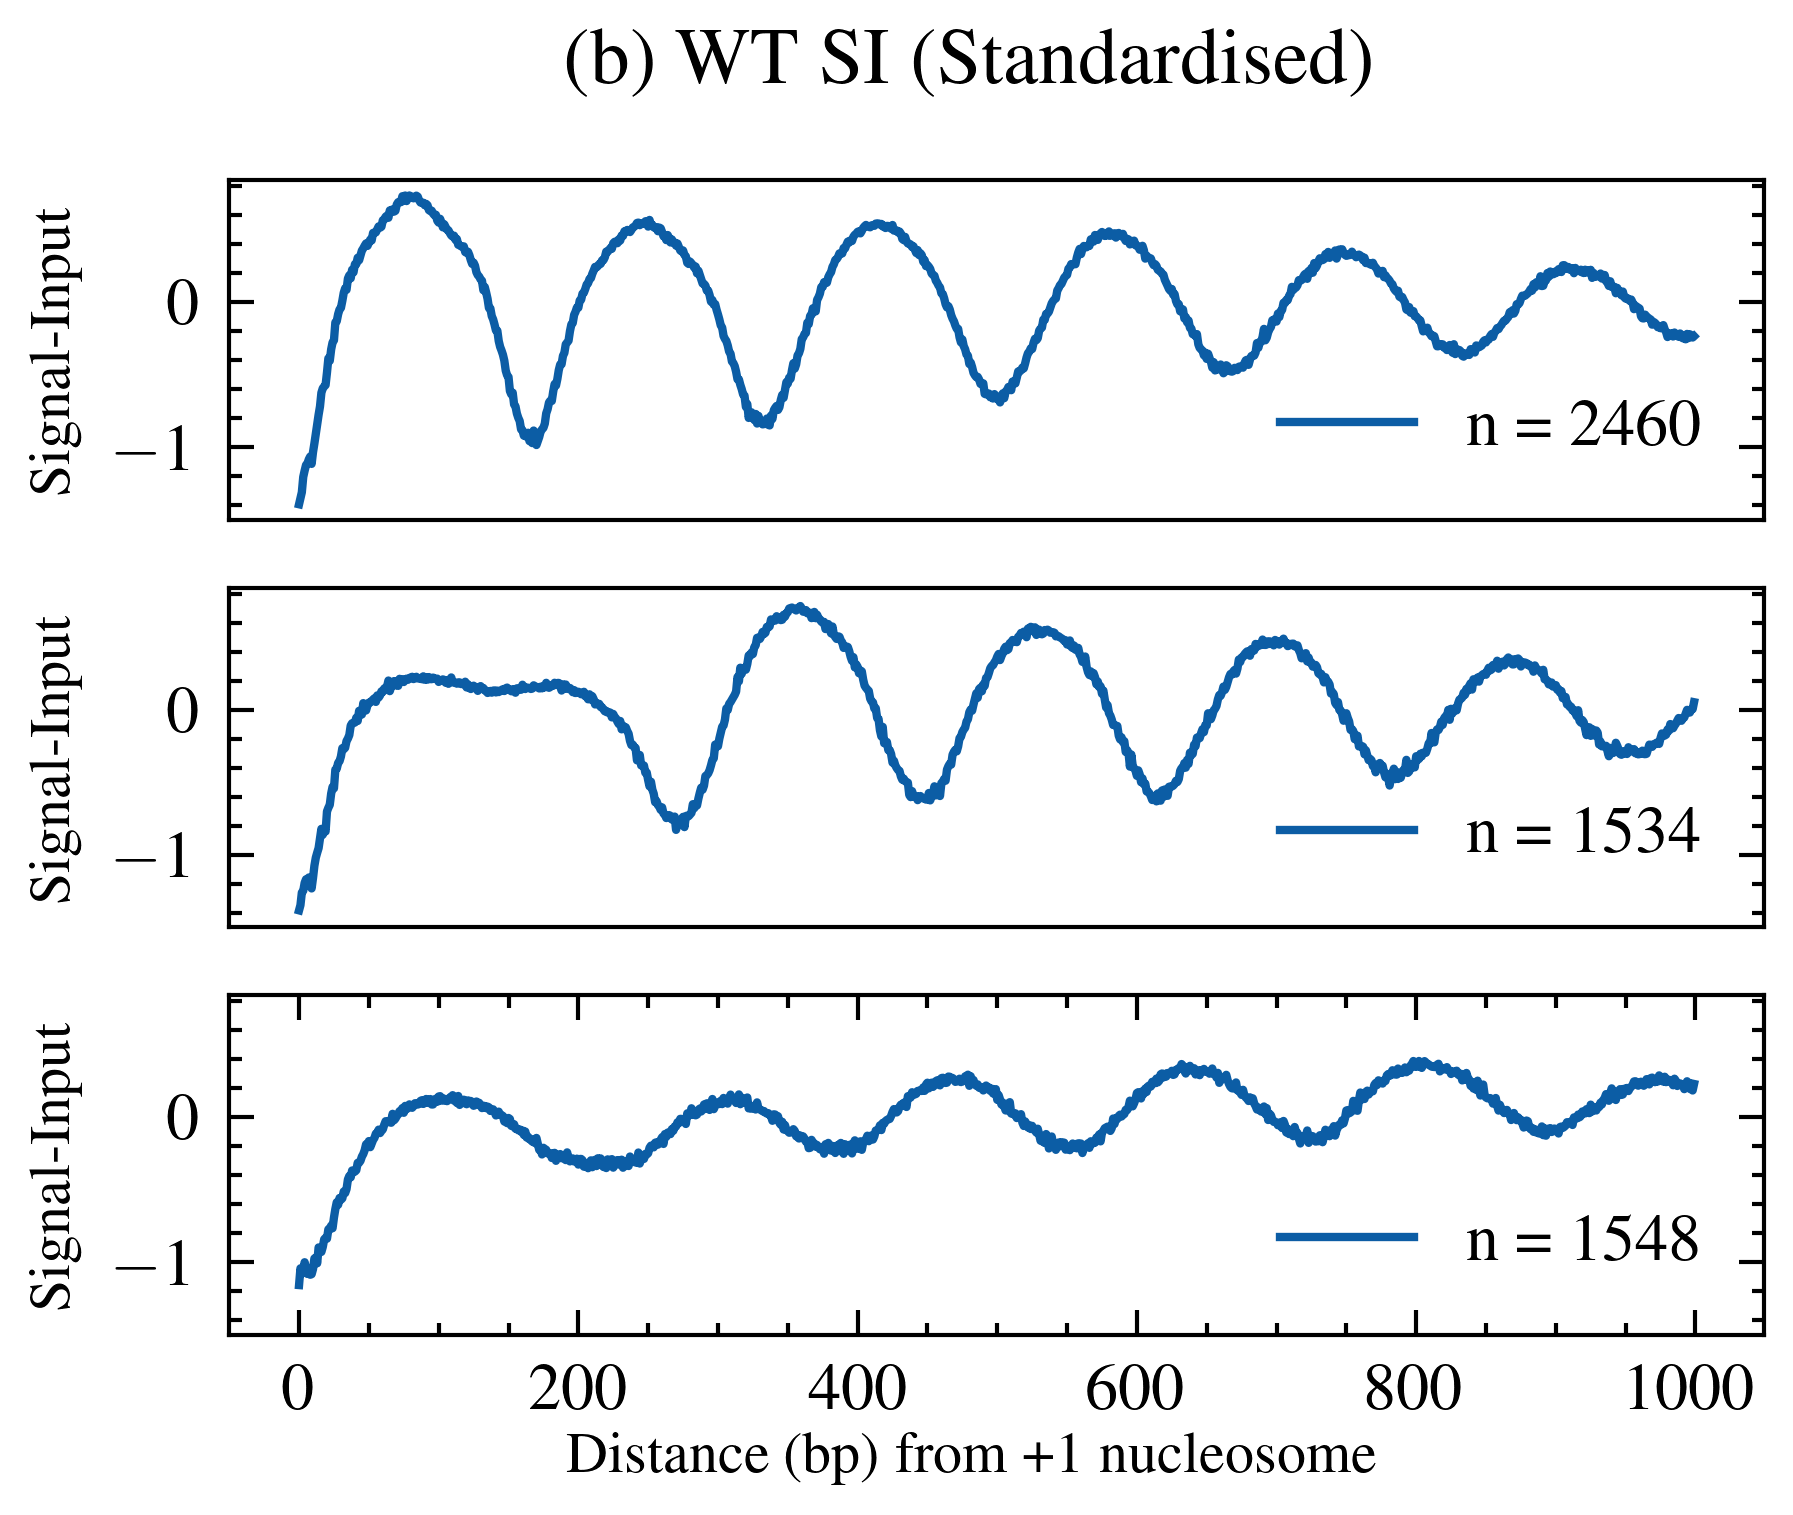

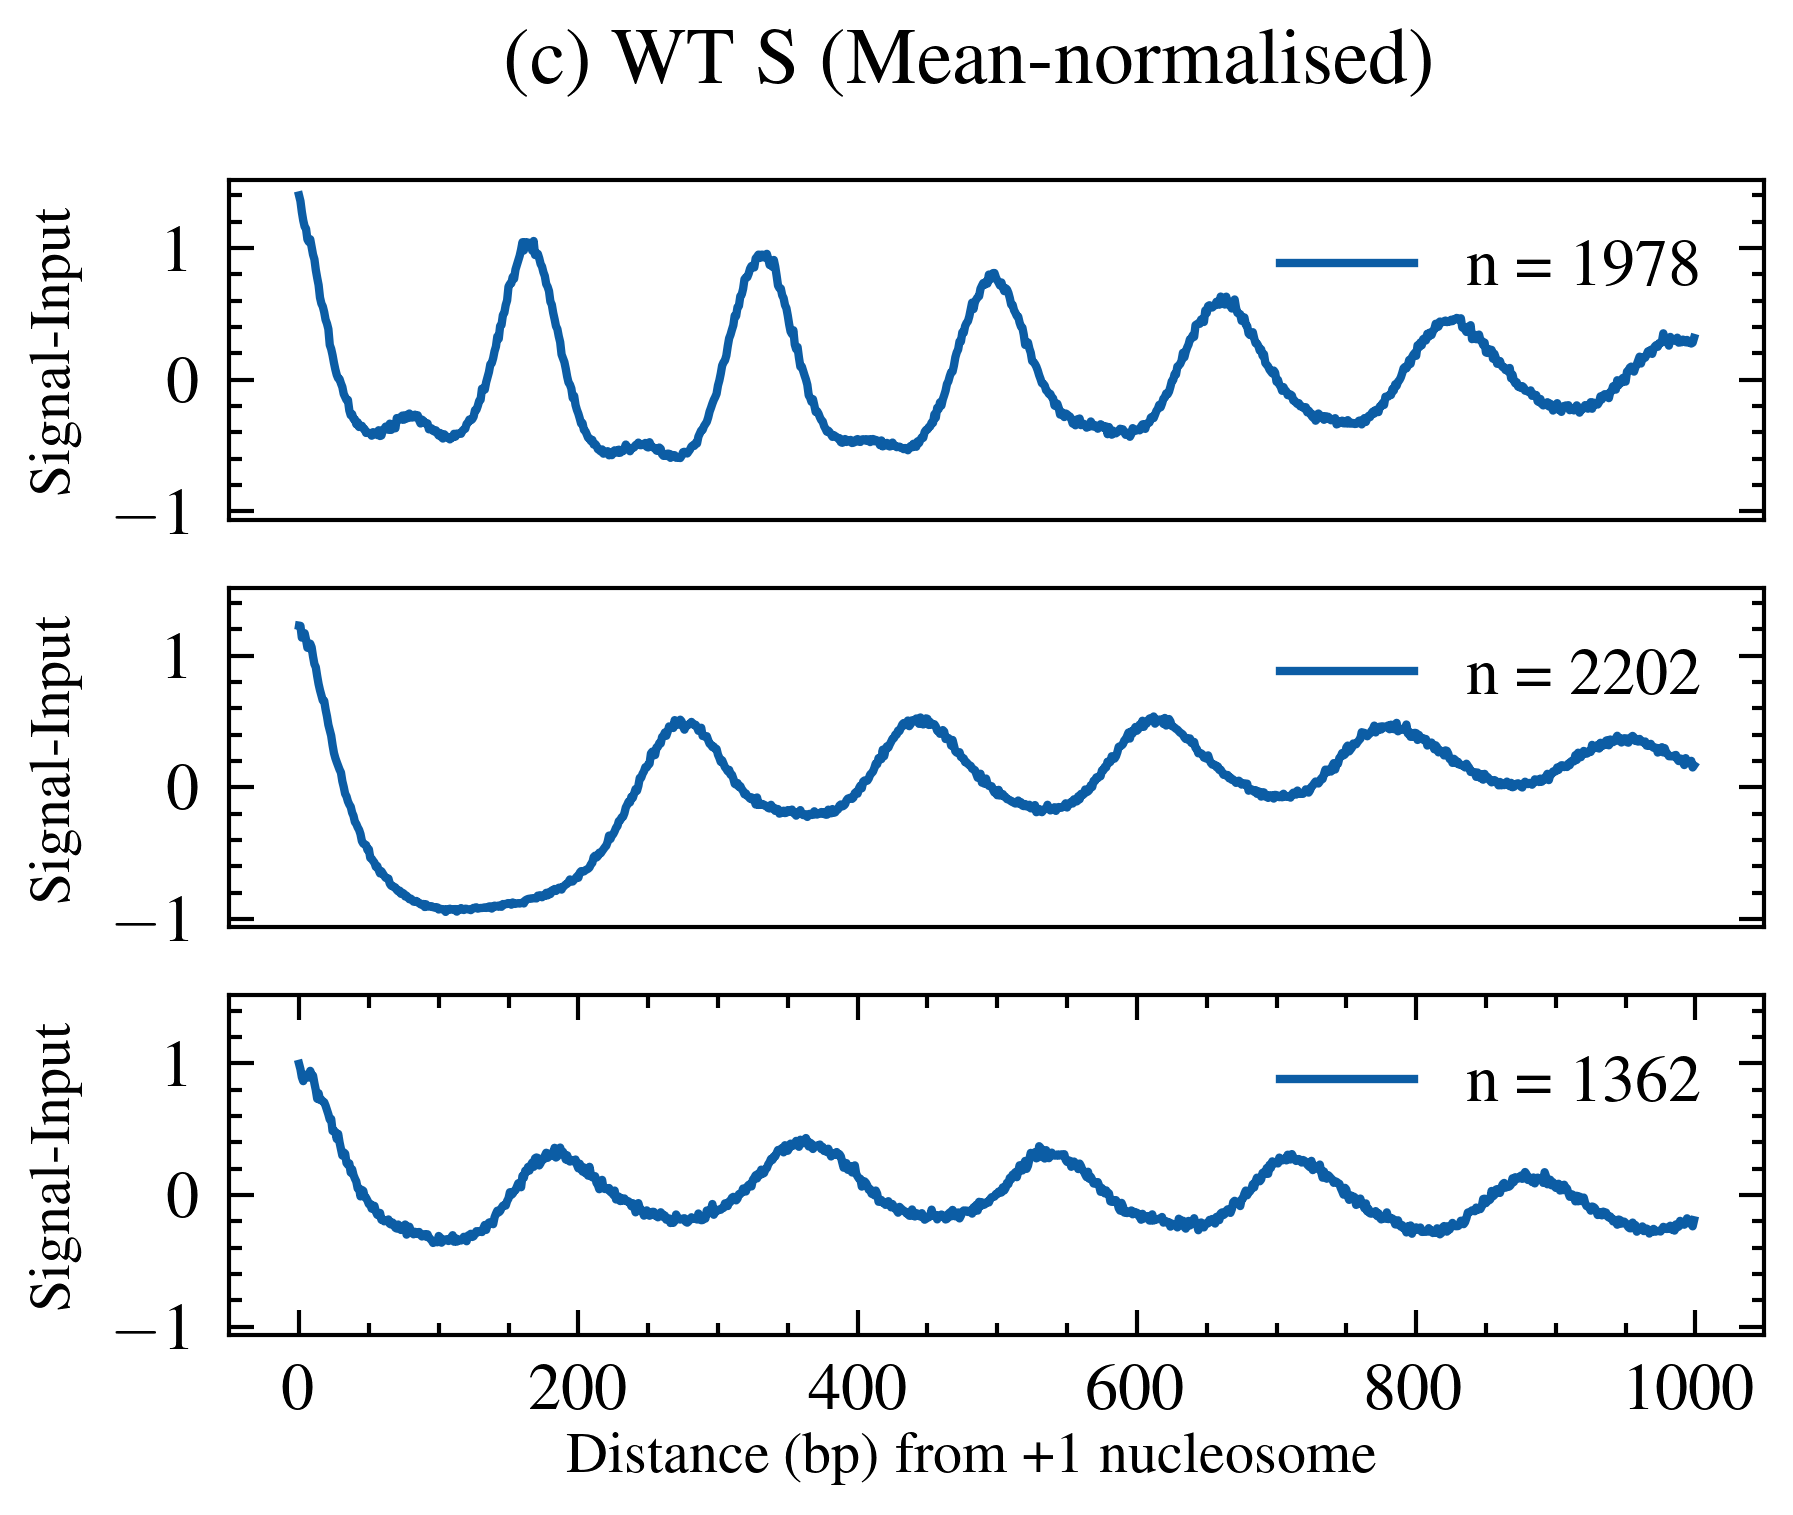

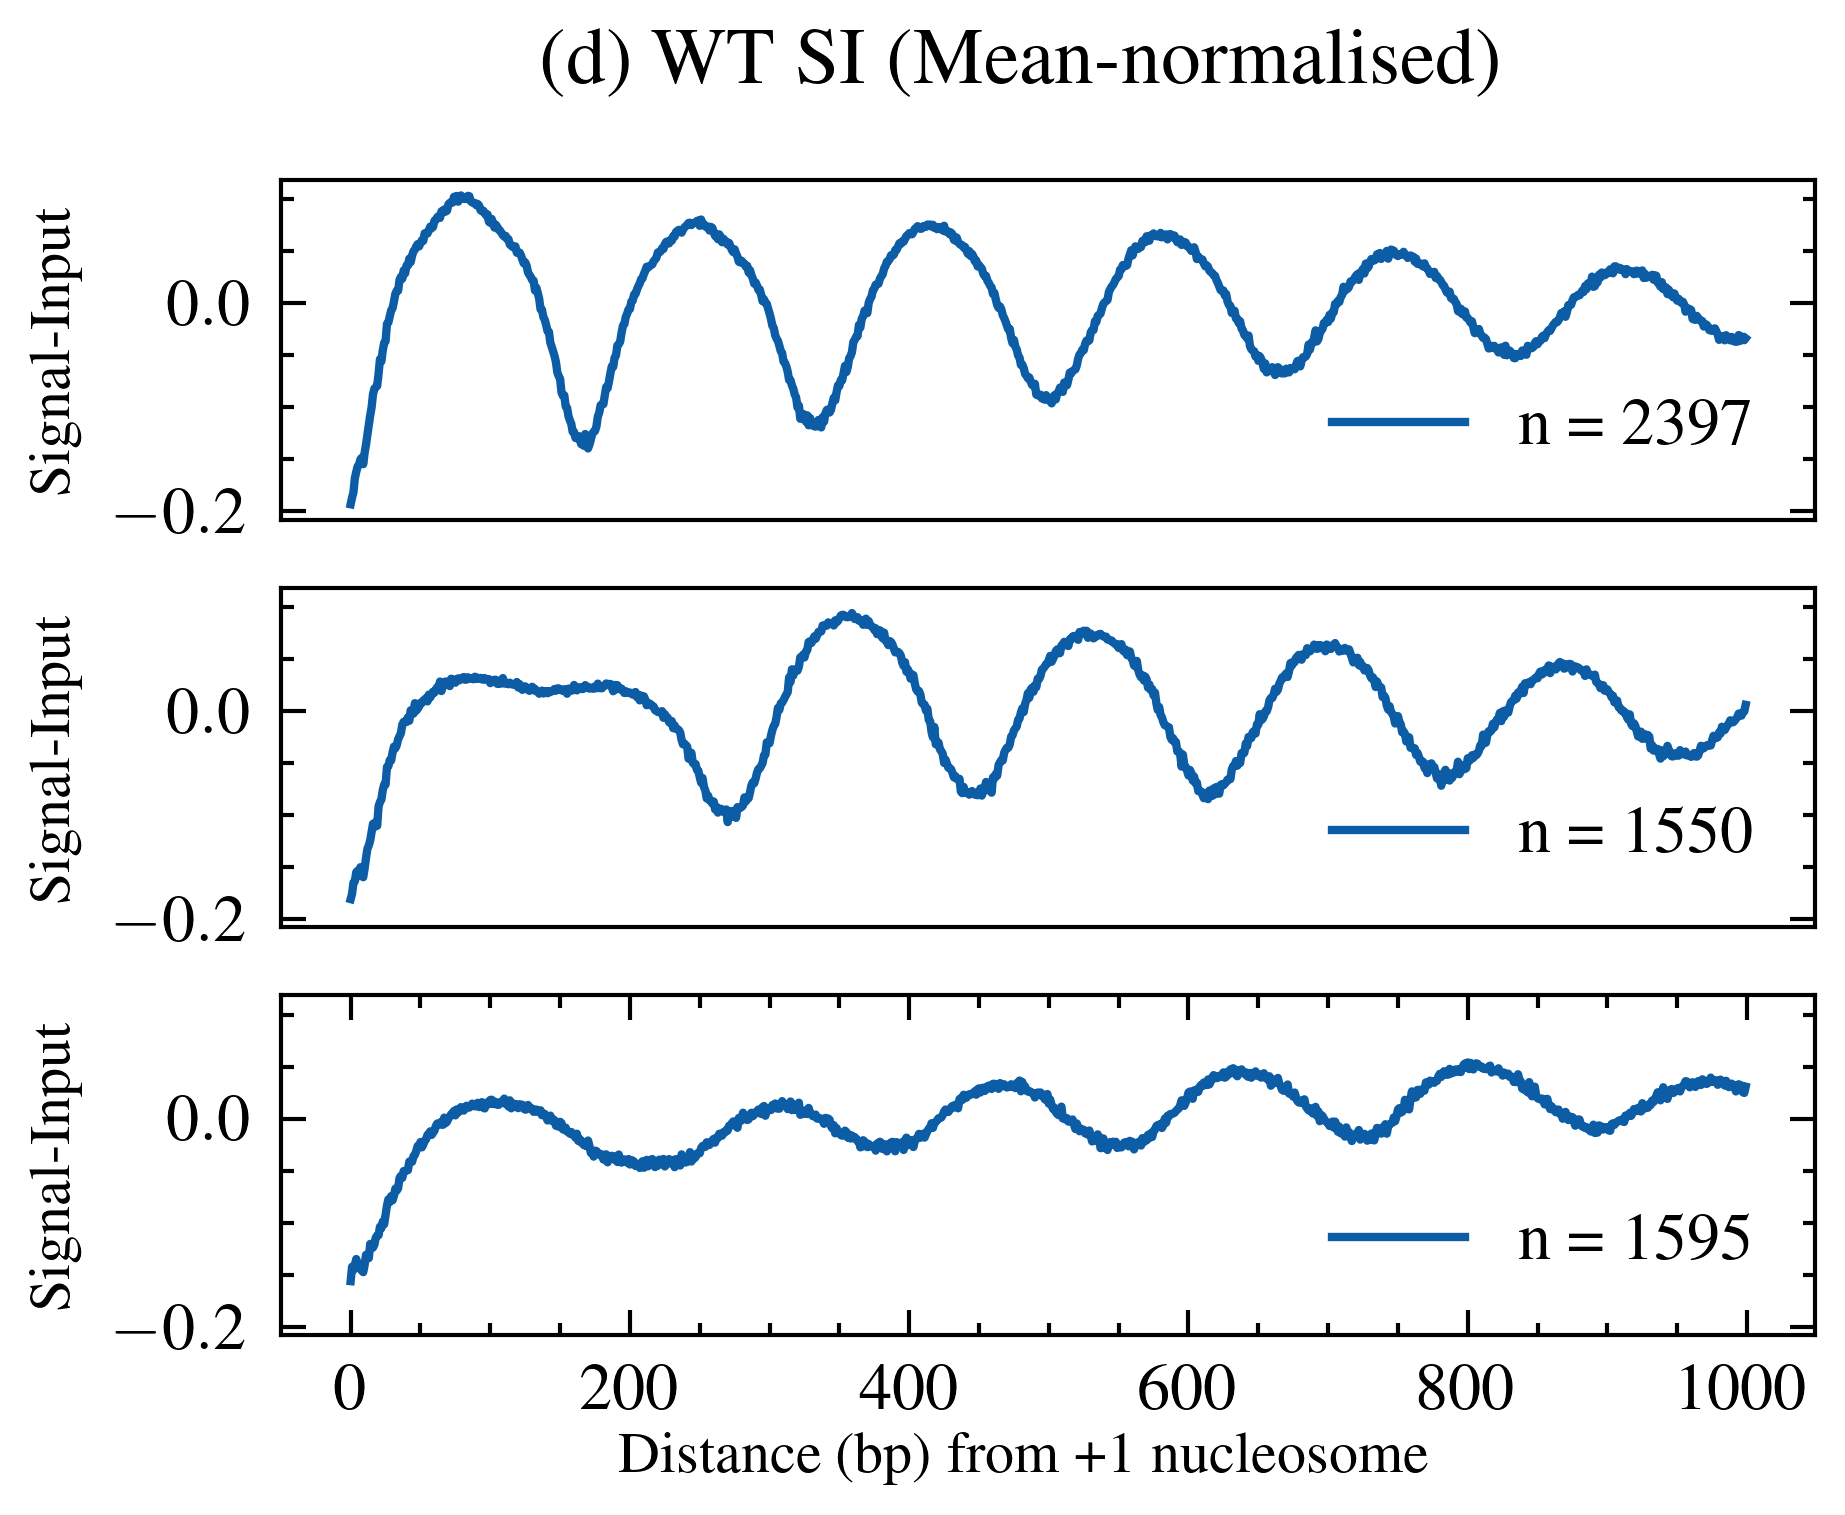

In [22]:
#generate n & shape of every cluster

with plt.style.context(['science','ieee','std-colors']):
    fig, axs = plt.subplots(3,1)
    for i in range(3):
        cluster = WT_S_znorm_clusters[i]
        axs[i].plot(cluster.mean(), label = f"n = {len(cluster)}")   
        axs[i].legend()
        axs[i].set_ylabel('Signal',fontsize=7)
        axs[i].sharey(axs[0])
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    plt.suptitle("(a) WT S (Standardised)")
    fig.supxlabel('Distance (bp) from +1 nucleosome',fontsize=7)
    plt.show()

with plt.style.context(['science','ieee','std-colors']):
    fig, axs = plt.subplots(3,1)
    for i in range(3):
        cluster = WT_SI_znorm_clusters[i]
        axs[i].plot(cluster.mean(), label = f"n = {len(cluster)}")   
        axs[i].legend()
        axs[i].set_ylabel('Signal-Input',fontsize=7)
        axs[i].sharey(axs[0])
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    plt.suptitle("(b) WT SI (Standardised)")
    fig.supxlabel('Distance (bp) from +1 nucleosome',fontsize=7)
    plt.show()


with plt.style.context(['science','ieee','std-colors']):
    fig, axs = plt.subplots(3,1)
    for i in range(3):
        cluster = WT_S_meannorm_clusters[i]
        axs[i].plot(cluster.mean(), label = f"n = {len(cluster)}")   
        axs[i].legend()
        axs[i].set_ylabel('Signal-Input',fontsize=7)
        axs[i].sharey(axs[0])
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    plt.suptitle("(c) WT S (Mean-normalised)")
    fig.supxlabel('Distance (bp) from +1 nucleosome',fontsize=7)
    plt.show()

with plt.style.context(['science','ieee','std-colors']):
    fig, axs = plt.subplots(3,1)
    for i in range(3):
        cluster = WT_SI_meannorm_clusters[i]
        axs[i].plot(cluster.mean(), label = f"n = {len(cluster)}")   
        axs[i].legend()
        axs[i].set_ylabel('Signal-Input',fontsize=7)
        axs[i].sharey(axs[0])
    axs[0].set_xticks([])
    axs[1].set_xticks([])
    plt.suptitle("(d) WT SI (Mean-normalised)")
    fig.supxlabel('Distance (bp) from +1 nucleosome',fontsize=7)
    plt.show()
